/home/admin_user/.pyenv/versions/3.10.8/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda
test dataset: (102912, 2) 

sequential_model(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Linear(in_features=20, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)


<AxesSubplot: title={'center': '$u(x)$'}, xlabel='$t$', ylabel='$x$'>

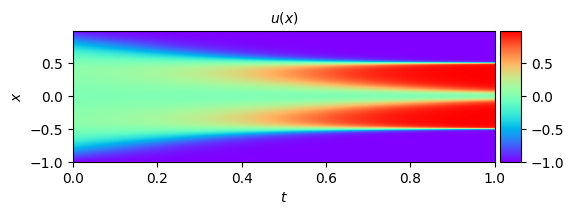

In [1]:
import numpy as np
import torch
import scipy.io

from visualization import *
from main import *
from used_attacks import regression_PGD

''' Settings and seeds '''

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("device:", device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 
    
''' test dataset '''

data = scipy.io.loadmat('AC.mat')

x = data['x'][0]
t = data['tt'][0]
X, T = np.meshgrid(x,t)
U_gt = data['uu']

x_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_test = U_gt.flatten('F')[:,None]
print("test dataset:", x_test.shape, '\n')

''' model '''

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
PINN = sequential_model(layers, device)
PINN.to(device)
print(PINN)
plot_u(U_gt, x, t, title="$u(x)$")

In [2]:
def generate_attack_samples(model, device, x_train, N0, n_samples=1000, \
    lb=[-1,0], ub=[1,1], steps=20, eps=2e-1, eta=2e-2, m=1.5):
    
    attack = regression_PGD(model, lb=lb, ub=ub, steps=steps, eps=eps, eta=eta)
    x_adv = attack.attack(x_train).cpu().detach().numpy()
    
    if x_adv.shape[0] > N0 + (m+1)*n_samples:
        x_adv = np.vstack([x_adv[:N0,:] ,x_adv[-int((m+1)*n_samples):,:]])

    f_adv_pred = np.abs(model.function(x_adv).squeeze().cpu().detach().numpy())
    index = np.argsort(f_adv_pred)[::-1][:n_samples]
    x_adv = x_adv[index,:]
    f_adv_pred = f_adv_pred[index]
    
    plot_samples(x_adv, f_adv_pred)
    
    return x_adv


def retrain(model, x_train, x_adv, x_boundary, u_boundary, x_test, u_test, U_gt, epoch=1e6):
    
    x_train_temp = np.vstack([x_train, x_adv])
    
    f_test_pred = np.abs(model.function(x_test).squeeze().cpu().detach().numpy())
    plot_u(f_test_pred.reshape(X.shape).T, x, t, log=True, title="test $r(x;theta)$")

    model.iter = 0
    optimizer = torch.optim.Adam(PINN.parameters(), lr=0.00001)
    model.train_model_adam(optimizer, x_boundary, u_boundary, x_train_temp, epoch)
                           
    rmse, u_pred = model.test(x_test, u_test)
    print('Test RMSE: %.5f'  % (rmse))
                           
    plot_u_x(u_pred.reshape(X.shape).T, U_gt, x, t)
    plot_u(np.abs(u_pred.reshape(X.shape).T-U_gt), x, t, log=True, title="$|u(x;theta)-u(x)|$")

1000 tensor(0.4328, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.4293, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.4281, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.4264, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.4238, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.4179, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.2622, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.2173, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0859, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0741, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0570, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0477, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0409, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0258, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0060, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)
17000 tensor(0.00

129000 tensor(5.4336e-06, device='cuda:0', grad_fn=<AddBackward0>)
130000 tensor(5.2888e-06, device='cuda:0', grad_fn=<AddBackward0>)
131000 tensor(5.1858e-06, device='cuda:0', grad_fn=<AddBackward0>)
132000 tensor(5.1091e-06, device='cuda:0', grad_fn=<AddBackward0>)
133000 tensor(4.9898e-06, device='cuda:0', grad_fn=<AddBackward0>)
134000 tensor(4.8973e-06, device='cuda:0', grad_fn=<AddBackward0>)
135000 tensor(4.8503e-06, device='cuda:0', grad_fn=<AddBackward0>)
136000 tensor(4.7255e-06, device='cuda:0', grad_fn=<AddBackward0>)
137000 tensor(4.6904e-06, device='cuda:0', grad_fn=<AddBackward0>)
138000 tensor(4.5796e-06, device='cuda:0', grad_fn=<AddBackward0>)
139000 tensor(4.6155e-06, device='cuda:0', grad_fn=<AddBackward0>)
140000 tensor(4.6267e-06, device='cuda:0', grad_fn=<AddBackward0>)
141000 tensor(4.3759e-06, device='cuda:0', grad_fn=<AddBackward0>)
142000 tensor(4.2689e-06, device='cuda:0', grad_fn=<AddBackward0>)
143000 tensor(4.2032e-06, device='cuda:0', grad_fn=<AddBackwar

252000 tensor(1.6473e-06, device='cuda:0', grad_fn=<AddBackward0>)
253000 tensor(1.6395e-06, device='cuda:0', grad_fn=<AddBackward0>)
254000 tensor(1.6318e-06, device='cuda:0', grad_fn=<AddBackward0>)
255000 tensor(1.6243e-06, device='cuda:0', grad_fn=<AddBackward0>)
256000 tensor(1.6474e-06, device='cuda:0', grad_fn=<AddBackward0>)
257000 tensor(1.6092e-06, device='cuda:0', grad_fn=<AddBackward0>)
258000 tensor(1.6024e-06, device='cuda:0', grad_fn=<AddBackward0>)
259000 tensor(1.5952e-06, device='cuda:0', grad_fn=<AddBackward0>)
260000 tensor(1.5884e-06, device='cuda:0', grad_fn=<AddBackward0>)
261000 tensor(1.5826e-06, device='cuda:0', grad_fn=<AddBackward0>)
262000 tensor(1.5766e-06, device='cuda:0', grad_fn=<AddBackward0>)
263000 tensor(1.5699e-06, device='cuda:0', grad_fn=<AddBackward0>)
264000 tensor(1.5635e-06, device='cuda:0', grad_fn=<AddBackward0>)
265000 tensor(1.5576e-06, device='cuda:0', grad_fn=<AddBackward0>)
266000 tensor(1.5510e-06, device='cuda:0', grad_fn=<AddBackwar

375000 tensor(1.1289e-06, device='cuda:0', grad_fn=<AddBackward0>)
376000 tensor(1.1267e-06, device='cuda:0', grad_fn=<AddBackward0>)
377000 tensor(1.1243e-06, device='cuda:0', grad_fn=<AddBackward0>)
378000 tensor(1.1219e-06, device='cuda:0', grad_fn=<AddBackward0>)
379000 tensor(1.1200e-06, device='cuda:0', grad_fn=<AddBackward0>)
380000 tensor(1.1179e-06, device='cuda:0', grad_fn=<AddBackward0>)
381000 tensor(1.1154e-06, device='cuda:0', grad_fn=<AddBackward0>)
382000 tensor(1.1131e-06, device='cuda:0', grad_fn=<AddBackward0>)
383000 tensor(1.1107e-06, device='cuda:0', grad_fn=<AddBackward0>)
384000 tensor(1.1083e-06, device='cuda:0', grad_fn=<AddBackward0>)
385000 tensor(1.1058e-06, device='cuda:0', grad_fn=<AddBackward0>)
386000 tensor(1.1036e-06, device='cuda:0', grad_fn=<AddBackward0>)
387000 tensor(1.1013e-06, device='cuda:0', grad_fn=<AddBackward0>)
388000 tensor(1.0989e-06, device='cuda:0', grad_fn=<AddBackward0>)
389000 tensor(1.0974e-06, device='cuda:0', grad_fn=<AddBackwar

498000 tensor(9.1909e-07, device='cuda:0', grad_fn=<AddBackward0>)
499000 tensor(9.1762e-07, device='cuda:0', grad_fn=<AddBackward0>)
500000 tensor(9.1636e-07, device='cuda:0', grad_fn=<AddBackward0>)
501000 tensor(9.1494e-07, device='cuda:0', grad_fn=<AddBackward0>)
502000 tensor(9.1399e-07, device='cuda:0', grad_fn=<AddBackward0>)
503000 tensor(9.1269e-07, device='cuda:0', grad_fn=<AddBackward0>)
504000 tensor(9.1155e-07, device='cuda:0', grad_fn=<AddBackward0>)
505000 tensor(9.1020e-07, device='cuda:0', grad_fn=<AddBackward0>)
506000 tensor(9.0906e-07, device='cuda:0', grad_fn=<AddBackward0>)
507000 tensor(9.0796e-07, device='cuda:0', grad_fn=<AddBackward0>)
508000 tensor(9.0694e-07, device='cuda:0', grad_fn=<AddBackward0>)
509000 tensor(9.0564e-07, device='cuda:0', grad_fn=<AddBackward0>)
510000 tensor(9.0461e-07, device='cuda:0', grad_fn=<AddBackward0>)
511000 tensor(9.0340e-07, device='cuda:0', grad_fn=<AddBackward0>)
512000 tensor(9.0203e-07, device='cuda:0', grad_fn=<AddBackwar

621000 tensor(7.9934e-07, device='cuda:0', grad_fn=<AddBackward0>)
622000 tensor(7.9866e-07, device='cuda:0', grad_fn=<AddBackward0>)
623000 tensor(7.9764e-07, device='cuda:0', grad_fn=<AddBackward0>)
624000 tensor(7.9713e-07, device='cuda:0', grad_fn=<AddBackward0>)
625000 tensor(7.9629e-07, device='cuda:0', grad_fn=<AddBackward0>)
626000 tensor(7.9536e-07, device='cuda:0', grad_fn=<AddBackward0>)
627000 tensor(7.9478e-07, device='cuda:0', grad_fn=<AddBackward0>)
628000 tensor(7.9398e-07, device='cuda:0', grad_fn=<AddBackward0>)
629000 tensor(7.9327e-07, device='cuda:0', grad_fn=<AddBackward0>)
630000 tensor(7.9242e-07, device='cuda:0', grad_fn=<AddBackward0>)
631000 tensor(7.9175e-07, device='cuda:0', grad_fn=<AddBackward0>)
632000 tensor(7.9107e-07, device='cuda:0', grad_fn=<AddBackward0>)
633000 tensor(7.9048e-07, device='cuda:0', grad_fn=<AddBackward0>)
634000 tensor(7.8957e-07, device='cuda:0', grad_fn=<AddBackward0>)
635000 tensor(7.8909e-07, device='cuda:0', grad_fn=<AddBackwar

744000 tensor(7.1991e-07, device='cuda:0', grad_fn=<AddBackward0>)
745000 tensor(7.1934e-07, device='cuda:0', grad_fn=<AddBackward0>)
746000 tensor(7.1891e-07, device='cuda:0', grad_fn=<AddBackward0>)
747000 tensor(7.1829e-07, device='cuda:0', grad_fn=<AddBackward0>)
748000 tensor(7.1771e-07, device='cuda:0', grad_fn=<AddBackward0>)
749000 tensor(7.1719e-07, device='cuda:0', grad_fn=<AddBackward0>)
750000 tensor(7.1659e-07, device='cuda:0', grad_fn=<AddBackward0>)
751000 tensor(7.1603e-07, device='cuda:0', grad_fn=<AddBackward0>)
752000 tensor(7.1538e-07, device='cuda:0', grad_fn=<AddBackward0>)
753000 tensor(7.1502e-07, device='cuda:0', grad_fn=<AddBackward0>)
754000 tensor(8.6749e-06, device='cuda:0', grad_fn=<AddBackward0>)
755000 tensor(7.1407e-07, device='cuda:0', grad_fn=<AddBackward0>)
756000 tensor(7.1352e-07, device='cuda:0', grad_fn=<AddBackward0>)
757000 tensor(7.1299e-07, device='cuda:0', grad_fn=<AddBackward0>)
758000 tensor(7.1233e-07, device='cuda:0', grad_fn=<AddBackwar

867000 tensor(6.6425e-07, device='cuda:0', grad_fn=<AddBackward0>)
868000 tensor(6.6142e-07, device='cuda:0', grad_fn=<AddBackward0>)
869000 tensor(6.6090e-07, device='cuda:0', grad_fn=<AddBackward0>)
870000 tensor(6.6044e-07, device='cuda:0', grad_fn=<AddBackward0>)
871000 tensor(6.6018e-07, device='cuda:0', grad_fn=<AddBackward0>)
872000 tensor(6.5978e-07, device='cuda:0', grad_fn=<AddBackward0>)
873000 tensor(6.5921e-07, device='cuda:0', grad_fn=<AddBackward0>)
874000 tensor(6.5892e-07, device='cuda:0', grad_fn=<AddBackward0>)
875000 tensor(6.5846e-07, device='cuda:0', grad_fn=<AddBackward0>)
876000 tensor(6.5790e-07, device='cuda:0', grad_fn=<AddBackward0>)
877000 tensor(6.5763e-07, device='cuda:0', grad_fn=<AddBackward0>)
878000 tensor(6.5731e-07, device='cuda:0', grad_fn=<AddBackward0>)
879000 tensor(6.5693e-07, device='cuda:0', grad_fn=<AddBackward0>)
880000 tensor(6.5639e-07, device='cuda:0', grad_fn=<AddBackward0>)
881000 tensor(6.5602e-07, device='cuda:0', grad_fn=<AddBackwar

990000 tensor(6.1654e-07, device='cuda:0', grad_fn=<AddBackward0>)
991000 tensor(6.1615e-07, device='cuda:0', grad_fn=<AddBackward0>)
992000 tensor(6.1595e-07, device='cuda:0', grad_fn=<AddBackward0>)
993000 tensor(6.1564e-07, device='cuda:0', grad_fn=<AddBackward0>)
994000 tensor(6.1528e-07, device='cuda:0', grad_fn=<AddBackward0>)
995000 tensor(6.1498e-07, device='cuda:0', grad_fn=<AddBackward0>)
996000 tensor(6.1463e-07, device='cuda:0', grad_fn=<AddBackward0>)
997000 tensor(6.1420e-07, device='cuda:0', grad_fn=<AddBackward0>)
998000 tensor(6.1405e-07, device='cuda:0', grad_fn=<AddBackward0>)
999000 tensor(6.1368e-07, device='cuda:0', grad_fn=<AddBackward0>)
1000000 tensor(6.1330e-07, device='cuda:0', grad_fn=<AddBackward0>)
Test RMSE: 0.66492


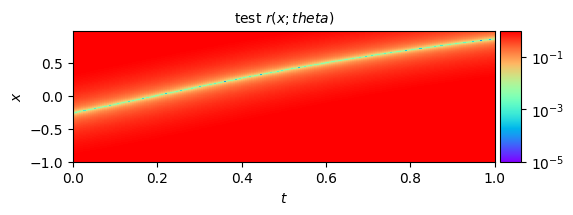

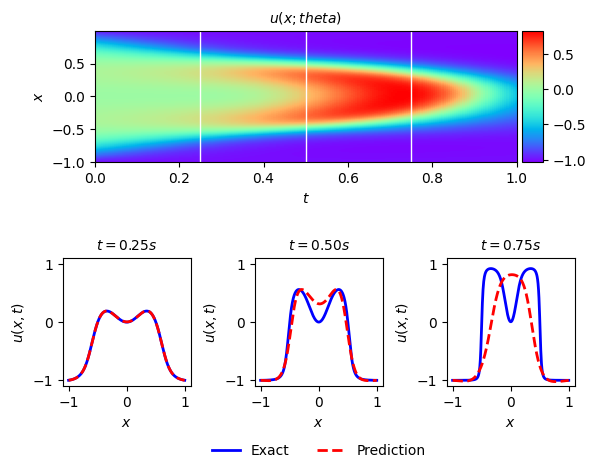

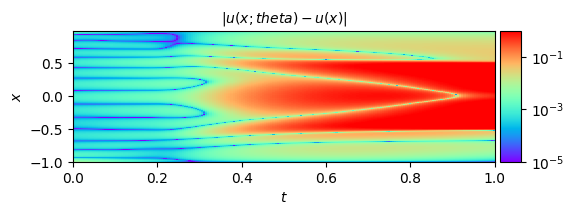

In [3]:
''' k=0 '''
N0 = 500
x_train, x_boundary, u_boundary = training_data_latin_hypercube(X, T, U_gt, N_inner=N0, ub=[1,0.2])
retrain(PINN, x_train, np.array([]).reshape((0,2)), \
    x_boundary, u_boundary, x_test, u_test, U_gt)


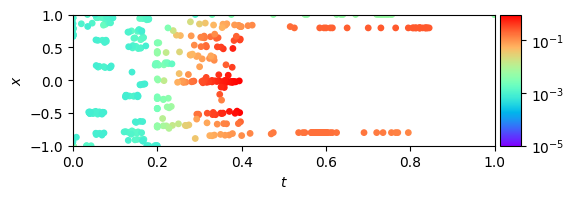

1000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(7.8767e-05, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(6.0188e-05, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(4.7074e-05, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(3.7673e-05, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(3.0828e-05, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(2.5864e-05, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(2.2268e-05, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(1.9543e-05, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(1.7489e-05, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(1.5901e-05, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(1.4648e-05, device='cuda:0

126000 tensor(3.1635e-06, device='cuda:0', grad_fn=<AddBackward0>)
127000 tensor(3.0886e-06, device='cuda:0', grad_fn=<AddBackward0>)
128000 tensor(3.0732e-06, device='cuda:0', grad_fn=<AddBackward0>)
129000 tensor(4.4782e-06, device='cuda:0', grad_fn=<AddBackward0>)
130000 tensor(3.0435e-06, device='cuda:0', grad_fn=<AddBackward0>)
131000 tensor(3.0298e-06, device='cuda:0', grad_fn=<AddBackward0>)
132000 tensor(3.0156e-06, device='cuda:0', grad_fn=<AddBackward0>)
133000 tensor(3.0010e-06, device='cuda:0', grad_fn=<AddBackward0>)
134000 tensor(2.9870e-06, device='cuda:0', grad_fn=<AddBackward0>)
135000 tensor(2.9861e-06, device='cuda:0', grad_fn=<AddBackward0>)
136000 tensor(3.0234e-06, device='cuda:0', grad_fn=<AddBackward0>)
137000 tensor(3.2862e-06, device='cuda:0', grad_fn=<AddBackward0>)
138000 tensor(2.9320e-06, device='cuda:0', grad_fn=<AddBackward0>)
139000 tensor(2.9184e-06, device='cuda:0', grad_fn=<AddBackward0>)
140000 tensor(2.9062e-06, device='cuda:0', grad_fn=<AddBackwar

249000 tensor(1.9063e-06, device='cuda:0', grad_fn=<AddBackward0>)
250000 tensor(1.9001e-06, device='cuda:0', grad_fn=<AddBackward0>)
251000 tensor(1.8937e-06, device='cuda:0', grad_fn=<AddBackward0>)
252000 tensor(1.8960e-06, device='cuda:0', grad_fn=<AddBackward0>)
253000 tensor(1.8812e-06, device='cuda:0', grad_fn=<AddBackward0>)
254000 tensor(1.8751e-06, device='cuda:0', grad_fn=<AddBackward0>)
255000 tensor(1.8688e-06, device='cuda:0', grad_fn=<AddBackward0>)
256000 tensor(1.9074e-06, device='cuda:0', grad_fn=<AddBackward0>)
257000 tensor(1.8561e-06, device='cuda:0', grad_fn=<AddBackward0>)
258000 tensor(1.8503e-06, device='cuda:0', grad_fn=<AddBackward0>)
259000 tensor(1.8440e-06, device='cuda:0', grad_fn=<AddBackward0>)
260000 tensor(1.8381e-06, device='cuda:0', grad_fn=<AddBackward0>)
261000 tensor(1.8322e-06, device='cuda:0', grad_fn=<AddBackward0>)
262000 tensor(1.8261e-06, device='cuda:0', grad_fn=<AddBackward0>)
263000 tensor(1.8200e-06, device='cuda:0', grad_fn=<AddBackwar

372000 tensor(1.3547e-06, device='cuda:0', grad_fn=<AddBackward0>)
373000 tensor(1.3514e-06, device='cuda:0', grad_fn=<AddBackward0>)
374000 tensor(1.3486e-06, device='cuda:0', grad_fn=<AddBackward0>)
375000 tensor(1.3456e-06, device='cuda:0', grad_fn=<AddBackward0>)
376000 tensor(1.3425e-06, device='cuda:0', grad_fn=<AddBackward0>)
377000 tensor(1.3395e-06, device='cuda:0', grad_fn=<AddBackward0>)
378000 tensor(1.3367e-06, device='cuda:0', grad_fn=<AddBackward0>)
379000 tensor(1.3337e-06, device='cuda:0', grad_fn=<AddBackward0>)
380000 tensor(1.3309e-06, device='cuda:0', grad_fn=<AddBackward0>)
381000 tensor(1.3281e-06, device='cuda:0', grad_fn=<AddBackward0>)
382000 tensor(1.3251e-06, device='cuda:0', grad_fn=<AddBackward0>)
383000 tensor(1.3223e-06, device='cuda:0', grad_fn=<AddBackward0>)
384000 tensor(1.3193e-06, device='cuda:0', grad_fn=<AddBackward0>)
385000 tensor(1.3243e-06, device='cuda:0', grad_fn=<AddBackward0>)
386000 tensor(1.3137e-06, device='cuda:0', grad_fn=<AddBackwar

495000 tensor(1.0811e-06, device='cuda:0', grad_fn=<AddBackward0>)
496000 tensor(1.0797e-06, device='cuda:0', grad_fn=<AddBackward0>)
497000 tensor(1.0779e-06, device='cuda:0', grad_fn=<AddBackward0>)
498000 tensor(1.0767e-06, device='cuda:0', grad_fn=<AddBackward0>)
499000 tensor(1.0751e-06, device='cuda:0', grad_fn=<AddBackward0>)
500000 tensor(1.0736e-06, device='cuda:0', grad_fn=<AddBackward0>)
501000 tensor(1.0720e-06, device='cuda:0', grad_fn=<AddBackward0>)
502000 tensor(1.0705e-06, device='cuda:0', grad_fn=<AddBackward0>)
503000 tensor(1.0689e-06, device='cuda:0', grad_fn=<AddBackward0>)
504000 tensor(1.0674e-06, device='cuda:0', grad_fn=<AddBackward0>)
505000 tensor(1.0659e-06, device='cuda:0', grad_fn=<AddBackward0>)
506000 tensor(1.0643e-06, device='cuda:0', grad_fn=<AddBackward0>)
507000 tensor(1.0630e-06, device='cuda:0', grad_fn=<AddBackward0>)
508000 tensor(1.0612e-06, device='cuda:0', grad_fn=<AddBackward0>)
509000 tensor(1.0600e-06, device='cuda:0', grad_fn=<AddBackwar

618000 tensor(9.2865e-07, device='cuda:0', grad_fn=<AddBackward0>)
619000 tensor(9.2758e-07, device='cuda:0', grad_fn=<AddBackward0>)
620000 tensor(9.2673e-07, device='cuda:0', grad_fn=<AddBackward0>)
621000 tensor(9.2568e-07, device='cuda:0', grad_fn=<AddBackward0>)
622000 tensor(9.2484e-07, device='cuda:0', grad_fn=<AddBackward0>)
623000 tensor(9.2391e-07, device='cuda:0', grad_fn=<AddBackward0>)
624000 tensor(9.2337e-07, device='cuda:0', grad_fn=<AddBackward0>)
625000 tensor(9.2207e-07, device='cuda:0', grad_fn=<AddBackward0>)
626000 tensor(9.2107e-07, device='cuda:0', grad_fn=<AddBackward0>)
627000 tensor(9.2008e-07, device='cuda:0', grad_fn=<AddBackward0>)
628000 tensor(9.1922e-07, device='cuda:0', grad_fn=<AddBackward0>)
629000 tensor(9.1823e-07, device='cuda:0', grad_fn=<AddBackward0>)
630000 tensor(9.1718e-07, device='cuda:0', grad_fn=<AddBackward0>)
631000 tensor(9.1633e-07, device='cuda:0', grad_fn=<AddBackward0>)
632000 tensor(9.1549e-07, device='cuda:0', grad_fn=<AddBackwar

741000 tensor(1.3742e-06, device='cuda:0', grad_fn=<AddBackward0>)
742000 tensor(8.2865e-07, device='cuda:0', grad_fn=<AddBackward0>)
743000 tensor(8.2789e-07, device='cuda:0', grad_fn=<AddBackward0>)
744000 tensor(8.2716e-07, device='cuda:0', grad_fn=<AddBackward0>)
745000 tensor(8.2658e-07, device='cuda:0', grad_fn=<AddBackward0>)
746000 tensor(8.2581e-07, device='cuda:0', grad_fn=<AddBackward0>)
747000 tensor(8.2528e-07, device='cuda:0', grad_fn=<AddBackward0>)
748000 tensor(8.2485e-07, device='cuda:0', grad_fn=<AddBackward0>)
749000 tensor(8.2376e-07, device='cuda:0', grad_fn=<AddBackward0>)
750000 tensor(8.2327e-07, device='cuda:0', grad_fn=<AddBackward0>)
751000 tensor(8.2248e-07, device='cuda:0', grad_fn=<AddBackward0>)
752000 tensor(8.2479e-07, device='cuda:0', grad_fn=<AddBackward0>)
753000 tensor(8.2115e-07, device='cuda:0', grad_fn=<AddBackward0>)
754000 tensor(8.2042e-07, device='cuda:0', grad_fn=<AddBackward0>)
755000 tensor(8.1985e-07, device='cuda:0', grad_fn=<AddBackwar

864000 tensor(7.5812e-07, device='cuda:0', grad_fn=<AddBackward0>)
865000 tensor(7.5749e-07, device='cuda:0', grad_fn=<AddBackward0>)
866000 tensor(7.5708e-07, device='cuda:0', grad_fn=<AddBackward0>)
867000 tensor(7.5653e-07, device='cuda:0', grad_fn=<AddBackward0>)
868000 tensor(7.5620e-07, device='cuda:0', grad_fn=<AddBackward0>)
869000 tensor(7.5559e-07, device='cuda:0', grad_fn=<AddBackward0>)
870000 tensor(7.5502e-07, device='cuda:0', grad_fn=<AddBackward0>)
871000 tensor(7.5446e-07, device='cuda:0', grad_fn=<AddBackward0>)
872000 tensor(7.5406e-07, device='cuda:0', grad_fn=<AddBackward0>)
873000 tensor(7.5356e-07, device='cuda:0', grad_fn=<AddBackward0>)
874000 tensor(7.5305e-07, device='cuda:0', grad_fn=<AddBackward0>)
875000 tensor(7.5263e-07, device='cuda:0', grad_fn=<AddBackward0>)
876000 tensor(7.5196e-07, device='cuda:0', grad_fn=<AddBackward0>)
877000 tensor(7.5163e-07, device='cuda:0', grad_fn=<AddBackward0>)
878000 tensor(7.5118e-07, device='cuda:0', grad_fn=<AddBackwar

987000 tensor(7.0343e-07, device='cuda:0', grad_fn=<AddBackward0>)
988000 tensor(7.0303e-07, device='cuda:0', grad_fn=<AddBackward0>)
989000 tensor(7.0267e-07, device='cuda:0', grad_fn=<AddBackward0>)
990000 tensor(7.0236e-07, device='cuda:0', grad_fn=<AddBackward0>)
991000 tensor(7.0198e-07, device='cuda:0', grad_fn=<AddBackward0>)
992000 tensor(7.0157e-07, device='cuda:0', grad_fn=<AddBackward0>)
993000 tensor(7.0109e-07, device='cuda:0', grad_fn=<AddBackward0>)
994000 tensor(7.0077e-07, device='cuda:0', grad_fn=<AddBackward0>)
995000 tensor(7.0038e-07, device='cuda:0', grad_fn=<AddBackward0>)
996000 tensor(7.0008e-07, device='cuda:0', grad_fn=<AddBackward0>)
997000 tensor(6.9972e-07, device='cuda:0', grad_fn=<AddBackward0>)
998000 tensor(6.9930e-07, device='cuda:0', grad_fn=<AddBackward0>)
999000 tensor(6.9883e-07, device='cuda:0', grad_fn=<AddBackward0>)
1000000 tensor(6.9847e-07, device='cuda:0', grad_fn=<AddBackward0>)
Test RMSE: 0.36427


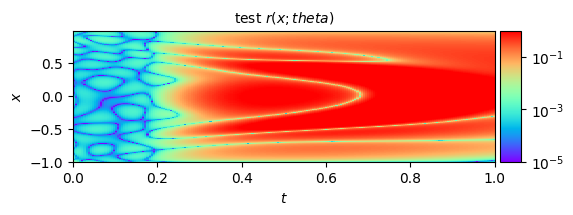

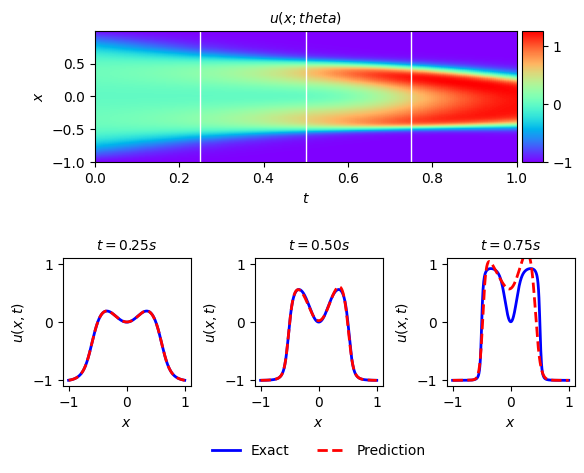

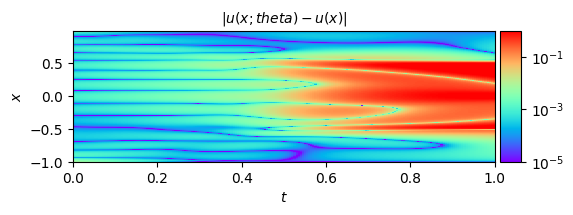

In [4]:
''' k=1 '''
x_adv = generate_attack_samples(PINN, device, x_train, N0, n_samples=500)
retrain(PINN, x_train, x_adv, x_boundary, u_boundary, x_test, u_test, U_gt)

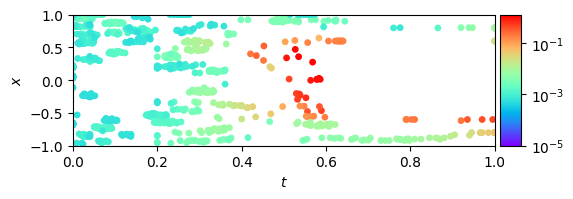

k= 2
1000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(8.3956e-05, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(7.0240e-05, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(5.9788e-05, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(5.1927e-05, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(4.5975e-05, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(4.1153e-05, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(3.7735e-05, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(3.3960e-05, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(3.1306e-05, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(2.9018e-05, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(2.7362e-05, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(2.5487e-05, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(2.4080e-05, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(2.2843e-0

125000 tensor(2.8734e-06, device='cuda:0', grad_fn=<AddBackward0>)
126000 tensor(2.8494e-06, device='cuda:0', grad_fn=<AddBackward0>)
127000 tensor(2.8373e-06, device='cuda:0', grad_fn=<AddBackward0>)
128000 tensor(2.8676e-06, device='cuda:0', grad_fn=<AddBackward0>)
129000 tensor(2.7808e-06, device='cuda:0', grad_fn=<AddBackward0>)
130000 tensor(2.7587e-06, device='cuda:0', grad_fn=<AddBackward0>)
131000 tensor(2.7370e-06, device='cuda:0', grad_fn=<AddBackward0>)
132000 tensor(2.7151e-06, device='cuda:0', grad_fn=<AddBackward0>)
133000 tensor(2.6950e-06, device='cuda:0', grad_fn=<AddBackward0>)
134000 tensor(2.6744e-06, device='cuda:0', grad_fn=<AddBackward0>)
135000 tensor(2.6724e-06, device='cuda:0', grad_fn=<AddBackward0>)
136000 tensor(2.9149e-06, device='cuda:0', grad_fn=<AddBackward0>)
137000 tensor(2.6396e-06, device='cuda:0', grad_fn=<AddBackward0>)
138000 tensor(2.5982e-06, device='cuda:0', grad_fn=<AddBackward0>)
139000 tensor(2.5843e-06, device='cuda:0', grad_fn=<AddBackwar

248000 tensor(1.5596e-06, device='cuda:0', grad_fn=<AddBackward0>)
249000 tensor(1.5542e-06, device='cuda:0', grad_fn=<AddBackward0>)
250000 tensor(1.5490e-06, device='cuda:0', grad_fn=<AddBackward0>)
251000 tensor(1.5441e-06, device='cuda:0', grad_fn=<AddBackward0>)
252000 tensor(1.5390e-06, device='cuda:0', grad_fn=<AddBackward0>)
253000 tensor(1.5484e-06, device='cuda:0', grad_fn=<AddBackward0>)
254000 tensor(1.5302e-06, device='cuda:0', grad_fn=<AddBackward0>)
255000 tensor(1.5258e-06, device='cuda:0', grad_fn=<AddBackward0>)
256000 tensor(1.5211e-06, device='cuda:0', grad_fn=<AddBackward0>)
257000 tensor(1.5165e-06, device='cuda:0', grad_fn=<AddBackward0>)
258000 tensor(1.5123e-06, device='cuda:0', grad_fn=<AddBackward0>)
259000 tensor(1.5076e-06, device='cuda:0', grad_fn=<AddBackward0>)
260000 tensor(1.5033e-06, device='cuda:0', grad_fn=<AddBackward0>)
261000 tensor(1.4990e-06, device='cuda:0', grad_fn=<AddBackward0>)
262000 tensor(1.4946e-06, device='cuda:0', grad_fn=<AddBackwar

371000 tensor(1.1581e-06, device='cuda:0', grad_fn=<AddBackward0>)
372000 tensor(1.1556e-06, device='cuda:0', grad_fn=<AddBackward0>)
373000 tensor(1.1538e-06, device='cuda:0', grad_fn=<AddBackward0>)
374000 tensor(1.1516e-06, device='cuda:0', grad_fn=<AddBackward0>)
375000 tensor(1.1496e-06, device='cuda:0', grad_fn=<AddBackward0>)
376000 tensor(1.1471e-06, device='cuda:0', grad_fn=<AddBackward0>)
377000 tensor(1.1447e-06, device='cuda:0', grad_fn=<AddBackward0>)
378000 tensor(1.1423e-06, device='cuda:0', grad_fn=<AddBackward0>)
379000 tensor(1.1402e-06, device='cuda:0', grad_fn=<AddBackward0>)
380000 tensor(1.1384e-06, device='cuda:0', grad_fn=<AddBackward0>)
381000 tensor(1.1362e-06, device='cuda:0', grad_fn=<AddBackward0>)
382000 tensor(1.1342e-06, device='cuda:0', grad_fn=<AddBackward0>)
383000 tensor(1.1320e-06, device='cuda:0', grad_fn=<AddBackward0>)
384000 tensor(1.1298e-06, device='cuda:0', grad_fn=<AddBackward0>)
385000 tensor(1.1276e-06, device='cuda:0', grad_fn=<AddBackwar

494000 tensor(1.6189e-06, device='cuda:0', grad_fn=<AddBackward0>)
495000 tensor(9.5000e-07, device='cuda:0', grad_fn=<AddBackward0>)
496000 tensor(9.4864e-07, device='cuda:0', grad_fn=<AddBackward0>)
497000 tensor(9.4760e-07, device='cuda:0', grad_fn=<AddBackward0>)
498000 tensor(9.4627e-07, device='cuda:0', grad_fn=<AddBackward0>)
499000 tensor(9.4500e-07, device='cuda:0', grad_fn=<AddBackward0>)
500000 tensor(1.2580e-06, device='cuda:0', grad_fn=<AddBackward0>)
501000 tensor(1.7179e-05, device='cuda:0', grad_fn=<AddBackward0>)
502000 tensor(9.4134e-07, device='cuda:0', grad_fn=<AddBackward0>)
503000 tensor(9.4011e-07, device='cuda:0', grad_fn=<AddBackward0>)
504000 tensor(9.3897e-07, device='cuda:0', grad_fn=<AddBackward0>)
505000 tensor(9.3765e-07, device='cuda:0', grad_fn=<AddBackward0>)
506000 tensor(9.3638e-07, device='cuda:0', grad_fn=<AddBackward0>)
507000 tensor(9.3883e-07, device='cuda:0', grad_fn=<AddBackward0>)
508000 tensor(3.1398e-06, device='cuda:0', grad_fn=<AddBackwar

617000 tensor(8.2827e-07, device='cuda:0', grad_fn=<AddBackward0>)
618000 tensor(8.2734e-07, device='cuda:0', grad_fn=<AddBackward0>)
619000 tensor(8.2663e-07, device='cuda:0', grad_fn=<AddBackward0>)
620000 tensor(8.2576e-07, device='cuda:0', grad_fn=<AddBackward0>)
621000 tensor(8.2511e-07, device='cuda:0', grad_fn=<AddBackward0>)
622000 tensor(8.2430e-07, device='cuda:0', grad_fn=<AddBackward0>)
623000 tensor(8.2347e-07, device='cuda:0', grad_fn=<AddBackward0>)
624000 tensor(8.2254e-07, device='cuda:0', grad_fn=<AddBackward0>)
625000 tensor(1.8393e-06, device='cuda:0', grad_fn=<AddBackward0>)
626000 tensor(8.2088e-07, device='cuda:0', grad_fn=<AddBackward0>)
627000 tensor(8.2005e-07, device='cuda:0', grad_fn=<AddBackward0>)
628000 tensor(8.1943e-07, device='cuda:0', grad_fn=<AddBackward0>)
629000 tensor(8.1867e-07, device='cuda:0', grad_fn=<AddBackward0>)
630000 tensor(8.1780e-07, device='cuda:0', grad_fn=<AddBackward0>)
631000 tensor(8.1715e-07, device='cuda:0', grad_fn=<AddBackwar

740000 tensor(7.4618e-07, device='cuda:0', grad_fn=<AddBackward0>)
741000 tensor(7.4562e-07, device='cuda:0', grad_fn=<AddBackward0>)
742000 tensor(7.4498e-07, device='cuda:0', grad_fn=<AddBackward0>)
743000 tensor(7.4433e-07, device='cuda:0', grad_fn=<AddBackward0>)
744000 tensor(7.4385e-07, device='cuda:0', grad_fn=<AddBackward0>)
745000 tensor(7.4335e-07, device='cuda:0', grad_fn=<AddBackward0>)
746000 tensor(7.4279e-07, device='cuda:0', grad_fn=<AddBackward0>)
747000 tensor(7.4226e-07, device='cuda:0', grad_fn=<AddBackward0>)
748000 tensor(7.4167e-07, device='cuda:0', grad_fn=<AddBackward0>)
749000 tensor(7.4107e-07, device='cuda:0', grad_fn=<AddBackward0>)
750000 tensor(7.4041e-07, device='cuda:0', grad_fn=<AddBackward0>)
751000 tensor(7.3984e-07, device='cuda:0', grad_fn=<AddBackward0>)
752000 tensor(7.4016e-07, device='cuda:0', grad_fn=<AddBackward0>)
753000 tensor(7.3868e-07, device='cuda:0', grad_fn=<AddBackward0>)
754000 tensor(7.3828e-07, device='cuda:0', grad_fn=<AddBackwar

863000 tensor(6.8721e-07, device='cuda:0', grad_fn=<AddBackward0>)
864000 tensor(6.8675e-07, device='cuda:0', grad_fn=<AddBackward0>)
865000 tensor(6.8643e-07, device='cuda:0', grad_fn=<AddBackward0>)
866000 tensor(6.8595e-07, device='cuda:0', grad_fn=<AddBackward0>)
867000 tensor(6.9122e-07, device='cuda:0', grad_fn=<AddBackward0>)
868000 tensor(6.8526e-07, device='cuda:0', grad_fn=<AddBackward0>)
869000 tensor(6.8482e-07, device='cuda:0', grad_fn=<AddBackward0>)
870000 tensor(6.8442e-07, device='cuda:0', grad_fn=<AddBackward0>)
871000 tensor(6.8405e-07, device='cuda:0', grad_fn=<AddBackward0>)
872000 tensor(6.8369e-07, device='cuda:0', grad_fn=<AddBackward0>)
873000 tensor(6.8329e-07, device='cuda:0', grad_fn=<AddBackward0>)
874000 tensor(6.8274e-07, device='cuda:0', grad_fn=<AddBackward0>)
875000 tensor(6.8242e-07, device='cuda:0', grad_fn=<AddBackward0>)
876000 tensor(6.8192e-07, device='cuda:0', grad_fn=<AddBackward0>)
877000 tensor(6.8186e-07, device='cuda:0', grad_fn=<AddBackwar

986000 tensor(6.4281e-07, device='cuda:0', grad_fn=<AddBackward0>)
987000 tensor(6.4247e-07, device='cuda:0', grad_fn=<AddBackward0>)
988000 tensor(6.4226e-07, device='cuda:0', grad_fn=<AddBackward0>)
989000 tensor(6.4186e-07, device='cuda:0', grad_fn=<AddBackward0>)
990000 tensor(6.4156e-07, device='cuda:0', grad_fn=<AddBackward0>)
991000 tensor(6.4128e-07, device='cuda:0', grad_fn=<AddBackward0>)
992000 tensor(6.4094e-07, device='cuda:0', grad_fn=<AddBackward0>)
993000 tensor(6.4066e-07, device='cuda:0', grad_fn=<AddBackward0>)
994000 tensor(6.4023e-07, device='cuda:0', grad_fn=<AddBackward0>)
995000 tensor(6.3996e-07, device='cuda:0', grad_fn=<AddBackward0>)
996000 tensor(6.3962e-07, device='cuda:0', grad_fn=<AddBackward0>)
997000 tensor(6.4229e-07, device='cuda:0', grad_fn=<AddBackward0>)
998000 tensor(6.3902e-07, device='cuda:0', grad_fn=<AddBackward0>)
999000 tensor(6.3868e-07, device='cuda:0', grad_fn=<AddBackward0>)
1000000 tensor(6.3837e-07, device='cuda:0', grad_fn=<AddBackwa

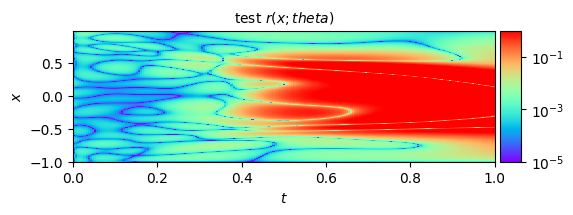

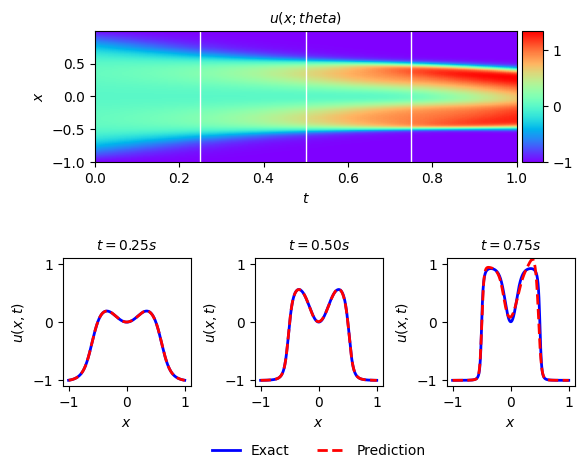

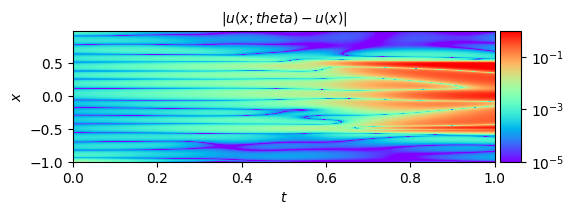

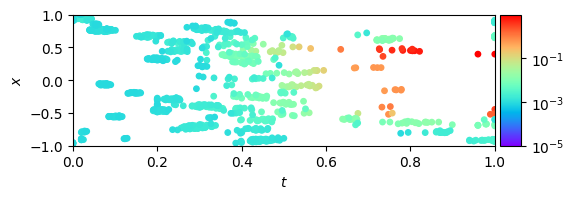

k= 3
1000 tensor(0.0040, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(9.3138e-05, device='cuda:0', grad_fn=<AddBackward0>)
17000 te

126000 tensor(3.3952e-06, device='cuda:0', grad_fn=<AddBackward0>)
127000 tensor(3.3935e-06, device='cuda:0', grad_fn=<AddBackward0>)
128000 tensor(3.3122e-06, device='cuda:0', grad_fn=<AddBackward0>)
129000 tensor(3.3288e-06, device='cuda:0', grad_fn=<AddBackward0>)
130000 tensor(3.2487e-06, device='cuda:0', grad_fn=<AddBackward0>)
131000 tensor(3.2256e-06, device='cuda:0', grad_fn=<AddBackward0>)
132000 tensor(3.2004e-06, device='cuda:0', grad_fn=<AddBackward0>)
133000 tensor(3.1786e-06, device='cuda:0', grad_fn=<AddBackward0>)
134000 tensor(3.2976e-06, device='cuda:0', grad_fn=<AddBackward0>)
135000 tensor(3.1359e-06, device='cuda:0', grad_fn=<AddBackward0>)
136000 tensor(3.1145e-06, device='cuda:0', grad_fn=<AddBackward0>)
137000 tensor(3.0982e-06, device='cuda:0', grad_fn=<AddBackward0>)
138000 tensor(3.0848e-06, device='cuda:0', grad_fn=<AddBackward0>)
139000 tensor(3.0781e-06, device='cuda:0', grad_fn=<AddBackward0>)
140000 tensor(3.6276e-06, device='cuda:0', grad_fn=<AddBackwar

249000 tensor(1.8887e-06, device='cuda:0', grad_fn=<AddBackward0>)
250000 tensor(1.8850e-06, device='cuda:0', grad_fn=<AddBackward0>)
251000 tensor(1.8766e-06, device='cuda:0', grad_fn=<AddBackward0>)
252000 tensor(1.8708e-06, device='cuda:0', grad_fn=<AddBackward0>)
253000 tensor(1.8656e-06, device='cuda:0', grad_fn=<AddBackward0>)
254000 tensor(1.8594e-06, device='cuda:0', grad_fn=<AddBackward0>)
255000 tensor(1.9364e-06, device='cuda:0', grad_fn=<AddBackward0>)
256000 tensor(1.8483e-06, device='cuda:0', grad_fn=<AddBackward0>)
257000 tensor(1.8431e-06, device='cuda:0', grad_fn=<AddBackward0>)
258000 tensor(1.8458e-06, device='cuda:0', grad_fn=<AddBackward0>)
259000 tensor(1.8914e-06, device='cuda:0', grad_fn=<AddBackward0>)
260000 tensor(1.8233e-06, device='cuda:0', grad_fn=<AddBackward0>)
261000 tensor(1.8546e-06, device='cuda:0', grad_fn=<AddBackward0>)
262000 tensor(1.8660e-06, device='cuda:0', grad_fn=<AddBackward0>)
263000 tensor(1.8059e-06, device='cuda:0', grad_fn=<AddBackwar

372000 tensor(1.3746e-06, device='cuda:0', grad_fn=<AddBackward0>)
373000 tensor(2.0181e-06, device='cuda:0', grad_fn=<AddBackward0>)
374000 tensor(1.3688e-06, device='cuda:0', grad_fn=<AddBackward0>)
375000 tensor(1.3687e-06, device='cuda:0', grad_fn=<AddBackward0>)
376000 tensor(1.3628e-06, device='cuda:0', grad_fn=<AddBackward0>)
377000 tensor(1.3597e-06, device='cuda:0', grad_fn=<AddBackward0>)
378000 tensor(1.3570e-06, device='cuda:0', grad_fn=<AddBackward0>)
379000 tensor(1.3538e-06, device='cuda:0', grad_fn=<AddBackward0>)
380000 tensor(1.3509e-06, device='cuda:0', grad_fn=<AddBackward0>)
381000 tensor(1.3482e-06, device='cuda:0', grad_fn=<AddBackward0>)
382000 tensor(1.3453e-06, device='cuda:0', grad_fn=<AddBackward0>)
383000 tensor(1.3426e-06, device='cuda:0', grad_fn=<AddBackward0>)
384000 tensor(1.3398e-06, device='cuda:0', grad_fn=<AddBackward0>)
385000 tensor(1.3370e-06, device='cuda:0', grad_fn=<AddBackward0>)
386000 tensor(1.3343e-06, device='cuda:0', grad_fn=<AddBackwar

495000 tensor(1.0855e-06, device='cuda:0', grad_fn=<AddBackward0>)
496000 tensor(1.0835e-06, device='cuda:0', grad_fn=<AddBackward0>)
497000 tensor(1.0816e-06, device='cuda:0', grad_fn=<AddBackward0>)
498000 tensor(1.0798e-06, device='cuda:0', grad_fn=<AddBackward0>)
499000 tensor(1.0780e-06, device='cuda:0', grad_fn=<AddBackward0>)
500000 tensor(1.0761e-06, device='cuda:0', grad_fn=<AddBackward0>)
501000 tensor(1.0743e-06, device='cuda:0', grad_fn=<AddBackward0>)
502000 tensor(1.0724e-06, device='cuda:0', grad_fn=<AddBackward0>)
503000 tensor(1.0706e-06, device='cuda:0', grad_fn=<AddBackward0>)
504000 tensor(1.0688e-06, device='cuda:0', grad_fn=<AddBackward0>)
505000 tensor(1.0670e-06, device='cuda:0', grad_fn=<AddBackward0>)
506000 tensor(1.0652e-06, device='cuda:0', grad_fn=<AddBackward0>)
507000 tensor(1.0636e-06, device='cuda:0', grad_fn=<AddBackward0>)
508000 tensor(1.0618e-06, device='cuda:0', grad_fn=<AddBackward0>)
509000 tensor(1.0601e-06, device='cuda:0', grad_fn=<AddBackwar

618000 tensor(8.9655e-07, device='cuda:0', grad_fn=<AddBackward0>)
619000 tensor(8.9534e-07, device='cuda:0', grad_fn=<AddBackward0>)
620000 tensor(8.9399e-07, device='cuda:0', grad_fn=<AddBackward0>)
621000 tensor(8.9273e-07, device='cuda:0', grad_fn=<AddBackward0>)
622000 tensor(8.9132e-07, device='cuda:0', grad_fn=<AddBackward0>)
623000 tensor(8.9019e-07, device='cuda:0', grad_fn=<AddBackward0>)
624000 tensor(8.8896e-07, device='cuda:0', grad_fn=<AddBackward0>)
625000 tensor(8.8776e-07, device='cuda:0', grad_fn=<AddBackward0>)
626000 tensor(8.8659e-07, device='cuda:0', grad_fn=<AddBackward0>)
627000 tensor(8.8528e-07, device='cuda:0', grad_fn=<AddBackward0>)
628000 tensor(8.8415e-07, device='cuda:0', grad_fn=<AddBackward0>)
629000 tensor(8.8282e-07, device='cuda:0', grad_fn=<AddBackward0>)
630000 tensor(9.3693e-07, device='cuda:0', grad_fn=<AddBackward0>)
631000 tensor(8.8038e-07, device='cuda:0', grad_fn=<AddBackward0>)
632000 tensor(8.7922e-07, device='cuda:0', grad_fn=<AddBackwar

741000 tensor(7.6492e-07, device='cuda:0', grad_fn=<AddBackward0>)
742000 tensor(7.6398e-07, device='cuda:0', grad_fn=<AddBackward0>)
743000 tensor(7.6306e-07, device='cuda:0', grad_fn=<AddBackward0>)
744000 tensor(7.6229e-07, device='cuda:0', grad_fn=<AddBackward0>)
745000 tensor(7.6134e-07, device='cuda:0', grad_fn=<AddBackward0>)
746000 tensor(7.6059e-07, device='cuda:0', grad_fn=<AddBackward0>)
747000 tensor(7.5964e-07, device='cuda:0', grad_fn=<AddBackward0>)
748000 tensor(7.5872e-07, device='cuda:0', grad_fn=<AddBackward0>)
749000 tensor(7.5787e-07, device='cuda:0', grad_fn=<AddBackward0>)
750000 tensor(7.5695e-07, device='cuda:0', grad_fn=<AddBackward0>)
751000 tensor(7.5603e-07, device='cuda:0', grad_fn=<AddBackward0>)
752000 tensor(8.2347e-07, device='cuda:0', grad_fn=<AddBackward0>)
753000 tensor(7.5418e-07, device='cuda:0', grad_fn=<AddBackward0>)
754000 tensor(7.5332e-07, device='cuda:0', grad_fn=<AddBackward0>)
755000 tensor(7.5238e-07, device='cuda:0', grad_fn=<AddBackwar

864000 tensor(6.7130e-07, device='cuda:0', grad_fn=<AddBackward0>)
865000 tensor(6.7072e-07, device='cuda:0', grad_fn=<AddBackward0>)
866000 tensor(6.6993e-07, device='cuda:0', grad_fn=<AddBackward0>)
867000 tensor(6.6931e-07, device='cuda:0', grad_fn=<AddBackward0>)
868000 tensor(6.6862e-07, device='cuda:0', grad_fn=<AddBackward0>)
869000 tensor(6.6797e-07, device='cuda:0', grad_fn=<AddBackward0>)
870000 tensor(6.6743e-07, device='cuda:0', grad_fn=<AddBackward0>)
871000 tensor(6.6688e-07, device='cuda:0', grad_fn=<AddBackward0>)
872000 tensor(6.6621e-07, device='cuda:0', grad_fn=<AddBackward0>)
873000 tensor(6.6567e-07, device='cuda:0', grad_fn=<AddBackward0>)
874000 tensor(6.6499e-07, device='cuda:0', grad_fn=<AddBackward0>)
875000 tensor(6.6433e-07, device='cuda:0', grad_fn=<AddBackward0>)
876000 tensor(6.6369e-07, device='cuda:0', grad_fn=<AddBackward0>)
877000 tensor(6.6303e-07, device='cuda:0', grad_fn=<AddBackward0>)
878000 tensor(6.6241e-07, device='cuda:0', grad_fn=<AddBackwar

987000 tensor(6.0206e-07, device='cuda:0', grad_fn=<AddBackward0>)
988000 tensor(6.0160e-07, device='cuda:0', grad_fn=<AddBackward0>)
989000 tensor(6.0123e-07, device='cuda:0', grad_fn=<AddBackward0>)
990000 tensor(6.0070e-07, device='cuda:0', grad_fn=<AddBackward0>)
991000 tensor(6.0029e-07, device='cuda:0', grad_fn=<AddBackward0>)
992000 tensor(5.9977e-07, device='cuda:0', grad_fn=<AddBackward0>)
993000 tensor(5.9921e-07, device='cuda:0', grad_fn=<AddBackward0>)
994000 tensor(5.9881e-07, device='cuda:0', grad_fn=<AddBackward0>)
995000 tensor(5.9825e-07, device='cuda:0', grad_fn=<AddBackward0>)
996000 tensor(5.9770e-07, device='cuda:0', grad_fn=<AddBackward0>)
997000 tensor(5.9716e-07, device='cuda:0', grad_fn=<AddBackward0>)
998000 tensor(7.8647e-07, device='cuda:0', grad_fn=<AddBackward0>)
999000 tensor(5.9619e-07, device='cuda:0', grad_fn=<AddBackward0>)
1000000 tensor(5.9568e-07, device='cuda:0', grad_fn=<AddBackward0>)
Test RMSE: 0.03886


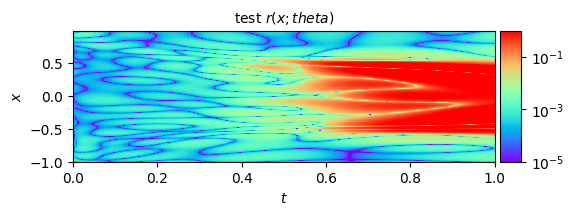

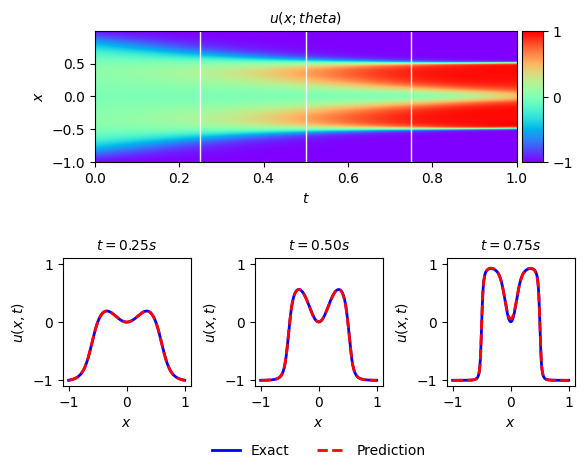

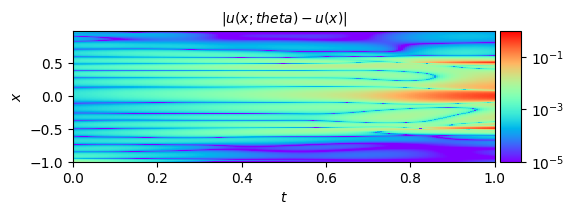

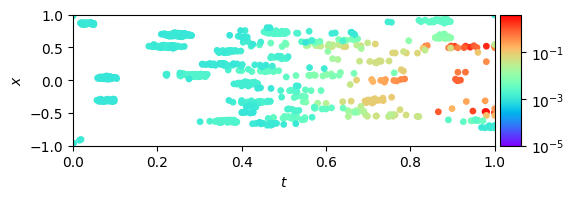

k= 4
1000 tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(9.8091e-05, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(8.2038e-05, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(6.9227e-05, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(5.8750e-05, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(5.0368e-05, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(4.3749e-05, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(3.8463e-05, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(3.3621e-05, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(2.9526e-05, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(2.5898e-05, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(2.2722e-05, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(1.9459e-05, devic

126000 tensor(2.5313e-06, device='cuda:0', grad_fn=<AddBackward0>)
127000 tensor(2.5184e-06, device='cuda:0', grad_fn=<AddBackward0>)
128000 tensor(2.5054e-06, device='cuda:0', grad_fn=<AddBackward0>)
129000 tensor(2.4926e-06, device='cuda:0', grad_fn=<AddBackward0>)
130000 tensor(2.4835e-06, device='cuda:0', grad_fn=<AddBackward0>)
131000 tensor(2.4674e-06, device='cuda:0', grad_fn=<AddBackward0>)
132000 tensor(2.4549e-06, device='cuda:0', grad_fn=<AddBackward0>)
133000 tensor(2.4429e-06, device='cuda:0', grad_fn=<AddBackward0>)
134000 tensor(2.4307e-06, device='cuda:0', grad_fn=<AddBackward0>)
135000 tensor(2.4189e-06, device='cuda:0', grad_fn=<AddBackward0>)
136000 tensor(2.4076e-06, device='cuda:0', grad_fn=<AddBackward0>)
137000 tensor(2.3958e-06, device='cuda:0', grad_fn=<AddBackward0>)
138000 tensor(4.3501e-06, device='cuda:0', grad_fn=<AddBackward0>)
139000 tensor(2.5697e-06, device='cuda:0', grad_fn=<AddBackward0>)
140000 tensor(2.3614e-06, device='cuda:0', grad_fn=<AddBackwar

249000 tensor(1.6176e-06, device='cuda:0', grad_fn=<AddBackward0>)
250000 tensor(1.6133e-06, device='cuda:0', grad_fn=<AddBackward0>)
251000 tensor(1.6093e-06, device='cuda:0', grad_fn=<AddBackward0>)
252000 tensor(1.6048e-06, device='cuda:0', grad_fn=<AddBackward0>)
253000 tensor(1.6009e-06, device='cuda:0', grad_fn=<AddBackward0>)
254000 tensor(1.5968e-06, device='cuda:0', grad_fn=<AddBackward0>)
255000 tensor(1.5989e-06, device='cuda:0', grad_fn=<AddBackward0>)
256000 tensor(1.5882e-06, device='cuda:0', grad_fn=<AddBackward0>)
257000 tensor(1.5841e-06, device='cuda:0', grad_fn=<AddBackward0>)
258000 tensor(2.2138e-06, device='cuda:0', grad_fn=<AddBackward0>)
259000 tensor(1.5758e-06, device='cuda:0', grad_fn=<AddBackward0>)
260000 tensor(1.5720e-06, device='cuda:0', grad_fn=<AddBackward0>)
261000 tensor(1.5679e-06, device='cuda:0', grad_fn=<AddBackward0>)
262000 tensor(1.8710e-06, device='cuda:0', grad_fn=<AddBackward0>)
263000 tensor(1.5599e-06, device='cuda:0', grad_fn=<AddBackwar

372000 tensor(1.2338e-06, device='cuda:0', grad_fn=<AddBackward0>)
373000 tensor(1.2318e-06, device='cuda:0', grad_fn=<AddBackward0>)
374000 tensor(5.8816e-06, device='cuda:0', grad_fn=<AddBackward0>)
375000 tensor(1.2869e-06, device='cuda:0', grad_fn=<AddBackward0>)
376000 tensor(1.2251e-06, device='cuda:0', grad_fn=<AddBackward0>)
377000 tensor(1.2229e-06, device='cuda:0', grad_fn=<AddBackward0>)
378000 tensor(1.2205e-06, device='cuda:0', grad_fn=<AddBackward0>)
379000 tensor(1.2181e-06, device='cuda:0', grad_fn=<AddBackward0>)
380000 tensor(1.2161e-06, device='cuda:0', grad_fn=<AddBackward0>)
381000 tensor(1.2141e-06, device='cuda:0', grad_fn=<AddBackward0>)
382000 tensor(1.2121e-06, device='cuda:0', grad_fn=<AddBackward0>)
383000 tensor(1.2099e-06, device='cuda:0', grad_fn=<AddBackward0>)
384000 tensor(1.2078e-06, device='cuda:0', grad_fn=<AddBackward0>)
385000 tensor(1.2057e-06, device='cuda:0', grad_fn=<AddBackward0>)
386000 tensor(1.2035e-06, device='cuda:0', grad_fn=<AddBackwar

495000 tensor(1.0158e-06, device='cuda:0', grad_fn=<AddBackward0>)
496000 tensor(1.0224e-06, device='cuda:0', grad_fn=<AddBackward0>)
497000 tensor(1.0133e-06, device='cuda:0', grad_fn=<AddBackward0>)
498000 tensor(1.0117e-06, device='cuda:0', grad_fn=<AddBackward0>)
499000 tensor(1.0104e-06, device='cuda:0', grad_fn=<AddBackward0>)
500000 tensor(1.0092e-06, device='cuda:0', grad_fn=<AddBackward0>)
501000 tensor(1.0077e-06, device='cuda:0', grad_fn=<AddBackward0>)
502000 tensor(1.0064e-06, device='cuda:0', grad_fn=<AddBackward0>)
503000 tensor(1.0052e-06, device='cuda:0', grad_fn=<AddBackward0>)
504000 tensor(1.0038e-06, device='cuda:0', grad_fn=<AddBackward0>)
505000 tensor(1.0025e-06, device='cuda:0', grad_fn=<AddBackward0>)
506000 tensor(1.0014e-06, device='cuda:0', grad_fn=<AddBackward0>)
507000 tensor(9.9993e-07, device='cuda:0', grad_fn=<AddBackward0>)
508000 tensor(9.9878e-07, device='cuda:0', grad_fn=<AddBackward0>)
509000 tensor(9.9744e-07, device='cuda:0', grad_fn=<AddBackwar

618000 tensor(8.7346e-07, device='cuda:0', grad_fn=<AddBackward0>)
619000 tensor(8.7259e-07, device='cuda:0', grad_fn=<AddBackward0>)
620000 tensor(8.7136e-07, device='cuda:0', grad_fn=<AddBackward0>)
621000 tensor(8.7056e-07, device='cuda:0', grad_fn=<AddBackward0>)
622000 tensor(8.6953e-07, device='cuda:0', grad_fn=<AddBackward0>)
623000 tensor(8.6850e-07, device='cuda:0', grad_fn=<AddBackward0>)
624000 tensor(8.6749e-07, device='cuda:0', grad_fn=<AddBackward0>)
625000 tensor(7.2681e-06, device='cuda:0', grad_fn=<AddBackward0>)
626000 tensor(8.6574e-07, device='cuda:0', grad_fn=<AddBackward0>)
627000 tensor(8.6483e-07, device='cuda:0', grad_fn=<AddBackward0>)
628000 tensor(8.6381e-07, device='cuda:0', grad_fn=<AddBackward0>)
629000 tensor(8.6302e-07, device='cuda:0', grad_fn=<AddBackward0>)
630000 tensor(8.6194e-07, device='cuda:0', grad_fn=<AddBackward0>)
631000 tensor(8.6101e-07, device='cuda:0', grad_fn=<AddBackward0>)
632000 tensor(8.5995e-07, device='cuda:0', grad_fn=<AddBackwar

741000 tensor(7.7201e-07, device='cuda:0', grad_fn=<AddBackward0>)
742000 tensor(7.7119e-07, device='cuda:0', grad_fn=<AddBackward0>)
743000 tensor(1.3700e-06, device='cuda:0', grad_fn=<AddBackward0>)
744000 tensor(7.6983e-07, device='cuda:0', grad_fn=<AddBackward0>)
745000 tensor(7.6906e-07, device='cuda:0', grad_fn=<AddBackward0>)
746000 tensor(7.7392e-07, device='cuda:0', grad_fn=<AddBackward0>)
747000 tensor(7.6782e-07, device='cuda:0', grad_fn=<AddBackward0>)
748000 tensor(7.6710e-07, device='cuda:0', grad_fn=<AddBackward0>)
749000 tensor(1.4441e-06, device='cuda:0', grad_fn=<AddBackward0>)
750000 tensor(7.6578e-07, device='cuda:0', grad_fn=<AddBackward0>)
751000 tensor(7.6504e-07, device='cuda:0', grad_fn=<AddBackward0>)
752000 tensor(7.7121e-07, device='cuda:0', grad_fn=<AddBackward0>)
753000 tensor(7.6365e-07, device='cuda:0', grad_fn=<AddBackward0>)
754000 tensor(7.6289e-07, device='cuda:0', grad_fn=<AddBackward0>)
755000 tensor(7.6214e-07, device='cuda:0', grad_fn=<AddBackwar

864000 tensor(6.9809e-07, device='cuda:0', grad_fn=<AddBackward0>)
865000 tensor(6.9769e-07, device='cuda:0', grad_fn=<AddBackward0>)
866000 tensor(6.9696e-07, device='cuda:0', grad_fn=<AddBackward0>)
867000 tensor(6.9662e-07, device='cuda:0', grad_fn=<AddBackward0>)
868000 tensor(6.9616e-07, device='cuda:0', grad_fn=<AddBackward0>)
869000 tensor(6.9575e-07, device='cuda:0', grad_fn=<AddBackward0>)
870000 tensor(6.9501e-07, device='cuda:0', grad_fn=<AddBackward0>)
871000 tensor(6.9469e-07, device='cuda:0', grad_fn=<AddBackward0>)
872000 tensor(6.9422e-07, device='cuda:0', grad_fn=<AddBackward0>)
873000 tensor(6.9379e-07, device='cuda:0', grad_fn=<AddBackward0>)
874000 tensor(6.9313e-07, device='cuda:0', grad_fn=<AddBackward0>)
875000 tensor(6.9275e-07, device='cuda:0', grad_fn=<AddBackward0>)
876000 tensor(6.9225e-07, device='cuda:0', grad_fn=<AddBackward0>)
877000 tensor(6.9167e-07, device='cuda:0', grad_fn=<AddBackward0>)
878000 tensor(6.9128e-07, device='cuda:0', grad_fn=<AddBackwar

987000 tensor(6.4184e-07, device='cuda:0', grad_fn=<AddBackward0>)
988000 tensor(6.4145e-07, device='cuda:0', grad_fn=<AddBackward0>)
989000 tensor(6.4107e-07, device='cuda:0', grad_fn=<AddBackward0>)
990000 tensor(6.4056e-07, device='cuda:0', grad_fn=<AddBackward0>)
991000 tensor(6.4025e-07, device='cuda:0', grad_fn=<AddBackward0>)
992000 tensor(6.3979e-07, device='cuda:0', grad_fn=<AddBackward0>)
993000 tensor(6.3932e-07, device='cuda:0', grad_fn=<AddBackward0>)
994000 tensor(6.3907e-07, device='cuda:0', grad_fn=<AddBackward0>)
995000 tensor(6.3866e-07, device='cuda:0', grad_fn=<AddBackward0>)
996000 tensor(6.3819e-07, device='cuda:0', grad_fn=<AddBackward0>)
997000 tensor(6.3792e-07, device='cuda:0', grad_fn=<AddBackward0>)
998000 tensor(8.2043e-07, device='cuda:0', grad_fn=<AddBackward0>)
999000 tensor(6.3711e-07, device='cuda:0', grad_fn=<AddBackward0>)
1000000 tensor(6.3670e-07, device='cuda:0', grad_fn=<AddBackward0>)
Test RMSE: 0.02477


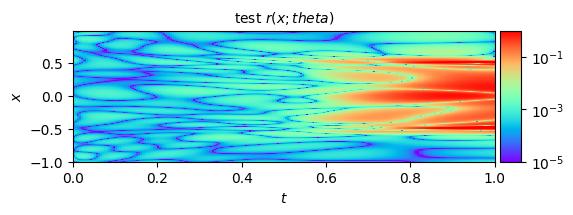

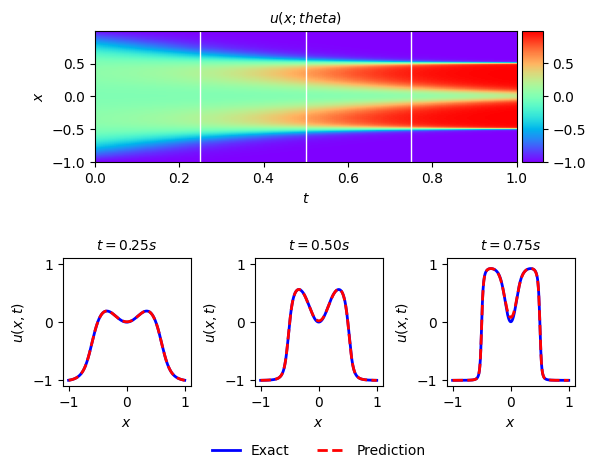

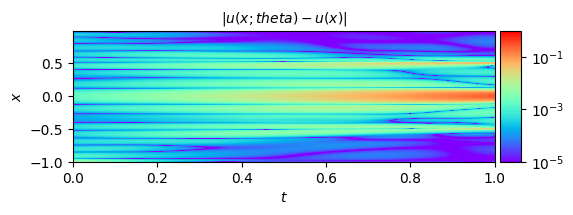

In [5]:
''' k=2 '''
for k in range(2,5):
    x_train = np.vstack([x_train, x_adv])
    x_adv = generate_attack_samples(PINN, device, x_train, N0)
    print("k=", k)
    retrain(PINN, x_train, x_adv, x_boundary, u_boundary, x_test, u_test, U_gt)

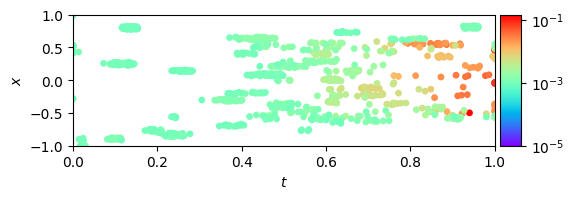

k= 5
1000 tensor(6.9261e-06, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(4.8832e-06, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(3.9984e-06, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(3.4992e-06, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(3.1947e-06, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(2.9811e-06, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(2.8343e-06, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(2.7230e-06, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(2.6552e-06, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(2.4760e-06, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(2.3979e-06, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(2.6201e-06, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(2.2454e-06, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(2.1847e-06, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(2.1325e-06, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(2

125000 tensor(1.1747e-06, device='cuda:0', grad_fn=<AddBackward0>)
126000 tensor(1.1711e-06, device='cuda:0', grad_fn=<AddBackward0>)
127000 tensor(1.1684e-06, device='cuda:0', grad_fn=<AddBackward0>)
128000 tensor(1.1658e-06, device='cuda:0', grad_fn=<AddBackward0>)
129000 tensor(1.1632e-06, device='cuda:0', grad_fn=<AddBackward0>)
130000 tensor(1.1606e-06, device='cuda:0', grad_fn=<AddBackward0>)
131000 tensor(1.1617e-06, device='cuda:0', grad_fn=<AddBackward0>)
132000 tensor(1.1554e-06, device='cuda:0', grad_fn=<AddBackward0>)
133000 tensor(1.1668e-06, device='cuda:0', grad_fn=<AddBackward0>)
134000 tensor(1.1505e-06, device='cuda:0', grad_fn=<AddBackward0>)
135000 tensor(1.1487e-06, device='cuda:0', grad_fn=<AddBackward0>)
136000 tensor(1.1457e-06, device='cuda:0', grad_fn=<AddBackward0>)
137000 tensor(1.1432e-06, device='cuda:0', grad_fn=<AddBackward0>)
138000 tensor(1.1408e-06, device='cuda:0', grad_fn=<AddBackward0>)
139000 tensor(1.1384e-06, device='cuda:0', grad_fn=<AddBackwar

248000 tensor(9.5317e-07, device='cuda:0', grad_fn=<AddBackward0>)
249000 tensor(9.5170e-07, device='cuda:0', grad_fn=<AddBackward0>)
250000 tensor(9.5038e-07, device='cuda:0', grad_fn=<AddBackward0>)
251000 tensor(9.4889e-07, device='cuda:0', grad_fn=<AddBackward0>)
252000 tensor(9.4776e-07, device='cuda:0', grad_fn=<AddBackward0>)
253000 tensor(9.4651e-07, device='cuda:0', grad_fn=<AddBackward0>)
254000 tensor(9.4546e-07, device='cuda:0', grad_fn=<AddBackward0>)
255000 tensor(9.4427e-07, device='cuda:0', grad_fn=<AddBackward0>)
256000 tensor(9.4293e-07, device='cuda:0', grad_fn=<AddBackward0>)
257000 tensor(9.4173e-07, device='cuda:0', grad_fn=<AddBackward0>)
258000 tensor(9.4084e-07, device='cuda:0', grad_fn=<AddBackward0>)
259000 tensor(9.3917e-07, device='cuda:0', grad_fn=<AddBackward0>)
260000 tensor(9.3805e-07, device='cuda:0', grad_fn=<AddBackward0>)
261000 tensor(9.3705e-07, device='cuda:0', grad_fn=<AddBackward0>)
262000 tensor(9.3564e-07, device='cuda:0', grad_fn=<AddBackwar

371000 tensor(8.2973e-07, device='cuda:0', grad_fn=<AddBackward0>)
372000 tensor(8.2889e-07, device='cuda:0', grad_fn=<AddBackward0>)
373000 tensor(8.2802e-07, device='cuda:0', grad_fn=<AddBackward0>)
374000 tensor(8.2737e-07, device='cuda:0', grad_fn=<AddBackward0>)
375000 tensor(8.2656e-07, device='cuda:0', grad_fn=<AddBackward0>)
376000 tensor(8.5732e-07, device='cuda:0', grad_fn=<AddBackward0>)
377000 tensor(8.2505e-07, device='cuda:0', grad_fn=<AddBackward0>)
378000 tensor(8.2425e-07, device='cuda:0', grad_fn=<AddBackward0>)
379000 tensor(8.2342e-07, device='cuda:0', grad_fn=<AddBackward0>)
380000 tensor(8.9771e-07, device='cuda:0', grad_fn=<AddBackward0>)
381000 tensor(8.2178e-07, device='cuda:0', grad_fn=<AddBackward0>)
382000 tensor(8.2118e-07, device='cuda:0', grad_fn=<AddBackward0>)
383000 tensor(8.2033e-07, device='cuda:0', grad_fn=<AddBackward0>)
384000 tensor(8.1942e-07, device='cuda:0', grad_fn=<AddBackward0>)
385000 tensor(2.4825e-06, device='cuda:0', grad_fn=<AddBackwar

494000 tensor(7.4829e-07, device='cuda:0', grad_fn=<AddBackward0>)
495000 tensor(7.4791e-07, device='cuda:0', grad_fn=<AddBackward0>)
496000 tensor(7.4732e-07, device='cuda:0', grad_fn=<AddBackward0>)
497000 tensor(7.4671e-07, device='cuda:0', grad_fn=<AddBackward0>)
498000 tensor(7.4630e-07, device='cuda:0', grad_fn=<AddBackward0>)
499000 tensor(7.4574e-07, device='cuda:0', grad_fn=<AddBackward0>)
500000 tensor(7.4507e-07, device='cuda:0', grad_fn=<AddBackward0>)
501000 tensor(7.4471e-07, device='cuda:0', grad_fn=<AddBackward0>)
502000 tensor(7.4417e-07, device='cuda:0', grad_fn=<AddBackward0>)
503000 tensor(7.4354e-07, device='cuda:0', grad_fn=<AddBackward0>)
504000 tensor(7.4299e-07, device='cuda:0', grad_fn=<AddBackward0>)
505000 tensor(7.4247e-07, device='cuda:0', grad_fn=<AddBackward0>)
506000 tensor(7.4203e-07, device='cuda:0', grad_fn=<AddBackward0>)
507000 tensor(7.4147e-07, device='cuda:0', grad_fn=<AddBackward0>)
508000 tensor(7.4081e-07, device='cuda:0', grad_fn=<AddBackwar

617000 tensor(6.9069e-07, device='cuda:0', grad_fn=<AddBackward0>)
618000 tensor(6.9037e-07, device='cuda:0', grad_fn=<AddBackward0>)
619000 tensor(6.8994e-07, device='cuda:0', grad_fn=<AddBackward0>)
620000 tensor(6.8954e-07, device='cuda:0', grad_fn=<AddBackward0>)
621000 tensor(6.8933e-07, device='cuda:0', grad_fn=<AddBackward0>)
622000 tensor(6.8887e-07, device='cuda:0', grad_fn=<AddBackward0>)
623000 tensor(7.1154e-07, device='cuda:0', grad_fn=<AddBackward0>)
624000 tensor(6.8809e-07, device='cuda:0', grad_fn=<AddBackward0>)
625000 tensor(6.8764e-07, device='cuda:0', grad_fn=<AddBackward0>)
626000 tensor(6.8712e-07, device='cuda:0', grad_fn=<AddBackward0>)
627000 tensor(6.8680e-07, device='cuda:0', grad_fn=<AddBackward0>)
628000 tensor(1.9031e-06, device='cuda:0', grad_fn=<AddBackward0>)
629000 tensor(6.8599e-07, device='cuda:0', grad_fn=<AddBackward0>)
630000 tensor(6.8563e-07, device='cuda:0', grad_fn=<AddBackward0>)
631000 tensor(6.8527e-07, device='cuda:0', grad_fn=<AddBackwar

740000 tensor(6.4668e-07, device='cuda:0', grad_fn=<AddBackward0>)
741000 tensor(6.4640e-07, device='cuda:0', grad_fn=<AddBackward0>)
742000 tensor(6.4609e-07, device='cuda:0', grad_fn=<AddBackward0>)
743000 tensor(6.4581e-07, device='cuda:0', grad_fn=<AddBackward0>)
744000 tensor(6.4555e-07, device='cuda:0', grad_fn=<AddBackward0>)
745000 tensor(6.4523e-07, device='cuda:0', grad_fn=<AddBackward0>)
746000 tensor(6.4482e-07, device='cuda:0', grad_fn=<AddBackward0>)
747000 tensor(6.4456e-07, device='cuda:0', grad_fn=<AddBackward0>)
748000 tensor(6.4422e-07, device='cuda:0', grad_fn=<AddBackward0>)
749000 tensor(6.4388e-07, device='cuda:0', grad_fn=<AddBackward0>)
750000 tensor(6.4356e-07, device='cuda:0', grad_fn=<AddBackward0>)
751000 tensor(6.4334e-07, device='cuda:0', grad_fn=<AddBackward0>)
752000 tensor(6.4303e-07, device='cuda:0', grad_fn=<AddBackward0>)
753000 tensor(6.4269e-07, device='cuda:0', grad_fn=<AddBackward0>)
754000 tensor(6.4244e-07, device='cuda:0', grad_fn=<AddBackwar

863000 tensor(6.1193e-07, device='cuda:0', grad_fn=<AddBackward0>)
864000 tensor(6.1174e-07, device='cuda:0', grad_fn=<AddBackward0>)
865000 tensor(6.1152e-07, device='cuda:0', grad_fn=<AddBackward0>)
866000 tensor(6.1127e-07, device='cuda:0', grad_fn=<AddBackward0>)
867000 tensor(6.1096e-07, device='cuda:0', grad_fn=<AddBackward0>)
868000 tensor(6.1081e-07, device='cuda:0', grad_fn=<AddBackward0>)
869000 tensor(6.1057e-07, device='cuda:0', grad_fn=<AddBackward0>)
870000 tensor(6.1032e-07, device='cuda:0', grad_fn=<AddBackward0>)
871000 tensor(6.1010e-07, device='cuda:0', grad_fn=<AddBackward0>)
872000 tensor(6.0986e-07, device='cuda:0', grad_fn=<AddBackward0>)
873000 tensor(6.0959e-07, device='cuda:0', grad_fn=<AddBackward0>)
874000 tensor(6.0930e-07, device='cuda:0', grad_fn=<AddBackward0>)
875000 tensor(6.0908e-07, device='cuda:0', grad_fn=<AddBackward0>)
876000 tensor(6.0877e-07, device='cuda:0', grad_fn=<AddBackward0>)
877000 tensor(1.3276e-05, device='cuda:0', grad_fn=<AddBackwar

986000 tensor(5.8396e-07, device='cuda:0', grad_fn=<AddBackward0>)
987000 tensor(5.8379e-07, device='cuda:0', grad_fn=<AddBackward0>)
988000 tensor(5.8356e-07, device='cuda:0', grad_fn=<AddBackward0>)
989000 tensor(5.8330e-07, device='cuda:0', grad_fn=<AddBackward0>)
990000 tensor(5.8317e-07, device='cuda:0', grad_fn=<AddBackward0>)
991000 tensor(5.8297e-07, device='cuda:0', grad_fn=<AddBackward0>)
992000 tensor(5.8281e-07, device='cuda:0', grad_fn=<AddBackward0>)
993000 tensor(5.8257e-07, device='cuda:0', grad_fn=<AddBackward0>)
994000 tensor(5.8243e-07, device='cuda:0', grad_fn=<AddBackward0>)
995000 tensor(5.8219e-07, device='cuda:0', grad_fn=<AddBackward0>)
996000 tensor(5.8739e-07, device='cuda:0', grad_fn=<AddBackward0>)
997000 tensor(5.8174e-07, device='cuda:0', grad_fn=<AddBackward0>)
998000 tensor(7.3320e-07, device='cuda:0', grad_fn=<AddBackward0>)
999000 tensor(5.8134e-07, device='cuda:0', grad_fn=<AddBackward0>)
1000000 tensor(5.8110e-07, device='cuda:0', grad_fn=<AddBackwa

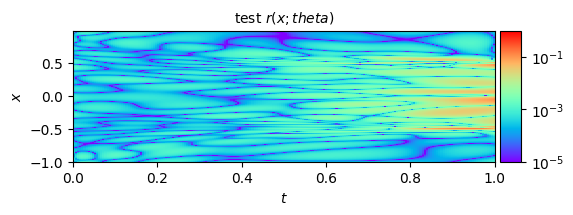

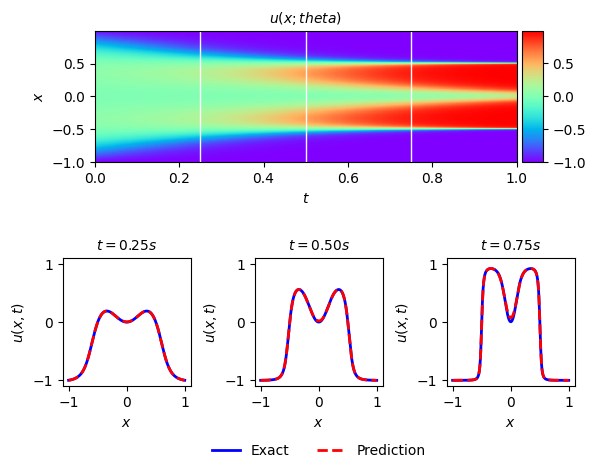

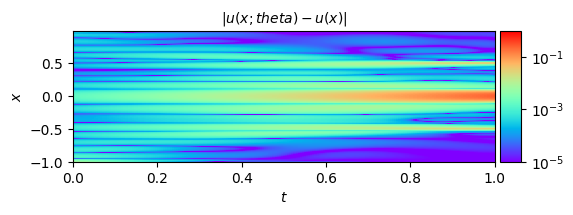

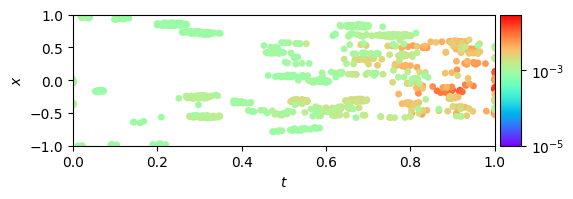

k= 6
1000 tensor(1.6234e-06, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(1.5117e-06, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(1.4441e-06, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(1.3981e-06, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(1.7146e-06, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(1.3343e-06, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(1.3232e-06, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(1.2888e-06, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(1.2709e-06, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(1.2552e-06, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(1.2411e-06, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(1.2449e-06, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(1.2156e-06, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(1.2049e-06, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(1.1944e-06, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(1

125000 tensor(8.9003e-07, device='cuda:0', grad_fn=<AddBackward0>)
126000 tensor(8.8870e-07, device='cuda:0', grad_fn=<AddBackward0>)
127000 tensor(8.8726e-07, device='cuda:0', grad_fn=<AddBackward0>)
128000 tensor(8.8627e-07, device='cuda:0', grad_fn=<AddBackward0>)
129000 tensor(8.8493e-07, device='cuda:0', grad_fn=<AddBackward0>)
130000 tensor(8.8378e-07, device='cuda:0', grad_fn=<AddBackward0>)
131000 tensor(8.8256e-07, device='cuda:0', grad_fn=<AddBackward0>)
132000 tensor(8.8124e-07, device='cuda:0', grad_fn=<AddBackward0>)
133000 tensor(8.8028e-07, device='cuda:0', grad_fn=<AddBackward0>)
134000 tensor(8.7896e-07, device='cuda:0', grad_fn=<AddBackward0>)
135000 tensor(8.7773e-07, device='cuda:0', grad_fn=<AddBackward0>)
136000 tensor(8.7659e-07, device='cuda:0', grad_fn=<AddBackward0>)
137000 tensor(8.7533e-07, device='cuda:0', grad_fn=<AddBackward0>)
138000 tensor(8.7433e-07, device='cuda:0', grad_fn=<AddBackward0>)
139000 tensor(8.7302e-07, device='cuda:0', grad_fn=<AddBackwar

248000 tensor(7.9957e-07, device='cuda:0', grad_fn=<AddBackward0>)
249000 tensor(7.8044e-07, device='cuda:0', grad_fn=<AddBackward0>)
250000 tensor(7.7987e-07, device='cuda:0', grad_fn=<AddBackward0>)
251000 tensor(7.8184e-07, device='cuda:0', grad_fn=<AddBackward0>)
252000 tensor(7.7843e-07, device='cuda:0', grad_fn=<AddBackward0>)
253000 tensor(7.7790e-07, device='cuda:0', grad_fn=<AddBackward0>)
254000 tensor(7.7720e-07, device='cuda:0', grad_fn=<AddBackward0>)
255000 tensor(7.7650e-07, device='cuda:0', grad_fn=<AddBackward0>)
256000 tensor(7.7591e-07, device='cuda:0', grad_fn=<AddBackward0>)
257000 tensor(7.7524e-07, device='cuda:0', grad_fn=<AddBackward0>)
258000 tensor(7.7453e-07, device='cuda:0', grad_fn=<AddBackward0>)
259000 tensor(7.7395e-07, device='cuda:0', grad_fn=<AddBackward0>)
260000 tensor(7.7325e-07, device='cuda:0', grad_fn=<AddBackward0>)
261000 tensor(7.7256e-07, device='cuda:0', grad_fn=<AddBackward0>)
262000 tensor(7.7202e-07, device='cuda:0', grad_fn=<AddBackwar

371000 tensor(7.1250e-07, device='cuda:0', grad_fn=<AddBackward0>)
372000 tensor(7.1205e-07, device='cuda:0', grad_fn=<AddBackward0>)
373000 tensor(7.1146e-07, device='cuda:0', grad_fn=<AddBackward0>)
374000 tensor(7.1102e-07, device='cuda:0', grad_fn=<AddBackward0>)
375000 tensor(7.1068e-07, device='cuda:0', grad_fn=<AddBackward0>)
376000 tensor(7.1008e-07, device='cuda:0', grad_fn=<AddBackward0>)
377000 tensor(7.0950e-07, device='cuda:0', grad_fn=<AddBackward0>)
378000 tensor(7.0923e-07, device='cuda:0', grad_fn=<AddBackward0>)
379000 tensor(7.0875e-07, device='cuda:0', grad_fn=<AddBackward0>)
380000 tensor(7.0829e-07, device='cuda:0', grad_fn=<AddBackward0>)
381000 tensor(7.0782e-07, device='cuda:0', grad_fn=<AddBackward0>)
382000 tensor(7.0747e-07, device='cuda:0', grad_fn=<AddBackward0>)
383000 tensor(7.0691e-07, device='cuda:0', grad_fn=<AddBackward0>)
384000 tensor(7.0634e-07, device='cuda:0', grad_fn=<AddBackward0>)
385000 tensor(7.0603e-07, device='cuda:0', grad_fn=<AddBackwar

494000 tensor(6.6188e-07, device='cuda:0', grad_fn=<AddBackward0>)
495000 tensor(6.6146e-07, device='cuda:0', grad_fn=<AddBackward0>)
496000 tensor(6.6123e-07, device='cuda:0', grad_fn=<AddBackward0>)
497000 tensor(6.6085e-07, device='cuda:0', grad_fn=<AddBackward0>)
498000 tensor(6.6049e-07, device='cuda:0', grad_fn=<AddBackward0>)
499000 tensor(6.6003e-07, device='cuda:0', grad_fn=<AddBackward0>)
500000 tensor(6.5975e-07, device='cuda:0', grad_fn=<AddBackward0>)
501000 tensor(6.5929e-07, device='cuda:0', grad_fn=<AddBackward0>)
502000 tensor(8.4746e-07, device='cuda:0', grad_fn=<AddBackward0>)
503000 tensor(6.5862e-07, device='cuda:0', grad_fn=<AddBackward0>)
504000 tensor(7.5789e-07, device='cuda:0', grad_fn=<AddBackward0>)
505000 tensor(6.5777e-07, device='cuda:0', grad_fn=<AddBackward0>)
506000 tensor(6.5748e-07, device='cuda:0', grad_fn=<AddBackward0>)
507000 tensor(6.5707e-07, device='cuda:0', grad_fn=<AddBackward0>)
508000 tensor(6.5671e-07, device='cuda:0', grad_fn=<AddBackwar

617000 tensor(6.2194e-07, device='cuda:0', grad_fn=<AddBackward0>)
618000 tensor(6.2162e-07, device='cuda:0', grad_fn=<AddBackward0>)
619000 tensor(6.2141e-07, device='cuda:0', grad_fn=<AddBackward0>)
620000 tensor(6.2110e-07, device='cuda:0', grad_fn=<AddBackward0>)
621000 tensor(6.2076e-07, device='cuda:0', grad_fn=<AddBackward0>)
622000 tensor(6.2056e-07, device='cuda:0', grad_fn=<AddBackward0>)
623000 tensor(6.2032e-07, device='cuda:0', grad_fn=<AddBackward0>)
624000 tensor(6.2001e-07, device='cuda:0', grad_fn=<AddBackward0>)
625000 tensor(6.1967e-07, device='cuda:0', grad_fn=<AddBackward0>)
626000 tensor(6.1943e-07, device='cuda:0', grad_fn=<AddBackward0>)
627000 tensor(6.1907e-07, device='cuda:0', grad_fn=<AddBackward0>)
628000 tensor(6.1876e-07, device='cuda:0', grad_fn=<AddBackward0>)
629000 tensor(6.1858e-07, device='cuda:0', grad_fn=<AddBackward0>)
630000 tensor(6.1817e-07, device='cuda:0', grad_fn=<AddBackward0>)
631000 tensor(6.1783e-07, device='cuda:0', grad_fn=<AddBackwar

740000 tensor(5.8860e-07, device='cuda:0', grad_fn=<AddBackward0>)
741000 tensor(5.8849e-07, device='cuda:0', grad_fn=<AddBackward0>)
742000 tensor(5.8818e-07, device='cuda:0', grad_fn=<AddBackward0>)
743000 tensor(5.8791e-07, device='cuda:0', grad_fn=<AddBackward0>)
744000 tensor(5.8768e-07, device='cuda:0', grad_fn=<AddBackward0>)
745000 tensor(5.8750e-07, device='cuda:0', grad_fn=<AddBackward0>)
746000 tensor(5.8718e-07, device='cuda:0', grad_fn=<AddBackward0>)
747000 tensor(5.8687e-07, device='cuda:0', grad_fn=<AddBackward0>)
748000 tensor(5.8671e-07, device='cuda:0', grad_fn=<AddBackward0>)
749000 tensor(5.8648e-07, device='cuda:0', grad_fn=<AddBackward0>)
750000 tensor(5.8625e-07, device='cuda:0', grad_fn=<AddBackward0>)
751000 tensor(5.8611e-07, device='cuda:0', grad_fn=<AddBackward0>)
752000 tensor(5.8584e-07, device='cuda:0', grad_fn=<AddBackward0>)
753000 tensor(1.3449e-06, device='cuda:0', grad_fn=<AddBackward0>)
754000 tensor(5.8525e-07, device='cuda:0', grad_fn=<AddBackwar

863000 tensor(5.6127e-07, device='cuda:0', grad_fn=<AddBackward0>)
864000 tensor(5.8415e-07, device='cuda:0', grad_fn=<AddBackward0>)
865000 tensor(5.6092e-07, device='cuda:0', grad_fn=<AddBackward0>)
866000 tensor(5.6073e-07, device='cuda:0', grad_fn=<AddBackward0>)
867000 tensor(5.6051e-07, device='cuda:0', grad_fn=<AddBackward0>)
868000 tensor(5.6118e-07, device='cuda:0', grad_fn=<AddBackward0>)
869000 tensor(5.6009e-07, device='cuda:0', grad_fn=<AddBackward0>)
870000 tensor(5.5989e-07, device='cuda:0', grad_fn=<AddBackward0>)
871000 tensor(5.5967e-07, device='cuda:0', grad_fn=<AddBackward0>)
872000 tensor(5.5950e-07, device='cuda:0', grad_fn=<AddBackward0>)
873000 tensor(5.5934e-07, device='cuda:0', grad_fn=<AddBackward0>)
874000 tensor(5.5903e-07, device='cuda:0', grad_fn=<AddBackward0>)
875000 tensor(5.5875e-07, device='cuda:0', grad_fn=<AddBackward0>)
876000 tensor(5.5860e-07, device='cuda:0', grad_fn=<AddBackward0>)
877000 tensor(5.5848e-07, device='cuda:0', grad_fn=<AddBackwar

986000 tensor(5.3850e-07, device='cuda:0', grad_fn=<AddBackward0>)
987000 tensor(5.3837e-07, device='cuda:0', grad_fn=<AddBackward0>)
988000 tensor(5.3817e-07, device='cuda:0', grad_fn=<AddBackward0>)
989000 tensor(5.3801e-07, device='cuda:0', grad_fn=<AddBackward0>)
990000 tensor(5.3782e-07, device='cuda:0', grad_fn=<AddBackward0>)
991000 tensor(5.3773e-07, device='cuda:0', grad_fn=<AddBackward0>)
992000 tensor(5.3748e-07, device='cuda:0', grad_fn=<AddBackward0>)
993000 tensor(5.3726e-07, device='cuda:0', grad_fn=<AddBackward0>)
994000 tensor(5.3710e-07, device='cuda:0', grad_fn=<AddBackward0>)
995000 tensor(5.3697e-07, device='cuda:0', grad_fn=<AddBackward0>)
996000 tensor(5.3675e-07, device='cuda:0', grad_fn=<AddBackward0>)
997000 tensor(5.3657e-07, device='cuda:0', grad_fn=<AddBackward0>)
998000 tensor(5.3645e-07, device='cuda:0', grad_fn=<AddBackward0>)
999000 tensor(5.3630e-07, device='cuda:0', grad_fn=<AddBackward0>)
1000000 tensor(5.3609e-07, device='cuda:0', grad_fn=<AddBackwa

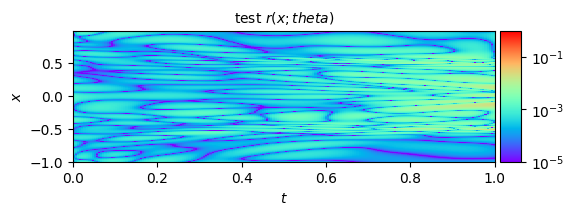

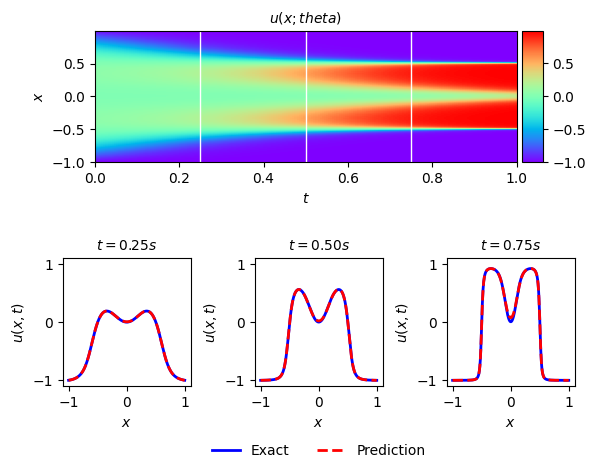

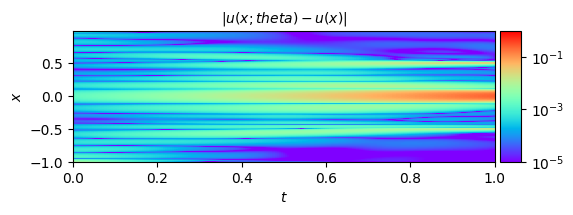

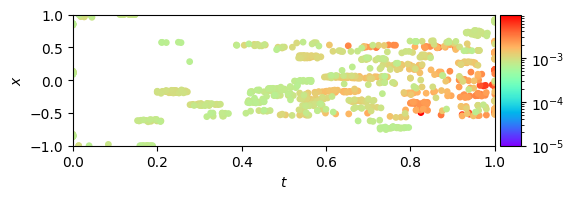

k= 7
1000 tensor(7.7992e-07, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(7.7003e-07, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(7.6364e-07, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(7.5932e-07, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(7.5612e-07, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(7.5330e-07, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(7.5109e-07, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(7.4899e-07, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(7.4718e-07, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(7.4561e-07, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(7.4394e-07, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(7.4242e-07, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(7.4109e-07, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(7.3951e-07, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(7.3833e-07, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(7

125000 tensor(6.6319e-07, device='cuda:0', grad_fn=<AddBackward0>)
126000 tensor(6.6284e-07, device='cuda:0', grad_fn=<AddBackward0>)
127000 tensor(6.9740e-07, device='cuda:0', grad_fn=<AddBackward0>)
128000 tensor(6.6180e-07, device='cuda:0', grad_fn=<AddBackward0>)
129000 tensor(6.6139e-07, device='cuda:0', grad_fn=<AddBackward0>)
130000 tensor(6.9224e-07, device='cuda:0', grad_fn=<AddBackward0>)
131000 tensor(6.6035e-07, device='cuda:0', grad_fn=<AddBackward0>)
132000 tensor(6.5996e-07, device='cuda:0', grad_fn=<AddBackward0>)
133000 tensor(6.5940e-07, device='cuda:0', grad_fn=<AddBackward0>)
134000 tensor(6.5891e-07, device='cuda:0', grad_fn=<AddBackward0>)
135000 tensor(6.5853e-07, device='cuda:0', grad_fn=<AddBackward0>)
136000 tensor(6.5807e-07, device='cuda:0', grad_fn=<AddBackward0>)
137000 tensor(6.5756e-07, device='cuda:0', grad_fn=<AddBackward0>)
138000 tensor(6.5711e-07, device='cuda:0', grad_fn=<AddBackward0>)
139000 tensor(6.5670e-07, device='cuda:0', grad_fn=<AddBackwar

248000 tensor(6.1187e-07, device='cuda:0', grad_fn=<AddBackward0>)
249000 tensor(6.1407e-07, device='cuda:0', grad_fn=<AddBackward0>)
250000 tensor(6.1124e-07, device='cuda:0', grad_fn=<AddBackward0>)
251000 tensor(6.1086e-07, device='cuda:0', grad_fn=<AddBackward0>)
252000 tensor(6.1040e-07, device='cuda:0', grad_fn=<AddBackward0>)
253000 tensor(6.1011e-07, device='cuda:0', grad_fn=<AddBackward0>)
254000 tensor(6.0975e-07, device='cuda:0', grad_fn=<AddBackward0>)
255000 tensor(6.0941e-07, device='cuda:0', grad_fn=<AddBackward0>)
256000 tensor(6.0901e-07, device='cuda:0', grad_fn=<AddBackward0>)
257000 tensor(6.0876e-07, device='cuda:0', grad_fn=<AddBackward0>)
258000 tensor(6.0837e-07, device='cuda:0', grad_fn=<AddBackward0>)
259000 tensor(6.0790e-07, device='cuda:0', grad_fn=<AddBackward0>)
260000 tensor(6.0767e-07, device='cuda:0', grad_fn=<AddBackward0>)
261000 tensor(6.0727e-07, device='cuda:0', grad_fn=<AddBackward0>)
262000 tensor(6.0688e-07, device='cuda:0', grad_fn=<AddBackwar

371000 tensor(5.7248e-07, device='cuda:0', grad_fn=<AddBackward0>)
372000 tensor(5.7210e-07, device='cuda:0', grad_fn=<AddBackward0>)
373000 tensor(5.7191e-07, device='cuda:0', grad_fn=<AddBackward0>)
374000 tensor(5.7160e-07, device='cuda:0', grad_fn=<AddBackward0>)
375000 tensor(5.7134e-07, device='cuda:0', grad_fn=<AddBackward0>)
376000 tensor(5.7108e-07, device='cuda:0', grad_fn=<AddBackward0>)
377000 tensor(5.7083e-07, device='cuda:0', grad_fn=<AddBackward0>)
378000 tensor(5.7052e-07, device='cuda:0', grad_fn=<AddBackward0>)
379000 tensor(5.7019e-07, device='cuda:0', grad_fn=<AddBackward0>)
380000 tensor(5.7000e-07, device='cuda:0', grad_fn=<AddBackward0>)
381000 tensor(5.6963e-07, device='cuda:0', grad_fn=<AddBackward0>)
382000 tensor(5.6924e-07, device='cuda:0', grad_fn=<AddBackward0>)
383000 tensor(5.6905e-07, device='cuda:0', grad_fn=<AddBackward0>)
384000 tensor(5.6879e-07, device='cuda:0', grad_fn=<AddBackward0>)
385000 tensor(5.6844e-07, device='cuda:0', grad_fn=<AddBackwar

494000 tensor(5.4062e-07, device='cuda:0', grad_fn=<AddBackward0>)
495000 tensor(5.4033e-07, device='cuda:0', grad_fn=<AddBackward0>)
496000 tensor(5.4017e-07, device='cuda:0', grad_fn=<AddBackward0>)
497000 tensor(5.3992e-07, device='cuda:0', grad_fn=<AddBackward0>)
498000 tensor(5.3959e-07, device='cuda:0', grad_fn=<AddBackward0>)
499000 tensor(5.3945e-07, device='cuda:0', grad_fn=<AddBackward0>)
500000 tensor(5.3927e-07, device='cuda:0', grad_fn=<AddBackward0>)
501000 tensor(5.3903e-07, device='cuda:0', grad_fn=<AddBackward0>)
502000 tensor(5.3874e-07, device='cuda:0', grad_fn=<AddBackward0>)
503000 tensor(5.3860e-07, device='cuda:0', grad_fn=<AddBackward0>)
504000 tensor(5.3833e-07, device='cuda:0', grad_fn=<AddBackward0>)
505000 tensor(5.3810e-07, device='cuda:0', grad_fn=<AddBackward0>)
506000 tensor(5.3786e-07, device='cuda:0', grad_fn=<AddBackward0>)
507000 tensor(5.3772e-07, device='cuda:0', grad_fn=<AddBackward0>)
508000 tensor(5.3743e-07, device='cuda:0', grad_fn=<AddBackwar

617000 tensor(5.1419e-07, device='cuda:0', grad_fn=<AddBackward0>)
618000 tensor(5.1396e-07, device='cuda:0', grad_fn=<AddBackward0>)
619000 tensor(5.1382e-07, device='cuda:0', grad_fn=<AddBackward0>)
620000 tensor(5.1364e-07, device='cuda:0', grad_fn=<AddBackward0>)
621000 tensor(5.1340e-07, device='cuda:0', grad_fn=<AddBackward0>)
622000 tensor(5.1325e-07, device='cuda:0', grad_fn=<AddBackward0>)
623000 tensor(5.1309e-07, device='cuda:0', grad_fn=<AddBackward0>)
624000 tensor(5.1288e-07, device='cuda:0', grad_fn=<AddBackward0>)
625000 tensor(5.1267e-07, device='cuda:0', grad_fn=<AddBackward0>)
626000 tensor(5.1254e-07, device='cuda:0', grad_fn=<AddBackward0>)
627000 tensor(1.2934e-06, device='cuda:0', grad_fn=<AddBackward0>)
628000 tensor(5.1215e-07, device='cuda:0', grad_fn=<AddBackward0>)
629000 tensor(5.1195e-07, device='cuda:0', grad_fn=<AddBackward0>)
630000 tensor(5.1182e-07, device='cuda:0', grad_fn=<AddBackward0>)
631000 tensor(5.1161e-07, device='cuda:0', grad_fn=<AddBackwar

740000 tensor(4.9137e-07, device='cuda:0', grad_fn=<AddBackward0>)
741000 tensor(4.9129e-07, device='cuda:0', grad_fn=<AddBackward0>)
742000 tensor(4.9109e-07, device='cuda:0', grad_fn=<AddBackward0>)
743000 tensor(4.9093e-07, device='cuda:0', grad_fn=<AddBackward0>)
744000 tensor(4.9073e-07, device='cuda:0', grad_fn=<AddBackward0>)
745000 tensor(4.9061e-07, device='cuda:0', grad_fn=<AddBackward0>)
746000 tensor(4.9040e-07, device='cuda:0', grad_fn=<AddBackward0>)
747000 tensor(4.9025e-07, device='cuda:0', grad_fn=<AddBackward0>)
748000 tensor(4.9007e-07, device='cuda:0', grad_fn=<AddBackward0>)
749000 tensor(4.8997e-07, device='cuda:0', grad_fn=<AddBackward0>)
750000 tensor(4.8977e-07, device='cuda:0', grad_fn=<AddBackward0>)
751000 tensor(4.8956e-07, device='cuda:0', grad_fn=<AddBackward0>)
752000 tensor(4.8944e-07, device='cuda:0', grad_fn=<AddBackward0>)
753000 tensor(4.8932e-07, device='cuda:0', grad_fn=<AddBackward0>)
754000 tensor(4.8912e-07, device='cuda:0', grad_fn=<AddBackwar

863000 tensor(4.7214e-07, device='cuda:0', grad_fn=<AddBackward0>)
864000 tensor(4.7198e-07, device='cuda:0', grad_fn=<AddBackward0>)
865000 tensor(8.5787e-07, device='cuda:0', grad_fn=<AddBackward0>)
866000 tensor(4.7166e-07, device='cuda:0', grad_fn=<AddBackward0>)
867000 tensor(4.7152e-07, device='cuda:0', grad_fn=<AddBackward0>)
868000 tensor(4.7138e-07, device='cuda:0', grad_fn=<AddBackward0>)
869000 tensor(4.7119e-07, device='cuda:0', grad_fn=<AddBackward0>)
870000 tensor(4.7109e-07, device='cuda:0', grad_fn=<AddBackward0>)
871000 tensor(4.7094e-07, device='cuda:0', grad_fn=<AddBackward0>)
872000 tensor(4.7081e-07, device='cuda:0', grad_fn=<AddBackward0>)
873000 tensor(4.7061e-07, device='cuda:0', grad_fn=<AddBackward0>)
874000 tensor(4.7053e-07, device='cuda:0', grad_fn=<AddBackward0>)
875000 tensor(4.7037e-07, device='cuda:0', grad_fn=<AddBackward0>)
876000 tensor(4.7024e-07, device='cuda:0', grad_fn=<AddBackward0>)
877000 tensor(4.7074e-07, device='cuda:0', grad_fn=<AddBackwar

986000 tensor(4.5458e-07, device='cuda:0', grad_fn=<AddBackward0>)
987000 tensor(4.5445e-07, device='cuda:0', grad_fn=<AddBackward0>)
988000 tensor(4.5432e-07, device='cuda:0', grad_fn=<AddBackward0>)
989000 tensor(4.5425e-07, device='cuda:0', grad_fn=<AddBackward0>)
990000 tensor(4.5409e-07, device='cuda:0', grad_fn=<AddBackward0>)
991000 tensor(4.5395e-07, device='cuda:0', grad_fn=<AddBackward0>)
992000 tensor(4.5379e-07, device='cuda:0', grad_fn=<AddBackward0>)
993000 tensor(4.5372e-07, device='cuda:0', grad_fn=<AddBackward0>)
994000 tensor(4.5358e-07, device='cuda:0', grad_fn=<AddBackward0>)
995000 tensor(4.5340e-07, device='cuda:0', grad_fn=<AddBackward0>)
996000 tensor(4.5333e-07, device='cuda:0', grad_fn=<AddBackward0>)
997000 tensor(4.5456e-07, device='cuda:0', grad_fn=<AddBackward0>)
998000 tensor(4.5301e-07, device='cuda:0', grad_fn=<AddBackward0>)
999000 tensor(4.5283e-07, device='cuda:0', grad_fn=<AddBackward0>)
1000000 tensor(4.5277e-07, device='cuda:0', grad_fn=<AddBackwa

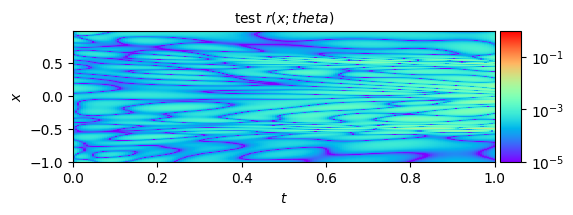

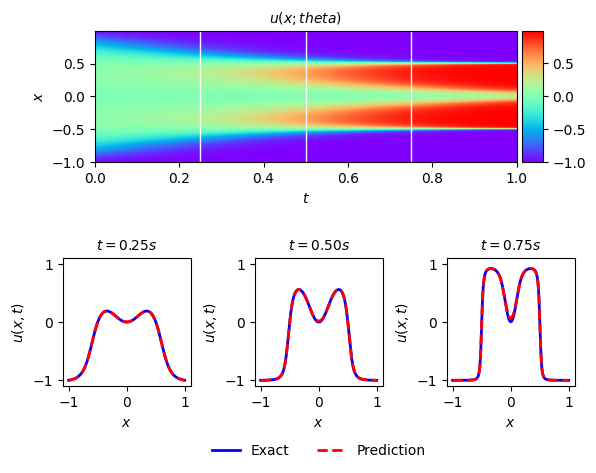

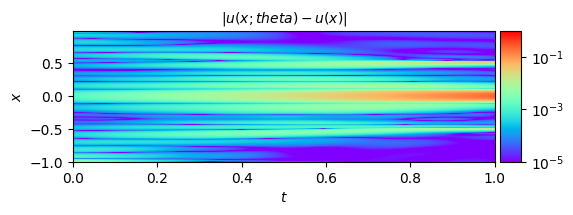

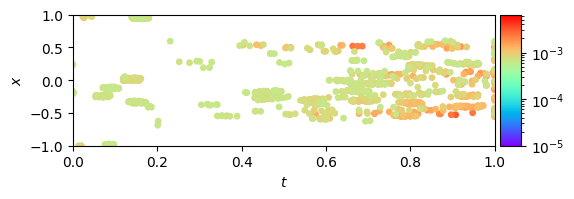

k= 8
1000 tensor(5.3008e-07, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(5.2805e-07, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(3.4713e-06, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(5.2592e-07, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(5.2514e-07, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(5.2429e-07, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(5.2375e-07, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(5.2319e-07, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(5.7211e-07, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(5.2212e-07, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(5.2160e-07, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(5.2110e-07, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(5.2079e-07, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(5.2033e-07, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(5.1981e-07, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(5

125000 tensor(4.9046e-07, device='cuda:0', grad_fn=<AddBackward0>)
126000 tensor(4.9022e-07, device='cuda:0', grad_fn=<AddBackward0>)
127000 tensor(4.8994e-07, device='cuda:0', grad_fn=<AddBackward0>)
128000 tensor(4.8975e-07, device='cuda:0', grad_fn=<AddBackward0>)
129000 tensor(4.8955e-07, device='cuda:0', grad_fn=<AddBackward0>)
130000 tensor(4.8935e-07, device='cuda:0', grad_fn=<AddBackward0>)
131000 tensor(4.8904e-07, device='cuda:0', grad_fn=<AddBackward0>)
132000 tensor(4.8890e-07, device='cuda:0', grad_fn=<AddBackward0>)
133000 tensor(4.8866e-07, device='cuda:0', grad_fn=<AddBackward0>)
134000 tensor(4.8840e-07, device='cuda:0', grad_fn=<AddBackward0>)
135000 tensor(4.8818e-07, device='cuda:0', grad_fn=<AddBackward0>)
136000 tensor(6.0894e-07, device='cuda:0', grad_fn=<AddBackward0>)
137000 tensor(4.8777e-07, device='cuda:0', grad_fn=<AddBackward0>)
138000 tensor(4.8753e-07, device='cuda:0', grad_fn=<AddBackward0>)
139000 tensor(4.8734e-07, device='cuda:0', grad_fn=<AddBackwar

248000 tensor(4.6638e-07, device='cuda:0', grad_fn=<AddBackward0>)
249000 tensor(4.6715e-07, device='cuda:0', grad_fn=<AddBackward0>)
250000 tensor(4.6602e-07, device='cuda:0', grad_fn=<AddBackward0>)
251000 tensor(4.6585e-07, device='cuda:0', grad_fn=<AddBackward0>)
252000 tensor(4.6571e-07, device='cuda:0', grad_fn=<AddBackward0>)
253000 tensor(4.6548e-07, device='cuda:0', grad_fn=<AddBackward0>)
254000 tensor(4.6538e-07, device='cuda:0', grad_fn=<AddBackward0>)
255000 tensor(4.6515e-07, device='cuda:0', grad_fn=<AddBackward0>)
256000 tensor(4.6496e-07, device='cuda:0', grad_fn=<AddBackward0>)
257000 tensor(4.6478e-07, device='cuda:0', grad_fn=<AddBackward0>)
258000 tensor(4.6464e-07, device='cuda:0', grad_fn=<AddBackward0>)
259000 tensor(4.6447e-07, device='cuda:0', grad_fn=<AddBackward0>)
260000 tensor(4.6424e-07, device='cuda:0', grad_fn=<AddBackward0>)
261000 tensor(4.6411e-07, device='cuda:0', grad_fn=<AddBackward0>)
262000 tensor(4.6406e-07, device='cuda:0', grad_fn=<AddBackwar

371000 tensor(4.4667e-07, device='cuda:0', grad_fn=<AddBackward0>)
372000 tensor(4.4646e-07, device='cuda:0', grad_fn=<AddBackward0>)
373000 tensor(4.4633e-07, device='cuda:0', grad_fn=<AddBackward0>)
374000 tensor(4.4619e-07, device='cuda:0', grad_fn=<AddBackward0>)
375000 tensor(4.4606e-07, device='cuda:0', grad_fn=<AddBackward0>)
376000 tensor(4.4587e-07, device='cuda:0', grad_fn=<AddBackward0>)
377000 tensor(4.4577e-07, device='cuda:0', grad_fn=<AddBackward0>)
378000 tensor(4.4560e-07, device='cuda:0', grad_fn=<AddBackward0>)
379000 tensor(4.4544e-07, device='cuda:0', grad_fn=<AddBackward0>)
380000 tensor(4.4526e-07, device='cuda:0', grad_fn=<AddBackward0>)
381000 tensor(4.4518e-07, device='cuda:0', grad_fn=<AddBackward0>)
382000 tensor(4.4501e-07, device='cuda:0', grad_fn=<AddBackward0>)
383000 tensor(4.4488e-07, device='cuda:0', grad_fn=<AddBackward0>)
384000 tensor(4.4469e-07, device='cuda:0', grad_fn=<AddBackward0>)
385000 tensor(4.4459e-07, device='cuda:0', grad_fn=<AddBackwar

494000 tensor(4.3008e-07, device='cuda:0', grad_fn=<AddBackward0>)
495000 tensor(4.2993e-07, device='cuda:0', grad_fn=<AddBackward0>)
496000 tensor(4.2982e-07, device='cuda:0', grad_fn=<AddBackward0>)
497000 tensor(4.2972e-07, device='cuda:0', grad_fn=<AddBackward0>)
498000 tensor(4.2958e-07, device='cuda:0', grad_fn=<AddBackward0>)
499000 tensor(4.2941e-07, device='cuda:0', grad_fn=<AddBackward0>)
500000 tensor(4.2932e-07, device='cuda:0', grad_fn=<AddBackward0>)
501000 tensor(4.2918e-07, device='cuda:0', grad_fn=<AddBackward0>)
502000 tensor(4.2906e-07, device='cuda:0', grad_fn=<AddBackward0>)
503000 tensor(4.2891e-07, device='cuda:0', grad_fn=<AddBackward0>)
504000 tensor(4.2883e-07, device='cuda:0', grad_fn=<AddBackward0>)
505000 tensor(4.2870e-07, device='cuda:0', grad_fn=<AddBackward0>)
506000 tensor(4.2856e-07, device='cuda:0', grad_fn=<AddBackward0>)
507000 tensor(4.2845e-07, device='cuda:0', grad_fn=<AddBackward0>)
508000 tensor(4.2832e-07, device='cuda:0', grad_fn=<AddBackwar

617000 tensor(4.1545e-07, device='cuda:0', grad_fn=<AddBackward0>)
618000 tensor(4.1528e-07, device='cuda:0', grad_fn=<AddBackward0>)
619000 tensor(4.1524e-07, device='cuda:0', grad_fn=<AddBackward0>)
620000 tensor(4.1511e-07, device='cuda:0', grad_fn=<AddBackward0>)
621000 tensor(4.1499e-07, device='cuda:0', grad_fn=<AddBackward0>)
622000 tensor(4.1487e-07, device='cuda:0', grad_fn=<AddBackward0>)
623000 tensor(4.1475e-07, device='cuda:0', grad_fn=<AddBackward0>)
624000 tensor(4.1465e-07, device='cuda:0', grad_fn=<AddBackward0>)
625000 tensor(7.2160e-07, device='cuda:0', grad_fn=<AddBackward0>)
626000 tensor(4.1443e-07, device='cuda:0', grad_fn=<AddBackward0>)
627000 tensor(1.5443e-06, device='cuda:0', grad_fn=<AddBackward0>)
628000 tensor(4.1422e-07, device='cuda:0', grad_fn=<AddBackward0>)
629000 tensor(4.1422e-07, device='cuda:0', grad_fn=<AddBackward0>)
630000 tensor(4.1398e-07, device='cuda:0', grad_fn=<AddBackward0>)
631000 tensor(4.1387e-07, device='cuda:0', grad_fn=<AddBackwar

740000 tensor(4.0296e-07, device='cuda:0', grad_fn=<AddBackward0>)
741000 tensor(4.0287e-07, device='cuda:0', grad_fn=<AddBackward0>)
742000 tensor(4.0274e-07, device='cuda:0', grad_fn=<AddBackward0>)
743000 tensor(4.0266e-07, device='cuda:0', grad_fn=<AddBackward0>)
744000 tensor(4.0260e-07, device='cuda:0', grad_fn=<AddBackward0>)
745000 tensor(4.0249e-07, device='cuda:0', grad_fn=<AddBackward0>)
746000 tensor(4.0239e-07, device='cuda:0', grad_fn=<AddBackward0>)
747000 tensor(4.0225e-07, device='cuda:0', grad_fn=<AddBackward0>)
748000 tensor(4.0223e-07, device='cuda:0', grad_fn=<AddBackward0>)
749000 tensor(4.0211e-07, device='cuda:0', grad_fn=<AddBackward0>)
750000 tensor(4.0202e-07, device='cuda:0', grad_fn=<AddBackward0>)
751000 tensor(4.0189e-07, device='cuda:0', grad_fn=<AddBackward0>)
752000 tensor(4.0183e-07, device='cuda:0', grad_fn=<AddBackward0>)
753000 tensor(4.0178e-07, device='cuda:0', grad_fn=<AddBackward0>)
754000 tensor(4.0163e-07, device='cuda:0', grad_fn=<AddBackwar

863000 tensor(3.9200e-07, device='cuda:0', grad_fn=<AddBackward0>)
864000 tensor(5.0233e-07, device='cuda:0', grad_fn=<AddBackward0>)
865000 tensor(3.9187e-07, device='cuda:0', grad_fn=<AddBackward0>)
866000 tensor(1.0856e-05, device='cuda:0', grad_fn=<AddBackward0>)
867000 tensor(3.9168e-07, device='cuda:0', grad_fn=<AddBackward0>)
868000 tensor(2.7143e-06, device='cuda:0', grad_fn=<AddBackward0>)
869000 tensor(3.9151e-07, device='cuda:0', grad_fn=<AddBackward0>)
870000 tensor(4.4978e-07, device='cuda:0', grad_fn=<AddBackward0>)
871000 tensor(3.9134e-07, device='cuda:0', grad_fn=<AddBackward0>)
872000 tensor(3.9122e-07, device='cuda:0', grad_fn=<AddBackward0>)
873000 tensor(3.9117e-07, device='cuda:0', grad_fn=<AddBackward0>)
874000 tensor(3.9104e-07, device='cuda:0', grad_fn=<AddBackward0>)
875000 tensor(3.9098e-07, device='cuda:0', grad_fn=<AddBackward0>)
876000 tensor(3.9093e-07, device='cuda:0', grad_fn=<AddBackward0>)
877000 tensor(3.9083e-07, device='cuda:0', grad_fn=<AddBackwar

986000 tensor(3.8220e-07, device='cuda:0', grad_fn=<AddBackward0>)
987000 tensor(3.8206e-07, device='cuda:0', grad_fn=<AddBackward0>)
988000 tensor(3.8202e-07, device='cuda:0', grad_fn=<AddBackward0>)
989000 tensor(3.8197e-07, device='cuda:0', grad_fn=<AddBackward0>)
990000 tensor(3.8184e-07, device='cuda:0', grad_fn=<AddBackward0>)
991000 tensor(3.8192e-07, device='cuda:0', grad_fn=<AddBackward0>)
992000 tensor(3.8171e-07, device='cuda:0', grad_fn=<AddBackward0>)
993000 tensor(6.2701e-07, device='cuda:0', grad_fn=<AddBackward0>)
994000 tensor(3.8152e-07, device='cuda:0', grad_fn=<AddBackward0>)
995000 tensor(5.5531e-05, device='cuda:0', grad_fn=<AddBackward0>)
996000 tensor(3.8138e-07, device='cuda:0', grad_fn=<AddBackward0>)
997000 tensor(3.8130e-07, device='cuda:0', grad_fn=<AddBackward0>)
998000 tensor(3.8121e-07, device='cuda:0', grad_fn=<AddBackward0>)
999000 tensor(3.8110e-07, device='cuda:0', grad_fn=<AddBackward0>)
1000000 tensor(3.8102e-07, device='cuda:0', grad_fn=<AddBackwa

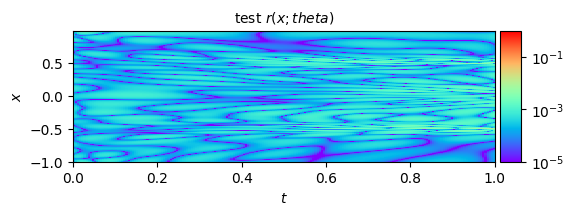

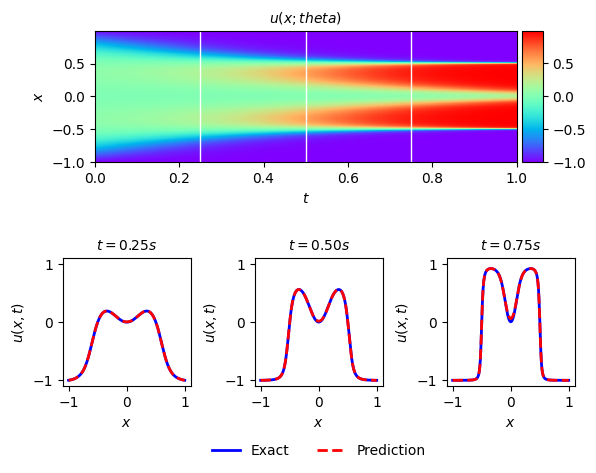

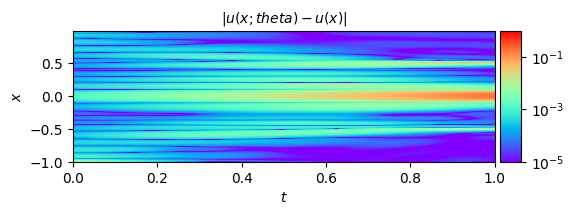

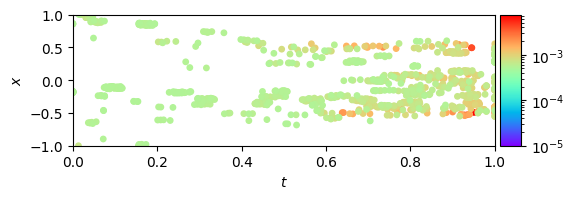

k= 9
1000 tensor(4.4259e-07, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(4.7017e-07, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(6.5292e-07, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(4.3977e-07, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(4.3925e-07, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(4.3881e-07, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(4.3838e-07, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(4.3799e-07, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(4.3774e-07, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(4.3741e-07, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(4.3706e-07, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(4.3676e-07, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(4.3654e-07, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(4.3641e-07, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(4.3612e-07, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(4

125000 tensor(4.2113e-07, device='cuda:0', grad_fn=<AddBackward0>)
126000 tensor(4.2103e-07, device='cuda:0', grad_fn=<AddBackward0>)
127000 tensor(4.2087e-07, device='cuda:0', grad_fn=<AddBackward0>)
128000 tensor(4.2081e-07, device='cuda:0', grad_fn=<AddBackward0>)
129000 tensor(4.2070e-07, device='cuda:0', grad_fn=<AddBackward0>)
130000 tensor(4.2055e-07, device='cuda:0', grad_fn=<AddBackward0>)
131000 tensor(4.2045e-07, device='cuda:0', grad_fn=<AddBackward0>)
132000 tensor(4.2031e-07, device='cuda:0', grad_fn=<AddBackward0>)
133000 tensor(4.2021e-07, device='cuda:0', grad_fn=<AddBackward0>)
134000 tensor(4.2004e-07, device='cuda:0', grad_fn=<AddBackward0>)
135000 tensor(4.2000e-07, device='cuda:0', grad_fn=<AddBackward0>)
136000 tensor(4.7548e-07, device='cuda:0', grad_fn=<AddBackward0>)
137000 tensor(4.1981e-07, device='cuda:0', grad_fn=<AddBackward0>)
138000 tensor(4.5806e-07, device='cuda:0', grad_fn=<AddBackward0>)
139000 tensor(4.1960e-07, device='cuda:0', grad_fn=<AddBackwar

248000 tensor(4.0924e-07, device='cuda:0', grad_fn=<AddBackward0>)
249000 tensor(4.0912e-07, device='cuda:0', grad_fn=<AddBackward0>)
250000 tensor(4.0908e-07, device='cuda:0', grad_fn=<AddBackward0>)
251000 tensor(4.0897e-07, device='cuda:0', grad_fn=<AddBackward0>)
252000 tensor(4.0884e-07, device='cuda:0', grad_fn=<AddBackward0>)
253000 tensor(4.0876e-07, device='cuda:0', grad_fn=<AddBackward0>)
254000 tensor(4.0872e-07, device='cuda:0', grad_fn=<AddBackward0>)
255000 tensor(4.0858e-07, device='cuda:0', grad_fn=<AddBackward0>)
256000 tensor(4.0844e-07, device='cuda:0', grad_fn=<AddBackward0>)
257000 tensor(4.0840e-07, device='cuda:0', grad_fn=<AddBackward0>)
258000 tensor(4.0833e-07, device='cuda:0', grad_fn=<AddBackward0>)
259000 tensor(4.0823e-07, device='cuda:0', grad_fn=<AddBackward0>)
260000 tensor(4.0818e-07, device='cuda:0', grad_fn=<AddBackward0>)
261000 tensor(4.0808e-07, device='cuda:0', grad_fn=<AddBackward0>)
262000 tensor(4.0798e-07, device='cuda:0', grad_fn=<AddBackwar

371000 tensor(3.9878e-07, device='cuda:0', grad_fn=<AddBackward0>)
372000 tensor(3.9873e-07, device='cuda:0', grad_fn=<AddBackward0>)
373000 tensor(3.9867e-07, device='cuda:0', grad_fn=<AddBackward0>)
374000 tensor(3.9857e-07, device='cuda:0', grad_fn=<AddBackward0>)
375000 tensor(3.9847e-07, device='cuda:0', grad_fn=<AddBackward0>)
376000 tensor(3.9844e-07, device='cuda:0', grad_fn=<AddBackward0>)
377000 tensor(3.9841e-07, device='cuda:0', grad_fn=<AddBackward0>)
378000 tensor(3.9827e-07, device='cuda:0', grad_fn=<AddBackward0>)
379000 tensor(3.9809e-07, device='cuda:0', grad_fn=<AddBackward0>)
380000 tensor(3.9808e-07, device='cuda:0', grad_fn=<AddBackward0>)
381000 tensor(9.6793e-06, device='cuda:0', grad_fn=<AddBackward0>)
382000 tensor(3.9789e-07, device='cuda:0', grad_fn=<AddBackward0>)
383000 tensor(3.9777e-07, device='cuda:0', grad_fn=<AddBackward0>)
384000 tensor(3.9772e-07, device='cuda:0', grad_fn=<AddBackward0>)
385000 tensor(3.9763e-07, device='cuda:0', grad_fn=<AddBackwar

494000 tensor(3.8963e-07, device='cuda:0', grad_fn=<AddBackward0>)
495000 tensor(3.8953e-07, device='cuda:0', grad_fn=<AddBackward0>)
496000 tensor(3.8949e-07, device='cuda:0', grad_fn=<AddBackward0>)
497000 tensor(3.8941e-07, device='cuda:0', grad_fn=<AddBackward0>)
498000 tensor(3.8930e-07, device='cuda:0', grad_fn=<AddBackward0>)
499000 tensor(3.8923e-07, device='cuda:0', grad_fn=<AddBackward0>)
500000 tensor(3.8918e-07, device='cuda:0', grad_fn=<AddBackward0>)
501000 tensor(3.8911e-07, device='cuda:0', grad_fn=<AddBackward0>)
502000 tensor(3.8901e-07, device='cuda:0', grad_fn=<AddBackward0>)
503000 tensor(3.8896e-07, device='cuda:0', grad_fn=<AddBackward0>)
504000 tensor(3.8892e-07, device='cuda:0', grad_fn=<AddBackward0>)
505000 tensor(3.8884e-07, device='cuda:0', grad_fn=<AddBackward0>)
506000 tensor(3.8872e-07, device='cuda:0', grad_fn=<AddBackward0>)
507000 tensor(3.8862e-07, device='cuda:0', grad_fn=<AddBackward0>)
508000 tensor(3.8859e-07, device='cuda:0', grad_fn=<AddBackwar

617000 tensor(3.8142e-07, device='cuda:0', grad_fn=<AddBackward0>)
618000 tensor(3.8136e-07, device='cuda:0', grad_fn=<AddBackward0>)
619000 tensor(3.8133e-07, device='cuda:0', grad_fn=<AddBackward0>)
620000 tensor(3.8120e-07, device='cuda:0', grad_fn=<AddBackward0>)
621000 tensor(3.8116e-07, device='cuda:0', grad_fn=<AddBackward0>)
622000 tensor(3.8112e-07, device='cuda:0', grad_fn=<AddBackward0>)
623000 tensor(3.8103e-07, device='cuda:0', grad_fn=<AddBackward0>)
624000 tensor(3.8093e-07, device='cuda:0', grad_fn=<AddBackward0>)
625000 tensor(3.8087e-07, device='cuda:0', grad_fn=<AddBackward0>)
626000 tensor(3.8082e-07, device='cuda:0', grad_fn=<AddBackward0>)
627000 tensor(3.8076e-07, device='cuda:0', grad_fn=<AddBackward0>)
628000 tensor(3.8070e-07, device='cuda:0', grad_fn=<AddBackward0>)
629000 tensor(3.8062e-07, device='cuda:0', grad_fn=<AddBackward0>)
630000 tensor(3.8057e-07, device='cuda:0', grad_fn=<AddBackward0>)
631000 tensor(3.8049e-07, device='cuda:0', grad_fn=<AddBackwar

740000 tensor(3.7368e-07, device='cuda:0', grad_fn=<AddBackward0>)
741000 tensor(3.7364e-07, device='cuda:0', grad_fn=<AddBackward0>)
742000 tensor(3.7353e-07, device='cuda:0', grad_fn=<AddBackward0>)
743000 tensor(3.7348e-07, device='cuda:0', grad_fn=<AddBackward0>)
744000 tensor(3.7342e-07, device='cuda:0', grad_fn=<AddBackward0>)
745000 tensor(3.7338e-07, device='cuda:0', grad_fn=<AddBackward0>)
746000 tensor(3.7332e-07, device='cuda:0', grad_fn=<AddBackward0>)
747000 tensor(3.7324e-07, device='cuda:0', grad_fn=<AddBackward0>)
748000 tensor(3.7321e-07, device='cuda:0', grad_fn=<AddBackward0>)
749000 tensor(3.7316e-07, device='cuda:0', grad_fn=<AddBackward0>)
750000 tensor(3.7310e-07, device='cuda:0', grad_fn=<AddBackward0>)
751000 tensor(3.7301e-07, device='cuda:0', grad_fn=<AddBackward0>)
752000 tensor(3.7298e-07, device='cuda:0', grad_fn=<AddBackward0>)
753000 tensor(3.7292e-07, device='cuda:0', grad_fn=<AddBackward0>)
754000 tensor(3.7285e-07, device='cuda:0', grad_fn=<AddBackwar

863000 tensor(3.6676e-07, device='cuda:0', grad_fn=<AddBackward0>)
864000 tensor(3.6665e-07, device='cuda:0', grad_fn=<AddBackward0>)
865000 tensor(3.6665e-07, device='cuda:0', grad_fn=<AddBackward0>)
866000 tensor(3.6658e-07, device='cuda:0', grad_fn=<AddBackward0>)
867000 tensor(3.6652e-07, device='cuda:0', grad_fn=<AddBackward0>)
868000 tensor(3.6643e-07, device='cuda:0', grad_fn=<AddBackward0>)
869000 tensor(3.6641e-07, device='cuda:0', grad_fn=<AddBackward0>)
870000 tensor(3.6638e-07, device='cuda:0', grad_fn=<AddBackward0>)
871000 tensor(3.6630e-07, device='cuda:0', grad_fn=<AddBackward0>)
872000 tensor(3.6622e-07, device='cuda:0', grad_fn=<AddBackward0>)
873000 tensor(3.6619e-07, device='cuda:0', grad_fn=<AddBackward0>)
874000 tensor(3.6614e-07, device='cuda:0', grad_fn=<AddBackward0>)
875000 tensor(3.6608e-07, device='cuda:0', grad_fn=<AddBackward0>)
876000 tensor(3.6602e-07, device='cuda:0', grad_fn=<AddBackward0>)
877000 tensor(3.6601e-07, device='cuda:0', grad_fn=<AddBackwar

986000 tensor(3.7543e-07, device='cuda:0', grad_fn=<AddBackward0>)
987000 tensor(3.6044e-07, device='cuda:0', grad_fn=<AddBackward0>)
988000 tensor(3.8412e-07, device='cuda:0', grad_fn=<AddBackward0>)
989000 tensor(3.6036e-07, device='cuda:0', grad_fn=<AddBackward0>)
990000 tensor(3.6026e-07, device='cuda:0', grad_fn=<AddBackward0>)
991000 tensor(3.6023e-07, device='cuda:0', grad_fn=<AddBackward0>)
992000 tensor(3.6020e-07, device='cuda:0', grad_fn=<AddBackward0>)
993000 tensor(3.6015e-07, device='cuda:0', grad_fn=<AddBackward0>)
994000 tensor(3.6008e-07, device='cuda:0', grad_fn=<AddBackward0>)
995000 tensor(3.6003e-07, device='cuda:0', grad_fn=<AddBackward0>)
996000 tensor(3.6000e-07, device='cuda:0', grad_fn=<AddBackward0>)
997000 tensor(3.5996e-07, device='cuda:0', grad_fn=<AddBackward0>)
998000 tensor(3.5989e-07, device='cuda:0', grad_fn=<AddBackward0>)
999000 tensor(3.5980e-07, device='cuda:0', grad_fn=<AddBackward0>)
1000000 tensor(3.5980e-07, device='cuda:0', grad_fn=<AddBackwa

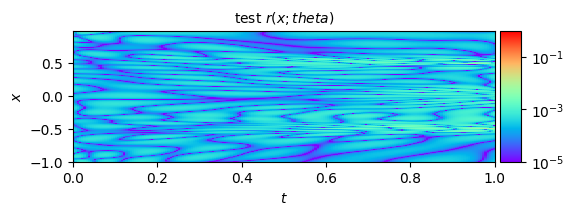

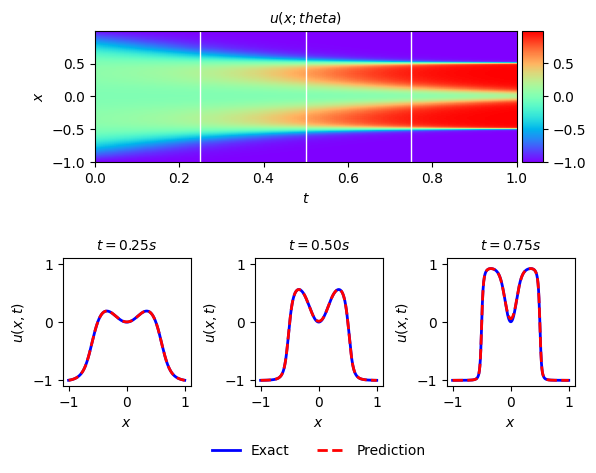

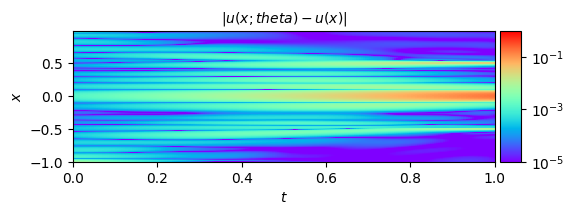

In [6]:
''' k=5 '''
for k in range(5,10):
    x_train = np.vstack([x_train, x_adv])
    x_adv = generate_attack_samples(PINN, device, x_train, N0)
    print("k=", k)
    retrain(PINN, x_train, x_adv, x_boundary, u_boundary, x_test, u_test, U_gt)

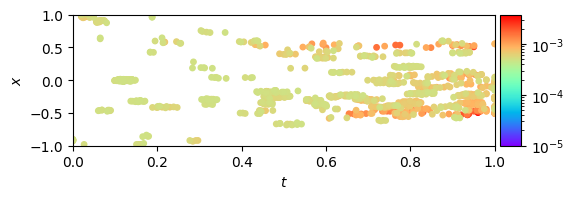

k= 5
1000 tensor(3.9290e-07, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(3.9264e-07, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(3.9245e-07, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(3.9233e-07, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(3.9216e-07, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(3.9201e-07, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(4.0297e-07, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(3.9176e-07, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(4.0564e-07, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(3.9151e-07, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(3.9140e-07, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(3.9127e-07, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(3.9117e-07, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(3.9510e-07, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(3.9099e-07, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(3

125000 tensor(3.8266e-07, device='cuda:0', grad_fn=<AddBackward0>)
126000 tensor(3.8259e-07, device='cuda:0', grad_fn=<AddBackward0>)
127000 tensor(3.8253e-07, device='cuda:0', grad_fn=<AddBackward0>)
128000 tensor(3.8245e-07, device='cuda:0', grad_fn=<AddBackward0>)
129000 tensor(3.8240e-07, device='cuda:0', grad_fn=<AddBackward0>)
130000 tensor(3.8235e-07, device='cuda:0', grad_fn=<AddBackward0>)
131000 tensor(4.4672e-07, device='cuda:0', grad_fn=<AddBackward0>)
132000 tensor(3.8218e-07, device='cuda:0', grad_fn=<AddBackward0>)
133000 tensor(3.8213e-07, device='cuda:0', grad_fn=<AddBackward0>)
134000 tensor(3.8206e-07, device='cuda:0', grad_fn=<AddBackward0>)
135000 tensor(3.8200e-07, device='cuda:0', grad_fn=<AddBackward0>)
136000 tensor(3.8194e-07, device='cuda:0', grad_fn=<AddBackward0>)
137000 tensor(3.8189e-07, device='cuda:0', grad_fn=<AddBackward0>)
138000 tensor(3.8180e-07, device='cuda:0', grad_fn=<AddBackward0>)
139000 tensor(3.8176e-07, device='cuda:0', grad_fn=<AddBackwar

248000 tensor(3.7511e-07, device='cuda:0', grad_fn=<AddBackward0>)
249000 tensor(4.0574e-07, device='cuda:0', grad_fn=<AddBackward0>)
250000 tensor(3.7497e-07, device='cuda:0', grad_fn=<AddBackward0>)
251000 tensor(3.7492e-07, device='cuda:0', grad_fn=<AddBackward0>)
252000 tensor(3.7486e-07, device='cuda:0', grad_fn=<AddBackward0>)
253000 tensor(3.7481e-07, device='cuda:0', grad_fn=<AddBackward0>)
254000 tensor(3.7475e-07, device='cuda:0', grad_fn=<AddBackward0>)
255000 tensor(3.7468e-07, device='cuda:0', grad_fn=<AddBackward0>)
256000 tensor(3.7461e-07, device='cuda:0', grad_fn=<AddBackward0>)
257000 tensor(3.7459e-07, device='cuda:0', grad_fn=<AddBackward0>)
258000 tensor(3.7448e-07, device='cuda:0', grad_fn=<AddBackward0>)
259000 tensor(3.7442e-07, device='cuda:0', grad_fn=<AddBackward0>)
260000 tensor(3.7436e-07, device='cuda:0', grad_fn=<AddBackward0>)
261000 tensor(3.7957e-07, device='cuda:0', grad_fn=<AddBackward0>)
262000 tensor(3.7426e-07, device='cuda:0', grad_fn=<AddBackwar

371000 tensor(3.6816e-07, device='cuda:0', grad_fn=<AddBackward0>)
372000 tensor(3.6814e-07, device='cuda:0', grad_fn=<AddBackward0>)
373000 tensor(3.6805e-07, device='cuda:0', grad_fn=<AddBackward0>)
374000 tensor(3.6796e-07, device='cuda:0', grad_fn=<AddBackward0>)
375000 tensor(3.6790e-07, device='cuda:0', grad_fn=<AddBackward0>)
376000 tensor(3.6787e-07, device='cuda:0', grad_fn=<AddBackward0>)
377000 tensor(3.6781e-07, device='cuda:0', grad_fn=<AddBackward0>)
378000 tensor(3.6778e-07, device='cuda:0', grad_fn=<AddBackward0>)
379000 tensor(3.6781e-07, device='cuda:0', grad_fn=<AddBackward0>)
380000 tensor(3.6765e-07, device='cuda:0', grad_fn=<AddBackward0>)
381000 tensor(3.6756e-07, device='cuda:0', grad_fn=<AddBackward0>)
382000 tensor(3.6753e-07, device='cuda:0', grad_fn=<AddBackward0>)
383000 tensor(3.6750e-07, device='cuda:0', grad_fn=<AddBackward0>)
384000 tensor(3.6743e-07, device='cuda:0', grad_fn=<AddBackward0>)
385000 tensor(3.6733e-07, device='cuda:0', grad_fn=<AddBackwar

494000 tensor(3.6190e-07, device='cuda:0', grad_fn=<AddBackward0>)
495000 tensor(3.6184e-07, device='cuda:0', grad_fn=<AddBackward0>)
496000 tensor(3.6176e-07, device='cuda:0', grad_fn=<AddBackward0>)
497000 tensor(3.6171e-07, device='cuda:0', grad_fn=<AddBackward0>)
498000 tensor(3.6169e-07, device='cuda:0', grad_fn=<AddBackward0>)
499000 tensor(3.6164e-07, device='cuda:0', grad_fn=<AddBackward0>)
500000 tensor(3.6156e-07, device='cuda:0', grad_fn=<AddBackward0>)
501000 tensor(3.6152e-07, device='cuda:0', grad_fn=<AddBackward0>)
502000 tensor(3.6148e-07, device='cuda:0', grad_fn=<AddBackward0>)
503000 tensor(3.6144e-07, device='cuda:0', grad_fn=<AddBackward0>)
504000 tensor(3.6286e-07, device='cuda:0', grad_fn=<AddBackward0>)
505000 tensor(3.6130e-07, device='cuda:0', grad_fn=<AddBackward0>)
506000 tensor(3.6125e-07, device='cuda:0', grad_fn=<AddBackward0>)
507000 tensor(3.6124e-07, device='cuda:0', grad_fn=<AddBackward0>)
508000 tensor(3.6117e-07, device='cuda:0', grad_fn=<AddBackwar

617000 tensor(3.5609e-07, device='cuda:0', grad_fn=<AddBackward0>)
618000 tensor(3.5606e-07, device='cuda:0', grad_fn=<AddBackward0>)
619000 tensor(3.5600e-07, device='cuda:0', grad_fn=<AddBackward0>)
620000 tensor(3.5597e-07, device='cuda:0', grad_fn=<AddBackward0>)
621000 tensor(3.5592e-07, device='cuda:0', grad_fn=<AddBackward0>)
622000 tensor(3.5590e-07, device='cuda:0', grad_fn=<AddBackward0>)
623000 tensor(3.5583e-07, device='cuda:0', grad_fn=<AddBackward0>)
624000 tensor(3.5582e-07, device='cuda:0', grad_fn=<AddBackward0>)
625000 tensor(3.5644e-07, device='cuda:0', grad_fn=<AddBackward0>)
626000 tensor(3.5571e-07, device='cuda:0', grad_fn=<AddBackward0>)
627000 tensor(3.5569e-07, device='cuda:0', grad_fn=<AddBackward0>)
628000 tensor(3.5561e-07, device='cuda:0', grad_fn=<AddBackward0>)
629000 tensor(3.5631e-07, device='cuda:0', grad_fn=<AddBackward0>)
630000 tensor(3.5550e-07, device='cuda:0', grad_fn=<AddBackward0>)
631000 tensor(3.5543e-07, device='cuda:0', grad_fn=<AddBackwar

740000 tensor(3.5053e-07, device='cuda:0', grad_fn=<AddBackward0>)
741000 tensor(3.5052e-07, device='cuda:0', grad_fn=<AddBackward0>)
742000 tensor(3.5048e-07, device='cuda:0', grad_fn=<AddBackward0>)
743000 tensor(3.5043e-07, device='cuda:0', grad_fn=<AddBackward0>)
744000 tensor(3.5036e-07, device='cuda:0', grad_fn=<AddBackward0>)
745000 tensor(3.5033e-07, device='cuda:0', grad_fn=<AddBackward0>)
746000 tensor(5.0583e-07, device='cuda:0', grad_fn=<AddBackward0>)
747000 tensor(3.5025e-07, device='cuda:0', grad_fn=<AddBackward0>)
748000 tensor(3.5020e-07, device='cuda:0', grad_fn=<AddBackward0>)
749000 tensor(3.5019e-07, device='cuda:0', grad_fn=<AddBackward0>)
750000 tensor(3.5025e-07, device='cuda:0', grad_fn=<AddBackward0>)
751000 tensor(3.5009e-07, device='cuda:0', grad_fn=<AddBackward0>)
752000 tensor(3.5004e-07, device='cuda:0', grad_fn=<AddBackward0>)
753000 tensor(3.5002e-07, device='cuda:0', grad_fn=<AddBackward0>)
754000 tensor(3.4992e-07, device='cuda:0', grad_fn=<AddBackwar

863000 tensor(3.4540e-07, device='cuda:0', grad_fn=<AddBackward0>)
864000 tensor(3.4536e-07, device='cuda:0', grad_fn=<AddBackward0>)
865000 tensor(3.4536e-07, device='cuda:0', grad_fn=<AddBackward0>)
866000 tensor(3.4533e-07, device='cuda:0', grad_fn=<AddBackward0>)
867000 tensor(3.4524e-07, device='cuda:0', grad_fn=<AddBackward0>)
868000 tensor(3.4521e-07, device='cuda:0', grad_fn=<AddBackward0>)
869000 tensor(3.4518e-07, device='cuda:0', grad_fn=<AddBackward0>)
870000 tensor(3.4513e-07, device='cuda:0', grad_fn=<AddBackward0>)
871000 tensor(3.4507e-07, device='cuda:0', grad_fn=<AddBackward0>)
872000 tensor(3.4506e-07, device='cuda:0', grad_fn=<AddBackward0>)
873000 tensor(3.4500e-07, device='cuda:0', grad_fn=<AddBackward0>)
874000 tensor(3.4498e-07, device='cuda:0', grad_fn=<AddBackward0>)
875000 tensor(3.4495e-07, device='cuda:0', grad_fn=<AddBackward0>)
876000 tensor(3.4491e-07, device='cuda:0', grad_fn=<AddBackward0>)
877000 tensor(3.4485e-07, device='cuda:0', grad_fn=<AddBackwar

986000 tensor(3.4040e-07, device='cuda:0', grad_fn=<AddBackward0>)
987000 tensor(3.4037e-07, device='cuda:0', grad_fn=<AddBackward0>)
988000 tensor(3.4033e-07, device='cuda:0', grad_fn=<AddBackward0>)
989000 tensor(3.4027e-07, device='cuda:0', grad_fn=<AddBackward0>)
990000 tensor(3.4025e-07, device='cuda:0', grad_fn=<AddBackward0>)
991000 tensor(3.4020e-07, device='cuda:0', grad_fn=<AddBackward0>)
992000 tensor(3.4018e-07, device='cuda:0', grad_fn=<AddBackward0>)
993000 tensor(3.4011e-07, device='cuda:0', grad_fn=<AddBackward0>)
994000 tensor(3.4009e-07, device='cuda:0', grad_fn=<AddBackward0>)
995000 tensor(1.2457e-06, device='cuda:0', grad_fn=<AddBackward0>)
996000 tensor(3.4004e-07, device='cuda:0', grad_fn=<AddBackward0>)
997000 tensor(3.3998e-07, device='cuda:0', grad_fn=<AddBackward0>)
998000 tensor(3.3996e-07, device='cuda:0', grad_fn=<AddBackward0>)
999000 tensor(3.3992e-07, device='cuda:0', grad_fn=<AddBackward0>)
1000000 tensor(3.3989e-07, device='cuda:0', grad_fn=<AddBackwa

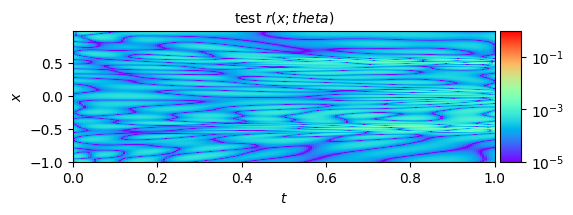

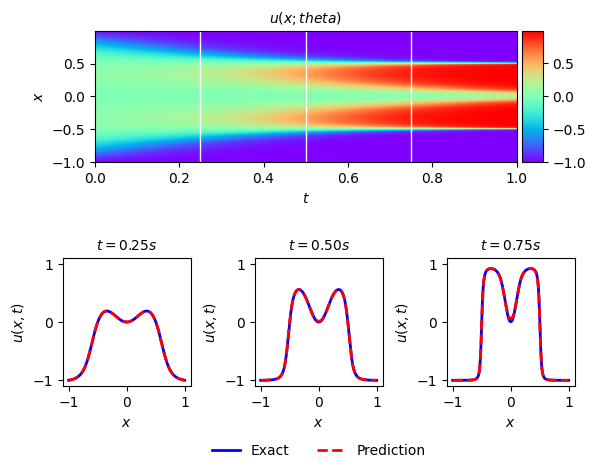

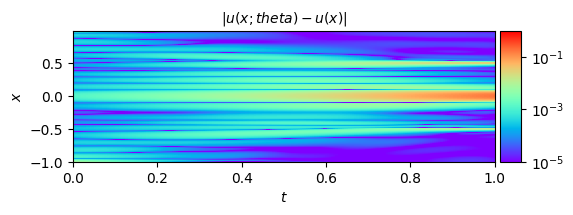

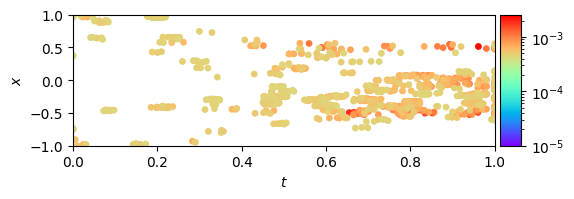

k= 6
1000 tensor(3.6403e-07, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(3.6379e-07, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(3.6362e-07, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(3.6350e-07, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(1.0265e-06, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(3.6334e-07, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(3.6320e-07, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(3.6317e-07, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(3.6310e-07, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(3.6302e-07, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(3.6294e-07, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(3.6285e-07, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(3.6276e-07, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(3.6265e-07, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(3.6262e-07, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(3

125000 tensor(3.5676e-07, device='cuda:0', grad_fn=<AddBackward0>)
126000 tensor(3.5669e-07, device='cuda:0', grad_fn=<AddBackward0>)
127000 tensor(3.5666e-07, device='cuda:0', grad_fn=<AddBackward0>)
128000 tensor(3.5664e-07, device='cuda:0', grad_fn=<AddBackward0>)
129000 tensor(3.5655e-07, device='cuda:0', grad_fn=<AddBackward0>)
130000 tensor(3.5651e-07, device='cuda:0', grad_fn=<AddBackward0>)
131000 tensor(3.5643e-07, device='cuda:0', grad_fn=<AddBackward0>)
132000 tensor(3.5642e-07, device='cuda:0', grad_fn=<AddBackward0>)
133000 tensor(3.5637e-07, device='cuda:0', grad_fn=<AddBackward0>)
134000 tensor(3.5630e-07, device='cuda:0', grad_fn=<AddBackward0>)
135000 tensor(3.5627e-07, device='cuda:0', grad_fn=<AddBackward0>)
136000 tensor(3.5624e-07, device='cuda:0', grad_fn=<AddBackward0>)
137000 tensor(3.5620e-07, device='cuda:0', grad_fn=<AddBackward0>)
138000 tensor(3.5613e-07, device='cuda:0', grad_fn=<AddBackward0>)
139000 tensor(3.5611e-07, device='cuda:0', grad_fn=<AddBackwar

248000 tensor(3.5121e-07, device='cuda:0', grad_fn=<AddBackward0>)
249000 tensor(3.5118e-07, device='cuda:0', grad_fn=<AddBackward0>)
250000 tensor(4.4916e-07, device='cuda:0', grad_fn=<AddBackward0>)
251000 tensor(3.5108e-07, device='cuda:0', grad_fn=<AddBackward0>)
252000 tensor(3.5105e-07, device='cuda:0', grad_fn=<AddBackward0>)
253000 tensor(3.5101e-07, device='cuda:0', grad_fn=<AddBackward0>)
254000 tensor(3.5094e-07, device='cuda:0', grad_fn=<AddBackward0>)
255000 tensor(3.5088e-07, device='cuda:0', grad_fn=<AddBackward0>)
256000 tensor(3.5083e-07, device='cuda:0', grad_fn=<AddBackward0>)
257000 tensor(3.5081e-07, device='cuda:0', grad_fn=<AddBackward0>)
258000 tensor(3.5079e-07, device='cuda:0', grad_fn=<AddBackward0>)
259000 tensor(3.5073e-07, device='cuda:0', grad_fn=<AddBackward0>)
260000 tensor(3.5113e-07, device='cuda:0', grad_fn=<AddBackward0>)
261000 tensor(3.5063e-07, device='cuda:0', grad_fn=<AddBackward0>)
262000 tensor(3.5061e-07, device='cuda:0', grad_fn=<AddBackwar

371000 tensor(3.4612e-07, device='cuda:0', grad_fn=<AddBackward0>)
372000 tensor(3.4609e-07, device='cuda:0', grad_fn=<AddBackward0>)
373000 tensor(3.4601e-07, device='cuda:0', grad_fn=<AddBackward0>)
374000 tensor(3.4600e-07, device='cuda:0', grad_fn=<AddBackward0>)
375000 tensor(3.4596e-07, device='cuda:0', grad_fn=<AddBackward0>)
376000 tensor(3.4592e-07, device='cuda:0', grad_fn=<AddBackward0>)
377000 tensor(3.4586e-07, device='cuda:0', grad_fn=<AddBackward0>)
378000 tensor(3.4585e-07, device='cuda:0', grad_fn=<AddBackward0>)
379000 tensor(3.4580e-07, device='cuda:0', grad_fn=<AddBackward0>)
380000 tensor(3.4575e-07, device='cuda:0', grad_fn=<AddBackward0>)
381000 tensor(3.4570e-07, device='cuda:0', grad_fn=<AddBackward0>)
382000 tensor(3.4567e-07, device='cuda:0', grad_fn=<AddBackward0>)
383000 tensor(3.4564e-07, device='cuda:0', grad_fn=<AddBackward0>)
384000 tensor(3.4559e-07, device='cuda:0', grad_fn=<AddBackward0>)
385000 tensor(3.4557e-07, device='cuda:0', grad_fn=<AddBackwar

494000 tensor(3.4136e-07, device='cuda:0', grad_fn=<AddBackward0>)
495000 tensor(3.4130e-07, device='cuda:0', grad_fn=<AddBackward0>)
496000 tensor(3.4129e-07, device='cuda:0', grad_fn=<AddBackward0>)
497000 tensor(3.4122e-07, device='cuda:0', grad_fn=<AddBackward0>)
498000 tensor(3.4119e-07, device='cuda:0', grad_fn=<AddBackward0>)
499000 tensor(3.4117e-07, device='cuda:0', grad_fn=<AddBackward0>)
500000 tensor(3.4110e-07, device='cuda:0', grad_fn=<AddBackward0>)
501000 tensor(3.4110e-07, device='cuda:0', grad_fn=<AddBackward0>)
502000 tensor(3.4107e-07, device='cuda:0', grad_fn=<AddBackward0>)
503000 tensor(3.4099e-07, device='cuda:0', grad_fn=<AddBackward0>)
504000 tensor(3.4091e-07, device='cuda:0', grad_fn=<AddBackward0>)
505000 tensor(3.4090e-07, device='cuda:0', grad_fn=<AddBackward0>)
506000 tensor(3.4089e-07, device='cuda:0', grad_fn=<AddBackward0>)
507000 tensor(3.4083e-07, device='cuda:0', grad_fn=<AddBackward0>)
508000 tensor(3.6297e-07, device='cuda:0', grad_fn=<AddBackwar

617000 tensor(3.3687e-07, device='cuda:0', grad_fn=<AddBackward0>)
618000 tensor(3.3684e-07, device='cuda:0', grad_fn=<AddBackward0>)
619000 tensor(3.3681e-07, device='cuda:0', grad_fn=<AddBackward0>)
620000 tensor(3.3679e-07, device='cuda:0', grad_fn=<AddBackward0>)
621000 tensor(3.3679e-07, device='cuda:0', grad_fn=<AddBackward0>)
622000 tensor(3.3673e-07, device='cuda:0', grad_fn=<AddBackward0>)
623000 tensor(3.3670e-07, device='cuda:0', grad_fn=<AddBackward0>)
624000 tensor(3.3668e-07, device='cuda:0', grad_fn=<AddBackward0>)
625000 tensor(3.3662e-07, device='cuda:0', grad_fn=<AddBackward0>)
626000 tensor(3.3661e-07, device='cuda:0', grad_fn=<AddBackward0>)
627000 tensor(4.2527e-07, device='cuda:0', grad_fn=<AddBackward0>)
628000 tensor(3.3654e-07, device='cuda:0', grad_fn=<AddBackward0>)
629000 tensor(3.3648e-07, device='cuda:0', grad_fn=<AddBackward0>)
630000 tensor(3.3645e-07, device='cuda:0', grad_fn=<AddBackward0>)
631000 tensor(3.3639e-07, device='cuda:0', grad_fn=<AddBackwar

740000 tensor(3.3269e-07, device='cuda:0', grad_fn=<AddBackward0>)
741000 tensor(3.3267e-07, device='cuda:0', grad_fn=<AddBackward0>)
742000 tensor(3.3266e-07, device='cuda:0', grad_fn=<AddBackward0>)
743000 tensor(3.3263e-07, device='cuda:0', grad_fn=<AddBackward0>)
744000 tensor(3.3259e-07, device='cuda:0', grad_fn=<AddBackward0>)
745000 tensor(3.3256e-07, device='cuda:0', grad_fn=<AddBackward0>)
746000 tensor(3.3255e-07, device='cuda:0', grad_fn=<AddBackward0>)
747000 tensor(3.3251e-07, device='cuda:0', grad_fn=<AddBackward0>)
748000 tensor(3.3246e-07, device='cuda:0', grad_fn=<AddBackward0>)
749000 tensor(3.3242e-07, device='cuda:0', grad_fn=<AddBackward0>)
750000 tensor(3.3241e-07, device='cuda:0', grad_fn=<AddBackward0>)
751000 tensor(3.3241e-07, device='cuda:0', grad_fn=<AddBackward0>)
752000 tensor(3.3234e-07, device='cuda:0', grad_fn=<AddBackward0>)
753000 tensor(3.3227e-07, device='cuda:0', grad_fn=<AddBackward0>)
754000 tensor(3.3229e-07, device='cuda:0', grad_fn=<AddBackwar

863000 tensor(3.2888e-07, device='cuda:0', grad_fn=<AddBackward0>)
864000 tensor(3.2888e-07, device='cuda:0', grad_fn=<AddBackward0>)
865000 tensor(3.2883e-07, device='cuda:0', grad_fn=<AddBackward0>)
866000 tensor(3.2879e-07, device='cuda:0', grad_fn=<AddBackward0>)
867000 tensor(3.2878e-07, device='cuda:0', grad_fn=<AddBackward0>)
868000 tensor(3.2872e-07, device='cuda:0', grad_fn=<AddBackward0>)
869000 tensor(3.2872e-07, device='cuda:0', grad_fn=<AddBackward0>)
870000 tensor(3.2869e-07, device='cuda:0', grad_fn=<AddBackward0>)
871000 tensor(3.2867e-07, device='cuda:0', grad_fn=<AddBackward0>)
872000 tensor(3.2862e-07, device='cuda:0', grad_fn=<AddBackward0>)
873000 tensor(3.2859e-07, device='cuda:0', grad_fn=<AddBackward0>)
874000 tensor(3.2855e-07, device='cuda:0', grad_fn=<AddBackward0>)
875000 tensor(3.2855e-07, device='cuda:0', grad_fn=<AddBackward0>)
876000 tensor(3.2853e-07, device='cuda:0', grad_fn=<AddBackward0>)
877000 tensor(3.2846e-07, device='cuda:0', grad_fn=<AddBackwar

986000 tensor(3.2519e-07, device='cuda:0', grad_fn=<AddBackward0>)
987000 tensor(3.2518e-07, device='cuda:0', grad_fn=<AddBackward0>)
988000 tensor(3.2516e-07, device='cuda:0', grad_fn=<AddBackward0>)
989000 tensor(3.2512e-07, device='cuda:0', grad_fn=<AddBackward0>)
990000 tensor(3.2511e-07, device='cuda:0', grad_fn=<AddBackward0>)
991000 tensor(3.2507e-07, device='cuda:0', grad_fn=<AddBackward0>)
992000 tensor(3.2505e-07, device='cuda:0', grad_fn=<AddBackward0>)
993000 tensor(3.2503e-07, device='cuda:0', grad_fn=<AddBackward0>)
994000 tensor(3.2500e-07, device='cuda:0', grad_fn=<AddBackward0>)
995000 tensor(3.2498e-07, device='cuda:0', grad_fn=<AddBackward0>)
996000 tensor(3.2492e-07, device='cuda:0', grad_fn=<AddBackward0>)
997000 tensor(3.2491e-07, device='cuda:0', grad_fn=<AddBackward0>)
998000 tensor(3.2488e-07, device='cuda:0', grad_fn=<AddBackward0>)
999000 tensor(3.2485e-07, device='cuda:0', grad_fn=<AddBackward0>)
1000000 tensor(3.2480e-07, device='cuda:0', grad_fn=<AddBackwa

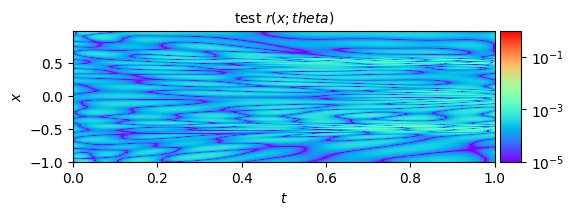

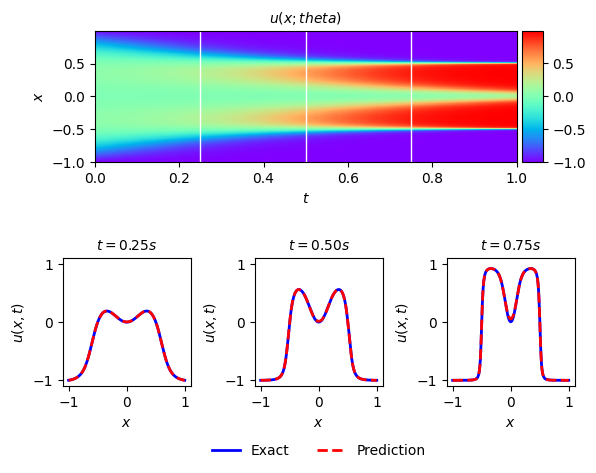

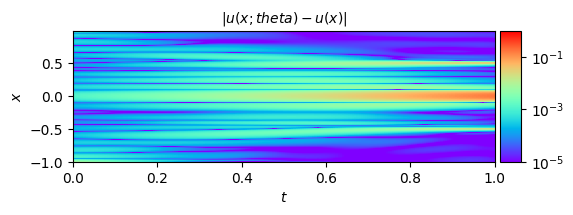

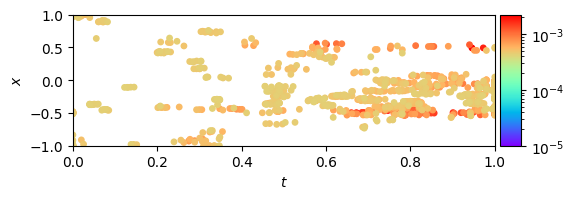

k= 7
1000 tensor(3.4282e-07, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(3.4265e-07, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(3.4252e-07, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(3.4244e-07, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(3.4238e-07, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(3.4226e-07, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(3.4224e-07, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(3.4280e-07, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(3.4209e-07, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(3.4202e-07, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(3.4199e-07, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(2.1661e-06, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(3.4189e-07, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(3.4180e-07, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(3.4177e-07, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(5

125000 tensor(3.3750e-07, device='cuda:0', grad_fn=<AddBackward0>)
126000 tensor(3.3745e-07, device='cuda:0', grad_fn=<AddBackward0>)
127000 tensor(3.3746e-07, device='cuda:0', grad_fn=<AddBackward0>)
128000 tensor(3.3741e-07, device='cuda:0', grad_fn=<AddBackward0>)
129000 tensor(3.3738e-07, device='cuda:0', grad_fn=<AddBackward0>)
130000 tensor(3.3733e-07, device='cuda:0', grad_fn=<AddBackward0>)
131000 tensor(3.3731e-07, device='cuda:0', grad_fn=<AddBackward0>)
132000 tensor(3.3727e-07, device='cuda:0', grad_fn=<AddBackward0>)
133000 tensor(3.3721e-07, device='cuda:0', grad_fn=<AddBackward0>)
134000 tensor(3.3716e-07, device='cuda:0', grad_fn=<AddBackward0>)
135000 tensor(3.3714e-07, device='cuda:0', grad_fn=<AddBackward0>)
136000 tensor(3.3708e-07, device='cuda:0', grad_fn=<AddBackward0>)
137000 tensor(3.3706e-07, device='cuda:0', grad_fn=<AddBackward0>)
138000 tensor(3.3705e-07, device='cuda:0', grad_fn=<AddBackward0>)
139000 tensor(3.3700e-07, device='cuda:0', grad_fn=<AddBackwar

248000 tensor(3.3332e-07, device='cuda:0', grad_fn=<AddBackward0>)
249000 tensor(3.3329e-07, device='cuda:0', grad_fn=<AddBackward0>)
250000 tensor(3.3327e-07, device='cuda:0', grad_fn=<AddBackward0>)
251000 tensor(3.3324e-07, device='cuda:0', grad_fn=<AddBackward0>)
252000 tensor(3.3319e-07, device='cuda:0', grad_fn=<AddBackward0>)
253000 tensor(3.3317e-07, device='cuda:0', grad_fn=<AddBackward0>)
254000 tensor(3.3314e-07, device='cuda:0', grad_fn=<AddBackward0>)
255000 tensor(3.3309e-07, device='cuda:0', grad_fn=<AddBackward0>)
256000 tensor(3.3309e-07, device='cuda:0', grad_fn=<AddBackward0>)
257000 tensor(3.3835e-07, device='cuda:0', grad_fn=<AddBackward0>)
258000 tensor(3.3303e-07, device='cuda:0', grad_fn=<AddBackward0>)
259000 tensor(3.3298e-07, device='cuda:0', grad_fn=<AddBackward0>)
260000 tensor(3.3298e-07, device='cuda:0', grad_fn=<AddBackward0>)
261000 tensor(3.3292e-07, device='cuda:0', grad_fn=<AddBackward0>)
262000 tensor(3.3289e-07, device='cuda:0', grad_fn=<AddBackwar

371000 tensor(3.2949e-07, device='cuda:0', grad_fn=<AddBackward0>)
372000 tensor(3.2943e-07, device='cuda:0', grad_fn=<AddBackward0>)
373000 tensor(3.2940e-07, device='cuda:0', grad_fn=<AddBackward0>)
374000 tensor(3.2938e-07, device='cuda:0', grad_fn=<AddBackward0>)
375000 tensor(3.2939e-07, device='cuda:0', grad_fn=<AddBackward0>)
376000 tensor(3.2934e-07, device='cuda:0', grad_fn=<AddBackward0>)
377000 tensor(3.2929e-07, device='cuda:0', grad_fn=<AddBackward0>)
378000 tensor(3.2927e-07, device='cuda:0', grad_fn=<AddBackward0>)
379000 tensor(3.2927e-07, device='cuda:0', grad_fn=<AddBackward0>)
380000 tensor(3.2924e-07, device='cuda:0', grad_fn=<AddBackward0>)
381000 tensor(3.2918e-07, device='cuda:0', grad_fn=<AddBackward0>)
382000 tensor(3.2917e-07, device='cuda:0', grad_fn=<AddBackward0>)
383000 tensor(3.2914e-07, device='cuda:0', grad_fn=<AddBackward0>)
384000 tensor(3.2912e-07, device='cuda:0', grad_fn=<AddBackward0>)
385000 tensor(3.2907e-07, device='cuda:0', grad_fn=<AddBackwar

494000 tensor(3.2579e-07, device='cuda:0', grad_fn=<AddBackward0>)
495000 tensor(3.2579e-07, device='cuda:0', grad_fn=<AddBackward0>)
496000 tensor(3.2575e-07, device='cuda:0', grad_fn=<AddBackward0>)
497000 tensor(3.2571e-07, device='cuda:0', grad_fn=<AddBackward0>)
498000 tensor(3.2570e-07, device='cuda:0', grad_fn=<AddBackward0>)
499000 tensor(3.2571e-07, device='cuda:0', grad_fn=<AddBackward0>)
500000 tensor(3.2564e-07, device='cuda:0', grad_fn=<AddBackward0>)
501000 tensor(3.2587e-07, device='cuda:0', grad_fn=<AddBackward0>)
502000 tensor(3.2556e-07, device='cuda:0', grad_fn=<AddBackward0>)
503000 tensor(3.8530e-07, device='cuda:0', grad_fn=<AddBackward0>)
504000 tensor(3.2554e-07, device='cuda:0', grad_fn=<AddBackward0>)
505000 tensor(3.2548e-07, device='cuda:0', grad_fn=<AddBackward0>)
506000 tensor(3.2545e-07, device='cuda:0', grad_fn=<AddBackward0>)
507000 tensor(3.2543e-07, device='cuda:0', grad_fn=<AddBackward0>)
508000 tensor(3.2540e-07, device='cuda:0', grad_fn=<AddBackwar

617000 tensor(3.2245e-07, device='cuda:0', grad_fn=<AddBackward0>)
618000 tensor(3.2241e-07, device='cuda:0', grad_fn=<AddBackward0>)
619000 tensor(3.2238e-07, device='cuda:0', grad_fn=<AddBackward0>)
620000 tensor(3.2235e-07, device='cuda:0', grad_fn=<AddBackward0>)
621000 tensor(3.2234e-07, device='cuda:0', grad_fn=<AddBackward0>)
622000 tensor(3.2231e-07, device='cuda:0', grad_fn=<AddBackward0>)
623000 tensor(3.2225e-07, device='cuda:0', grad_fn=<AddBackward0>)
624000 tensor(3.2224e-07, device='cuda:0', grad_fn=<AddBackward0>)
625000 tensor(3.2222e-07, device='cuda:0', grad_fn=<AddBackward0>)
626000 tensor(3.2220e-07, device='cuda:0', grad_fn=<AddBackward0>)
627000 tensor(3.2214e-07, device='cuda:0', grad_fn=<AddBackward0>)
628000 tensor(3.2214e-07, device='cuda:0', grad_fn=<AddBackward0>)
629000 tensor(3.2213e-07, device='cuda:0', grad_fn=<AddBackward0>)
630000 tensor(3.2210e-07, device='cuda:0', grad_fn=<AddBackward0>)
631000 tensor(3.2206e-07, device='cuda:0', grad_fn=<AddBackwar

740000 tensor(3.1921e-07, device='cuda:0', grad_fn=<AddBackward0>)
741000 tensor(3.1920e-07, device='cuda:0', grad_fn=<AddBackward0>)
742000 tensor(3.1915e-07, device='cuda:0', grad_fn=<AddBackward0>)
743000 tensor(3.1915e-07, device='cuda:0', grad_fn=<AddBackward0>)
744000 tensor(3.1913e-07, device='cuda:0', grad_fn=<AddBackward0>)
745000 tensor(3.1908e-07, device='cuda:0', grad_fn=<AddBackward0>)
746000 tensor(3.1903e-07, device='cuda:0', grad_fn=<AddBackward0>)
747000 tensor(3.1903e-07, device='cuda:0', grad_fn=<AddBackward0>)
748000 tensor(3.1899e-07, device='cuda:0', grad_fn=<AddBackward0>)
749000 tensor(3.1897e-07, device='cuda:0', grad_fn=<AddBackward0>)
750000 tensor(3.1894e-07, device='cuda:0', grad_fn=<AddBackward0>)
751000 tensor(3.1890e-07, device='cuda:0', grad_fn=<AddBackward0>)
752000 tensor(3.1960e-07, device='cuda:0', grad_fn=<AddBackward0>)
753000 tensor(3.1886e-07, device='cuda:0', grad_fn=<AddBackward0>)
754000 tensor(3.1883e-07, device='cuda:0', grad_fn=<AddBackwar

863000 tensor(3.1614e-07, device='cuda:0', grad_fn=<AddBackward0>)
864000 tensor(3.1611e-07, device='cuda:0', grad_fn=<AddBackward0>)
865000 tensor(3.1608e-07, device='cuda:0', grad_fn=<AddBackward0>)
866000 tensor(3.1605e-07, device='cuda:0', grad_fn=<AddBackward0>)
867000 tensor(3.1603e-07, device='cuda:0', grad_fn=<AddBackward0>)
868000 tensor(3.1600e-07, device='cuda:0', grad_fn=<AddBackward0>)
869000 tensor(3.1596e-07, device='cuda:0', grad_fn=<AddBackward0>)
870000 tensor(3.1594e-07, device='cuda:0', grad_fn=<AddBackward0>)
871000 tensor(3.1590e-07, device='cuda:0', grad_fn=<AddBackward0>)
872000 tensor(3.1589e-07, device='cuda:0', grad_fn=<AddBackward0>)
873000 tensor(3.1587e-07, device='cuda:0', grad_fn=<AddBackward0>)
874000 tensor(3.1584e-07, device='cuda:0', grad_fn=<AddBackward0>)
875000 tensor(3.1581e-07, device='cuda:0', grad_fn=<AddBackward0>)
876000 tensor(3.1581e-07, device='cuda:0', grad_fn=<AddBackward0>)
877000 tensor(3.1578e-07, device='cuda:0', grad_fn=<AddBackwar

986000 tensor(3.1319e-07, device='cuda:0', grad_fn=<AddBackward0>)
987000 tensor(3.1315e-07, device='cuda:0', grad_fn=<AddBackward0>)
988000 tensor(3.1314e-07, device='cuda:0', grad_fn=<AddBackward0>)
989000 tensor(3.1311e-07, device='cuda:0', grad_fn=<AddBackward0>)
990000 tensor(3.1308e-07, device='cuda:0', grad_fn=<AddBackward0>)
991000 tensor(3.1308e-07, device='cuda:0', grad_fn=<AddBackward0>)
992000 tensor(3.1305e-07, device='cuda:0', grad_fn=<AddBackward0>)
993000 tensor(3.1299e-07, device='cuda:0', grad_fn=<AddBackward0>)
994000 tensor(3.1299e-07, device='cuda:0', grad_fn=<AddBackward0>)
995000 tensor(3.1309e-07, device='cuda:0', grad_fn=<AddBackward0>)
996000 tensor(3.1298e-07, device='cuda:0', grad_fn=<AddBackward0>)
997000 tensor(3.1290e-07, device='cuda:0', grad_fn=<AddBackward0>)
998000 tensor(3.1290e-07, device='cuda:0', grad_fn=<AddBackward0>)
999000 tensor(3.1289e-07, device='cuda:0', grad_fn=<AddBackward0>)
1000000 tensor(3.1287e-07, device='cuda:0', grad_fn=<AddBackwa

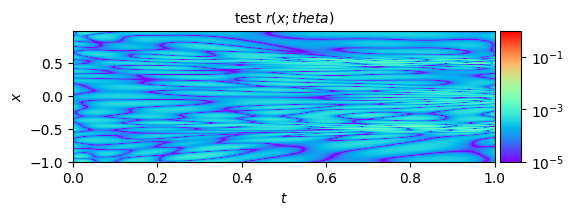

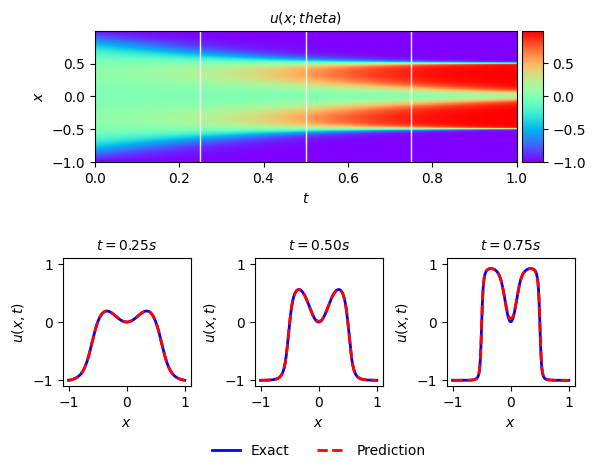

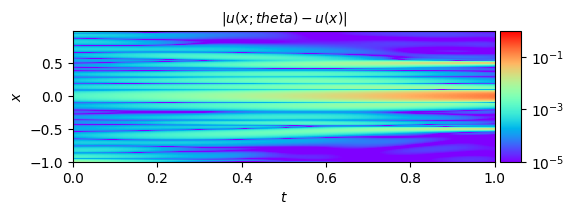

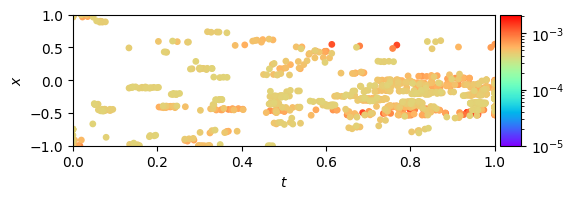

k= 8
1000 tensor(3.2440e-07, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(3.2431e-07, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(3.2422e-07, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(3.2417e-07, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(3.2414e-07, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(3.2409e-07, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(3.2403e-07, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(3.2398e-07, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(3.2396e-07, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(3.2393e-07, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(3.2388e-07, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(3.2384e-07, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(3.2382e-07, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(3.2377e-07, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(3.2371e-07, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(3

125000 tensor(3.2052e-07, device='cuda:0', grad_fn=<AddBackward0>)
126000 tensor(3.2047e-07, device='cuda:0', grad_fn=<AddBackward0>)
127000 tensor(3.2045e-07, device='cuda:0', grad_fn=<AddBackward0>)
128000 tensor(3.2044e-07, device='cuda:0', grad_fn=<AddBackward0>)
129000 tensor(3.2041e-07, device='cuda:0', grad_fn=<AddBackward0>)
130000 tensor(3.2039e-07, device='cuda:0', grad_fn=<AddBackward0>)
131000 tensor(3.2035e-07, device='cuda:0', grad_fn=<AddBackward0>)
132000 tensor(3.2033e-07, device='cuda:0', grad_fn=<AddBackward0>)
133000 tensor(3.2030e-07, device='cuda:0', grad_fn=<AddBackward0>)
134000 tensor(3.2026e-07, device='cuda:0', grad_fn=<AddBackward0>)
135000 tensor(3.2023e-07, device='cuda:0', grad_fn=<AddBackward0>)
136000 tensor(3.2022e-07, device='cuda:0', grad_fn=<AddBackward0>)
137000 tensor(3.2017e-07, device='cuda:0', grad_fn=<AddBackward0>)
138000 tensor(3.2013e-07, device='cuda:0', grad_fn=<AddBackward0>)
139000 tensor(3.2009e-07, device='cuda:0', grad_fn=<AddBackwar

248000 tensor(3.1737e-07, device='cuda:0', grad_fn=<AddBackward0>)
249000 tensor(3.1735e-07, device='cuda:0', grad_fn=<AddBackward0>)
250000 tensor(3.1734e-07, device='cuda:0', grad_fn=<AddBackward0>)
251000 tensor(3.1731e-07, device='cuda:0', grad_fn=<AddBackward0>)
252000 tensor(3.1725e-07, device='cuda:0', grad_fn=<AddBackward0>)
253000 tensor(3.1727e-07, device='cuda:0', grad_fn=<AddBackward0>)
254000 tensor(3.1724e-07, device='cuda:0', grad_fn=<AddBackward0>)
255000 tensor(3.1721e-07, device='cuda:0', grad_fn=<AddBackward0>)
256000 tensor(3.1719e-07, device='cuda:0', grad_fn=<AddBackward0>)
257000 tensor(3.1717e-07, device='cuda:0', grad_fn=<AddBackward0>)
258000 tensor(3.1717e-07, device='cuda:0', grad_fn=<AddBackward0>)
259000 tensor(3.1713e-07, device='cuda:0', grad_fn=<AddBackward0>)
260000 tensor(3.1712e-07, device='cuda:0', grad_fn=<AddBackward0>)
261000 tensor(3.1708e-07, device='cuda:0', grad_fn=<AddBackward0>)
262000 tensor(3.1707e-07, device='cuda:0', grad_fn=<AddBackwar

371000 tensor(3.1448e-07, device='cuda:0', grad_fn=<AddBackward0>)
372000 tensor(3.1447e-07, device='cuda:0', grad_fn=<AddBackward0>)
373000 tensor(3.1444e-07, device='cuda:0', grad_fn=<AddBackward0>)
374000 tensor(3.1441e-07, device='cuda:0', grad_fn=<AddBackward0>)
375000 tensor(3.1440e-07, device='cuda:0', grad_fn=<AddBackward0>)
376000 tensor(3.1436e-07, device='cuda:0', grad_fn=<AddBackward0>)
377000 tensor(3.1435e-07, device='cuda:0', grad_fn=<AddBackward0>)
378000 tensor(3.1690e-07, device='cuda:0', grad_fn=<AddBackward0>)
379000 tensor(3.1431e-07, device='cuda:0', grad_fn=<AddBackward0>)
380000 tensor(3.1426e-07, device='cuda:0', grad_fn=<AddBackward0>)
381000 tensor(3.1425e-07, device='cuda:0', grad_fn=<AddBackward0>)
382000 tensor(3.1424e-07, device='cuda:0', grad_fn=<AddBackward0>)
383000 tensor(3.1422e-07, device='cuda:0', grad_fn=<AddBackward0>)
384000 tensor(3.1419e-07, device='cuda:0', grad_fn=<AddBackward0>)
385000 tensor(3.1414e-07, device='cuda:0', grad_fn=<AddBackwar

494000 tensor(3.1167e-07, device='cuda:0', grad_fn=<AddBackward0>)
495000 tensor(3.1162e-07, device='cuda:0', grad_fn=<AddBackward0>)
496000 tensor(3.1159e-07, device='cuda:0', grad_fn=<AddBackward0>)
497000 tensor(3.1157e-07, device='cuda:0', grad_fn=<AddBackward0>)
498000 tensor(3.1158e-07, device='cuda:0', grad_fn=<AddBackward0>)
499000 tensor(3.1154e-07, device='cuda:0', grad_fn=<AddBackward0>)
500000 tensor(3.1150e-07, device='cuda:0', grad_fn=<AddBackward0>)
501000 tensor(3.1148e-07, device='cuda:0', grad_fn=<AddBackward0>)
502000 tensor(3.1148e-07, device='cuda:0', grad_fn=<AddBackward0>)
503000 tensor(3.1145e-07, device='cuda:0', grad_fn=<AddBackward0>)
504000 tensor(3.1143e-07, device='cuda:0', grad_fn=<AddBackward0>)
505000 tensor(3.1140e-07, device='cuda:0', grad_fn=<AddBackward0>)
506000 tensor(3.1142e-07, device='cuda:0', grad_fn=<AddBackward0>)
507000 tensor(3.1139e-07, device='cuda:0', grad_fn=<AddBackward0>)
508000 tensor(3.1136e-07, device='cuda:0', grad_fn=<AddBackwar

617000 tensor(3.0897e-07, device='cuda:0', grad_fn=<AddBackward0>)
618000 tensor(3.0895e-07, device='cuda:0', grad_fn=<AddBackward0>)
619000 tensor(3.0895e-07, device='cuda:0', grad_fn=<AddBackward0>)
620000 tensor(3.0892e-07, device='cuda:0', grad_fn=<AddBackward0>)
621000 tensor(3.0888e-07, device='cuda:0', grad_fn=<AddBackward0>)
622000 tensor(3.0888e-07, device='cuda:0', grad_fn=<AddBackward0>)
623000 tensor(3.0884e-07, device='cuda:0', grad_fn=<AddBackward0>)
624000 tensor(3.0881e-07, device='cuda:0', grad_fn=<AddBackward0>)
625000 tensor(3.0880e-07, device='cuda:0', grad_fn=<AddBackward0>)
626000 tensor(3.0881e-07, device='cuda:0', grad_fn=<AddBackward0>)
627000 tensor(3.0876e-07, device='cuda:0', grad_fn=<AddBackward0>)
628000 tensor(1.5048e-06, device='cuda:0', grad_fn=<AddBackward0>)
629000 tensor(3.0869e-07, device='cuda:0', grad_fn=<AddBackward0>)
630000 tensor(3.0870e-07, device='cuda:0', grad_fn=<AddBackward0>)
631000 tensor(3.0867e-07, device='cuda:0', grad_fn=<AddBackwar

740000 tensor(3.0640e-07, device='cuda:0', grad_fn=<AddBackward0>)
741000 tensor(3.0639e-07, device='cuda:0', grad_fn=<AddBackward0>)
742000 tensor(3.0637e-07, device='cuda:0', grad_fn=<AddBackward0>)
743000 tensor(3.0634e-07, device='cuda:0', grad_fn=<AddBackward0>)
744000 tensor(3.0632e-07, device='cuda:0', grad_fn=<AddBackward0>)
745000 tensor(3.0631e-07, device='cuda:0', grad_fn=<AddBackward0>)
746000 tensor(3.0630e-07, device='cuda:0', grad_fn=<AddBackward0>)
747000 tensor(3.0626e-07, device='cuda:0', grad_fn=<AddBackward0>)
748000 tensor(3.0623e-07, device='cuda:0', grad_fn=<AddBackward0>)
749000 tensor(3.0622e-07, device='cuda:0', grad_fn=<AddBackward0>)
750000 tensor(3.0893e-07, device='cuda:0', grad_fn=<AddBackward0>)
751000 tensor(3.0619e-07, device='cuda:0', grad_fn=<AddBackward0>)
752000 tensor(3.0615e-07, device='cuda:0', grad_fn=<AddBackward0>)
753000 tensor(3.0615e-07, device='cuda:0', grad_fn=<AddBackward0>)
754000 tensor(3.0612e-07, device='cuda:0', grad_fn=<AddBackwar

863000 tensor(3.0400e-07, device='cuda:0', grad_fn=<AddBackward0>)
864000 tensor(3.0398e-07, device='cuda:0', grad_fn=<AddBackward0>)
865000 tensor(3.0394e-07, device='cuda:0', grad_fn=<AddBackward0>)
866000 tensor(3.0390e-07, device='cuda:0', grad_fn=<AddBackward0>)
867000 tensor(3.0391e-07, device='cuda:0', grad_fn=<AddBackward0>)
868000 tensor(3.0390e-07, device='cuda:0', grad_fn=<AddBackward0>)
869000 tensor(3.0388e-07, device='cuda:0', grad_fn=<AddBackward0>)
870000 tensor(3.0385e-07, device='cuda:0', grad_fn=<AddBackward0>)
871000 tensor(3.0383e-07, device='cuda:0', grad_fn=<AddBackward0>)
872000 tensor(3.0512e-07, device='cuda:0', grad_fn=<AddBackward0>)
873000 tensor(1.6915e-06, device='cuda:0', grad_fn=<AddBackward0>)
874000 tensor(3.0376e-07, device='cuda:0', grad_fn=<AddBackward0>)
875000 tensor(3.0373e-07, device='cuda:0', grad_fn=<AddBackward0>)
876000 tensor(3.0372e-07, device='cuda:0', grad_fn=<AddBackward0>)
877000 tensor(3.0369e-07, device='cuda:0', grad_fn=<AddBackwar

986000 tensor(3.0149e-07, device='cuda:0', grad_fn=<AddBackward0>)
987000 tensor(3.0146e-07, device='cuda:0', grad_fn=<AddBackward0>)
988000 tensor(3.0146e-07, device='cuda:0', grad_fn=<AddBackward0>)
989000 tensor(3.0144e-07, device='cuda:0', grad_fn=<AddBackward0>)
990000 tensor(3.0143e-07, device='cuda:0', grad_fn=<AddBackward0>)
991000 tensor(3.0142e-07, device='cuda:0', grad_fn=<AddBackward0>)
992000 tensor(3.0139e-07, device='cuda:0', grad_fn=<AddBackward0>)
993000 tensor(3.0136e-07, device='cuda:0', grad_fn=<AddBackward0>)
994000 tensor(3.0136e-07, device='cuda:0', grad_fn=<AddBackward0>)
995000 tensor(3.0131e-07, device='cuda:0', grad_fn=<AddBackward0>)
996000 tensor(3.0130e-07, device='cuda:0', grad_fn=<AddBackward0>)
997000 tensor(3.0129e-07, device='cuda:0', grad_fn=<AddBackward0>)
998000 tensor(3.0127e-07, device='cuda:0', grad_fn=<AddBackward0>)
999000 tensor(3.0286e-07, device='cuda:0', grad_fn=<AddBackward0>)
1000000 tensor(3.0123e-07, device='cuda:0', grad_fn=<AddBackwa

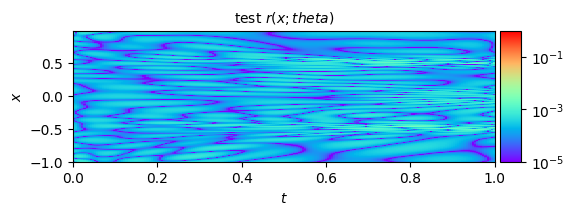

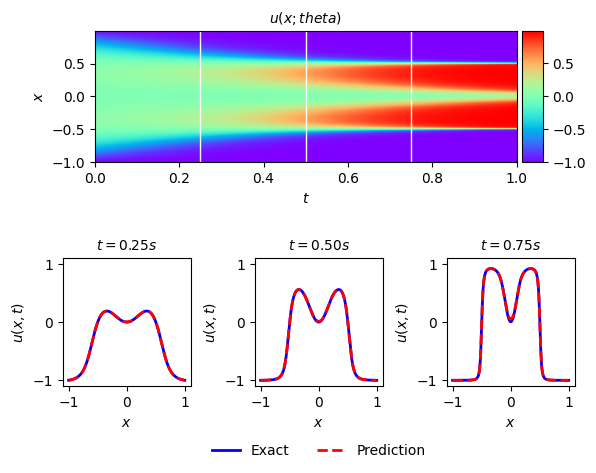

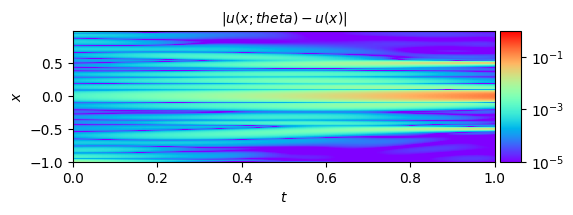

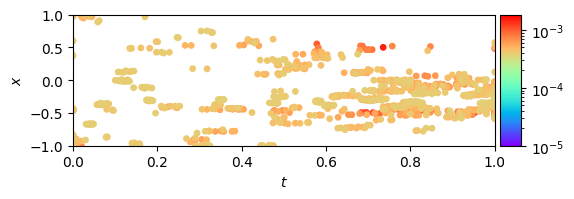

k= 9
1000 tensor(3.1073e-07, device='cuda:0', grad_fn=<AddBackward0>)
2000 tensor(3.1062e-07, device='cuda:0', grad_fn=<AddBackward0>)
3000 tensor(3.1056e-07, device='cuda:0', grad_fn=<AddBackward0>)
4000 tensor(3.1052e-07, device='cuda:0', grad_fn=<AddBackward0>)
5000 tensor(3.1051e-07, device='cuda:0', grad_fn=<AddBackward0>)
6000 tensor(3.1047e-07, device='cuda:0', grad_fn=<AddBackward0>)
7000 tensor(3.1044e-07, device='cuda:0', grad_fn=<AddBackward0>)
8000 tensor(3.1040e-07, device='cuda:0', grad_fn=<AddBackward0>)
9000 tensor(3.1038e-07, device='cuda:0', grad_fn=<AddBackward0>)
10000 tensor(3.1036e-07, device='cuda:0', grad_fn=<AddBackward0>)
11000 tensor(3.1032e-07, device='cuda:0', grad_fn=<AddBackward0>)
12000 tensor(3.1029e-07, device='cuda:0', grad_fn=<AddBackward0>)
13000 tensor(3.1024e-07, device='cuda:0', grad_fn=<AddBackward0>)
14000 tensor(3.1024e-07, device='cuda:0', grad_fn=<AddBackward0>)
15000 tensor(3.1021e-07, device='cuda:0', grad_fn=<AddBackward0>)
16000 tensor(3

125000 tensor(3.0760e-07, device='cuda:0', grad_fn=<AddBackward0>)
126000 tensor(3.0758e-07, device='cuda:0', grad_fn=<AddBackward0>)
127000 tensor(3.0756e-07, device='cuda:0', grad_fn=<AddBackward0>)
128000 tensor(3.0756e-07, device='cuda:0', grad_fn=<AddBackward0>)
129000 tensor(1.0264e-05, device='cuda:0', grad_fn=<AddBackward0>)
130000 tensor(3.0753e-07, device='cuda:0', grad_fn=<AddBackward0>)
131000 tensor(3.0750e-07, device='cuda:0', grad_fn=<AddBackward0>)
132000 tensor(3.0747e-07, device='cuda:0', grad_fn=<AddBackward0>)
133000 tensor(3.0747e-07, device='cuda:0', grad_fn=<AddBackward0>)
134000 tensor(3.0742e-07, device='cuda:0', grad_fn=<AddBackward0>)
135000 tensor(3.0738e-07, device='cuda:0', grad_fn=<AddBackward0>)
136000 tensor(3.0736e-07, device='cuda:0', grad_fn=<AddBackward0>)
137000 tensor(3.0735e-07, device='cuda:0', grad_fn=<AddBackward0>)
138000 tensor(3.0735e-07, device='cuda:0', grad_fn=<AddBackward0>)
139000 tensor(3.0733e-07, device='cuda:0', grad_fn=<AddBackwar

248000 tensor(3.0509e-07, device='cuda:0', grad_fn=<AddBackward0>)
249000 tensor(3.0505e-07, device='cuda:0', grad_fn=<AddBackward0>)
250000 tensor(3.0503e-07, device='cuda:0', grad_fn=<AddBackward0>)
251000 tensor(3.0502e-07, device='cuda:0', grad_fn=<AddBackward0>)
252000 tensor(3.0502e-07, device='cuda:0', grad_fn=<AddBackward0>)
253000 tensor(3.0498e-07, device='cuda:0', grad_fn=<AddBackward0>)
254000 tensor(3.0497e-07, device='cuda:0', grad_fn=<AddBackward0>)
255000 tensor(3.0699e-07, device='cuda:0', grad_fn=<AddBackward0>)
256000 tensor(3.0495e-07, device='cuda:0', grad_fn=<AddBackward0>)
257000 tensor(3.0493e-07, device='cuda:0', grad_fn=<AddBackward0>)
258000 tensor(3.0491e-07, device='cuda:0', grad_fn=<AddBackward0>)
259000 tensor(3.0488e-07, device='cuda:0', grad_fn=<AddBackward0>)
260000 tensor(3.0486e-07, device='cuda:0', grad_fn=<AddBackward0>)
261000 tensor(3.0485e-07, device='cuda:0', grad_fn=<AddBackward0>)
262000 tensor(3.0483e-07, device='cuda:0', grad_fn=<AddBackwar

371000 tensor(3.0259e-07, device='cuda:0', grad_fn=<AddBackward0>)
372000 tensor(3.0256e-07, device='cuda:0', grad_fn=<AddBackward0>)
373000 tensor(3.0254e-07, device='cuda:0', grad_fn=<AddBackward0>)
374000 tensor(3.0251e-07, device='cuda:0', grad_fn=<AddBackward0>)
375000 tensor(3.0250e-07, device='cuda:0', grad_fn=<AddBackward0>)
376000 tensor(3.0248e-07, device='cuda:0', grad_fn=<AddBackward0>)
377000 tensor(3.0247e-07, device='cuda:0', grad_fn=<AddBackward0>)
378000 tensor(3.0244e-07, device='cuda:0', grad_fn=<AddBackward0>)
379000 tensor(3.0243e-07, device='cuda:0', grad_fn=<AddBackward0>)
380000 tensor(3.0239e-07, device='cuda:0', grad_fn=<AddBackward0>)
381000 tensor(3.0237e-07, device='cuda:0', grad_fn=<AddBackward0>)
382000 tensor(3.0238e-07, device='cuda:0', grad_fn=<AddBackward0>)
383000 tensor(3.0573e-07, device='cuda:0', grad_fn=<AddBackward0>)
384000 tensor(3.0233e-07, device='cuda:0', grad_fn=<AddBackward0>)
385000 tensor(3.0230e-07, device='cuda:0', grad_fn=<AddBackwar

494000 tensor(8.3307e-07, device='cuda:0', grad_fn=<AddBackward0>)
495000 tensor(3.0033e-07, device='cuda:0', grad_fn=<AddBackward0>)
496000 tensor(3.0030e-07, device='cuda:0', grad_fn=<AddBackward0>)
497000 tensor(3.0028e-07, device='cuda:0', grad_fn=<AddBackward0>)
498000 tensor(3.0028e-07, device='cuda:0', grad_fn=<AddBackward0>)
499000 tensor(3.0026e-07, device='cuda:0', grad_fn=<AddBackward0>)
500000 tensor(3.0025e-07, device='cuda:0', grad_fn=<AddBackward0>)
501000 tensor(3.0023e-07, device='cuda:0', grad_fn=<AddBackward0>)
502000 tensor(3.0019e-07, device='cuda:0', grad_fn=<AddBackward0>)
503000 tensor(3.0018e-07, device='cuda:0', grad_fn=<AddBackward0>)
504000 tensor(3.0015e-07, device='cuda:0', grad_fn=<AddBackward0>)
505000 tensor(3.0016e-07, device='cuda:0', grad_fn=<AddBackward0>)
506000 tensor(4.0401e-07, device='cuda:0', grad_fn=<AddBackward0>)
507000 tensor(3.0011e-07, device='cuda:0', grad_fn=<AddBackward0>)
508000 tensor(3.0007e-07, device='cuda:0', grad_fn=<AddBackwar

617000 tensor(2.9824e-07, device='cuda:0', grad_fn=<AddBackward0>)
618000 tensor(2.9823e-07, device='cuda:0', grad_fn=<AddBackward0>)
619000 tensor(2.9819e-07, device='cuda:0', grad_fn=<AddBackward0>)
620000 tensor(2.9818e-07, device='cuda:0', grad_fn=<AddBackward0>)
621000 tensor(2.9815e-07, device='cuda:0', grad_fn=<AddBackward0>)
622000 tensor(2.9814e-07, device='cuda:0', grad_fn=<AddBackward0>)
623000 tensor(2.9813e-07, device='cuda:0', grad_fn=<AddBackward0>)
624000 tensor(2.9811e-07, device='cuda:0', grad_fn=<AddBackward0>)
625000 tensor(2.9811e-07, device='cuda:0', grad_fn=<AddBackward0>)
626000 tensor(2.9807e-07, device='cuda:0', grad_fn=<AddBackward0>)
627000 tensor(2.9808e-07, device='cuda:0', grad_fn=<AddBackward0>)
628000 tensor(2.9930e-07, device='cuda:0', grad_fn=<AddBackward0>)
629000 tensor(2.9805e-07, device='cuda:0', grad_fn=<AddBackward0>)
630000 tensor(2.9801e-07, device='cuda:0', grad_fn=<AddBackward0>)
631000 tensor(2.9800e-07, device='cuda:0', grad_fn=<AddBackwar

740000 tensor(2.9606e-07, device='cuda:0', grad_fn=<AddBackward0>)
741000 tensor(2.9604e-07, device='cuda:0', grad_fn=<AddBackward0>)
742000 tensor(2.9602e-07, device='cuda:0', grad_fn=<AddBackward0>)
743000 tensor(2.9600e-07, device='cuda:0', grad_fn=<AddBackward0>)
744000 tensor(2.9600e-07, device='cuda:0', grad_fn=<AddBackward0>)
745000 tensor(2.9597e-07, device='cuda:0', grad_fn=<AddBackward0>)
746000 tensor(2.9595e-07, device='cuda:0', grad_fn=<AddBackward0>)
747000 tensor(2.9593e-07, device='cuda:0', grad_fn=<AddBackward0>)
748000 tensor(2.9591e-07, device='cuda:0', grad_fn=<AddBackward0>)
749000 tensor(2.9590e-07, device='cuda:0', grad_fn=<AddBackward0>)
750000 tensor(2.9587e-07, device='cuda:0', grad_fn=<AddBackward0>)
751000 tensor(2.9586e-07, device='cuda:0', grad_fn=<AddBackward0>)
752000 tensor(2.9585e-07, device='cuda:0', grad_fn=<AddBackward0>)
753000 tensor(2.9583e-07, device='cuda:0', grad_fn=<AddBackward0>)
754000 tensor(2.9580e-07, device='cuda:0', grad_fn=<AddBackwar

863000 tensor(2.9404e-07, device='cuda:0', grad_fn=<AddBackward0>)
864000 tensor(2.9402e-07, device='cuda:0', grad_fn=<AddBackward0>)
865000 tensor(2.9401e-07, device='cuda:0', grad_fn=<AddBackward0>)
866000 tensor(2.9399e-07, device='cuda:0', grad_fn=<AddBackward0>)
867000 tensor(2.9397e-07, device='cuda:0', grad_fn=<AddBackward0>)
868000 tensor(2.9396e-07, device='cuda:0', grad_fn=<AddBackward0>)
869000 tensor(2.9394e-07, device='cuda:0', grad_fn=<AddBackward0>)
870000 tensor(2.9393e-07, device='cuda:0', grad_fn=<AddBackward0>)
871000 tensor(2.9391e-07, device='cuda:0', grad_fn=<AddBackward0>)
872000 tensor(2.9388e-07, device='cuda:0', grad_fn=<AddBackward0>)
873000 tensor(6.9790e-07, device='cuda:0', grad_fn=<AddBackward0>)
874000 tensor(2.9384e-07, device='cuda:0', grad_fn=<AddBackward0>)
875000 tensor(2.9383e-07, device='cuda:0', grad_fn=<AddBackward0>)
876000 tensor(2.9382e-07, device='cuda:0', grad_fn=<AddBackward0>)
877000 tensor(2.9382e-07, device='cuda:0', grad_fn=<AddBackwar

986000 tensor(2.9209e-07, device='cuda:0', grad_fn=<AddBackward0>)
987000 tensor(2.9207e-07, device='cuda:0', grad_fn=<AddBackward0>)
988000 tensor(2.9205e-07, device='cuda:0', grad_fn=<AddBackward0>)
989000 tensor(2.9205e-07, device='cuda:0', grad_fn=<AddBackward0>)
990000 tensor(2.9202e-07, device='cuda:0', grad_fn=<AddBackward0>)
991000 tensor(2.9202e-07, device='cuda:0', grad_fn=<AddBackward0>)
992000 tensor(2.9199e-07, device='cuda:0', grad_fn=<AddBackward0>)
993000 tensor(2.9197e-07, device='cuda:0', grad_fn=<AddBackward0>)
994000 tensor(2.9196e-07, device='cuda:0', grad_fn=<AddBackward0>)
995000 tensor(2.9194e-07, device='cuda:0', grad_fn=<AddBackward0>)
996000 tensor(2.9193e-07, device='cuda:0', grad_fn=<AddBackward0>)
997000 tensor(2.9215e-07, device='cuda:0', grad_fn=<AddBackward0>)
998000 tensor(2.9189e-07, device='cuda:0', grad_fn=<AddBackward0>)
999000 tensor(2.9185e-07, device='cuda:0', grad_fn=<AddBackward0>)
1000000 tensor(2.9184e-07, device='cuda:0', grad_fn=<AddBackwa

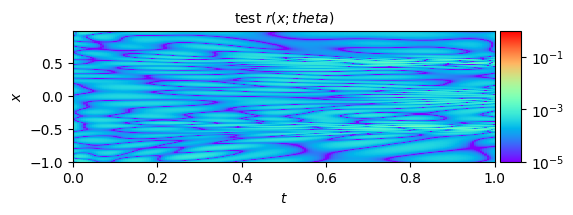

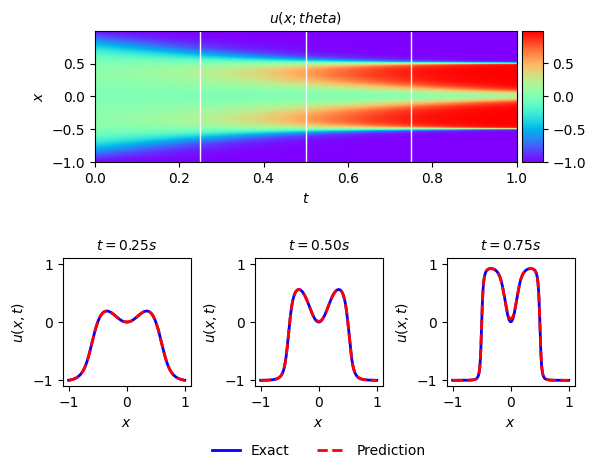

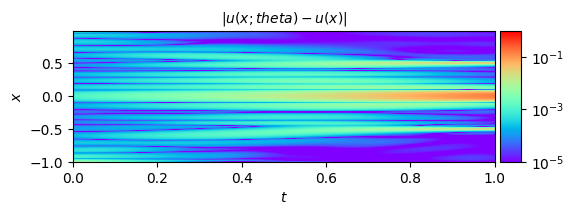

In [7]:
''' k=5 '''
for k in range(5,10):
    x_train = np.vstack([x_train, x_adv])
    x_adv = generate_attack_samples(PINN, device, x_train, N0)
    print("k=", k)
    retrain(PINN, x_train, x_adv, x_boundary, u_boundary, x_test, u_test, U_gt)